In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

import ipyparallel as ipp

from time import time
from datetime import datetime

import motif as mf

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

from scipy.stats import spearmanr
from scipy.stats import pearsonr

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
### set parameters for the motif analysis

PROTEIN_NAME = 'A2BP1'
PROT_CONC = 0.002  # free protein concentration at binding reation; PBM typically 0.1 and RNACompete typically 0.002
BOTH_STRANDS = False  # wheter both strands are present for binding; True if double-stranded DNA or RNA is used as probes
TIME_DISS = 1800  # experimental time span after binding reaction during which dissociation of the protein from the probe was possible

STAGES=mf.stage(protein=PROTEIN_NAME)

In [4]:
### read data

### read data

## RNAcompete sample data
dfprobes_raw=pd.read_excel('./data/RNAcompete/A2BP1.xlsx')
#dfprobes_raw=pd.read_excel('./data/RNAcompete/HNRNPA1.xlsx')
#dfprobes_raw=pd.read_excel('./data/RNAcompete/PTBP1.xlsx')
#dfprobes_raw=pd.read_excel('./data/RNAcompete/RBM24.xlsx')


#dfprobes_raw=pd.read_csv('./data/samplePBMs/Mlx__pTH2882_HK.raw', sep='\t')
#dfprobes_raw=pd.read_csv('./data/samplePBMs/Klf9__pTH2353_HK.raw', sep='\t')
#dfprobes_raw=pd.read_csv('./data/samplePBMs/Prdm11__pTH3455_HK.raw', sep='\t')
#dfprobes_raw=pd.read_csv('./data/samplePBMs/Sox10__pTH1729_HK.raw', sep='\t')


print('Columns of imported Data File: %s' % dfprobes_raw.columns)
#dfprobes_raw.describe()
#dfprobes_raw.info()

Columns of imported Data File: Index(['Probe_Set', 'RNA_Seq', 'Probe_ID', 'raw', 'norm'], dtype='object')


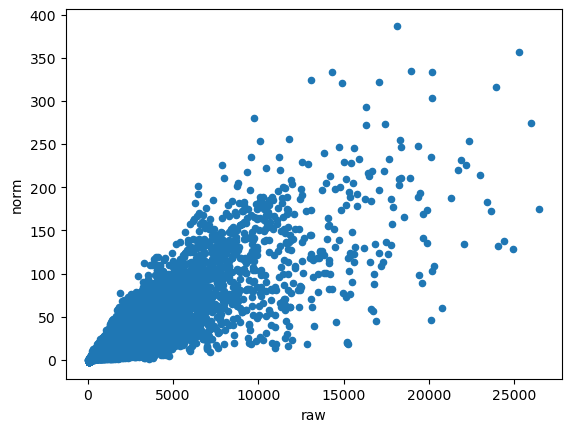

In [5]:
dfprobes_raw.plot(x='raw', y='norm', kind='scatter')

I: RNA probes detected!


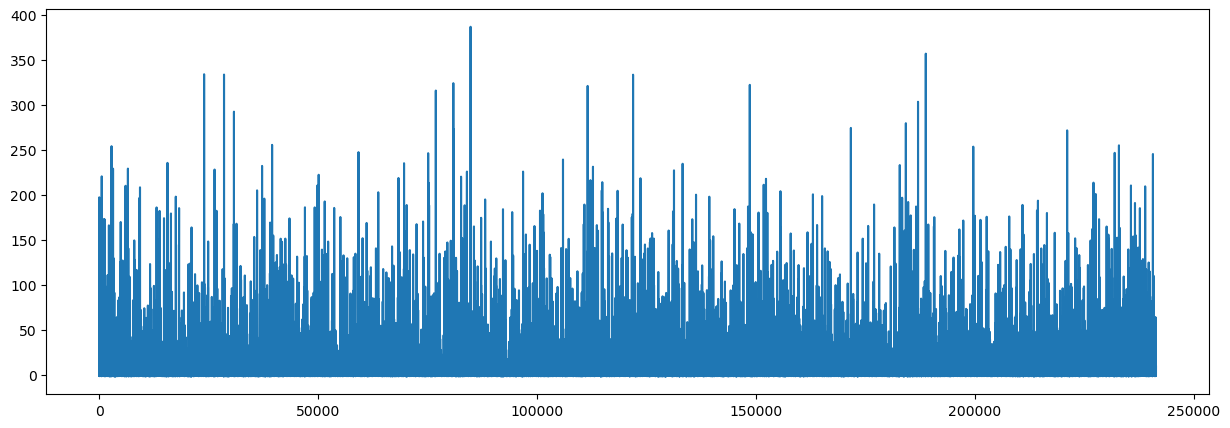

In [6]:
### select columns for probe sequence and signal

column_sequence = 'RNA_Seq'
column_signal = 'norm'
#background_signal = 'mean_background_intensity'  #set to None if not needed
background_signal=None

#basic preprocessing
dfprobes_raw[column_signal] = dfprobes_raw[column_signal].apply(
    lambda a: np.NaN if a == ' ' else a)
dfprobes_raw[column_sequence] = dfprobes_raw[column_sequence].apply(
    lambda a: np.NaN if a == 'nan' else a)
dfprobes_raw = dfprobes_raw.dropna()

#construct new dataframe with only necessary data
if type(background_signal) == type(None):
    dfprobes = pd.DataFrame({
        'seq':
        dfprobes_raw[column_sequence].astype(str),
        'signal binding':
        dfprobes_raw[column_signal].astype(np.float32)
    })  #rebuild dataframe
else:
    dfprobes = pd.DataFrame({
        'seq':
        dfprobes_raw[column_sequence].astype(str),
        'signal':
        dfprobes_raw[column_signal].astype(np.float32),
        'background':
        dfprobes_raw[background_signal].astype(np.float32)
    })  #rebuild dataframe
    dfprobes['signal binding'] = dfprobes['signal'] - dfprobes['background']
# display main properties of data set

dfprobes['signal binding'] = dfprobes['signal binding']

dfprobes['signal binding'].plot(figsize=(15, 5))
dfprobes.describe()

### check type of nucleic acid

dfprobes['seq'] = dfprobes['seq'].apply(
    lambda seq: seq.upper().replace(" ", ""))  #upper and remove blanks
dfprobes['RNA'] = dfprobes['seq'].apply(
    lambda seq: all(char in 'ACGU' for char in seq))
dfprobes['DNA'] = dfprobes['seq'].apply(
    lambda seq: all(char in 'ACGT' for char in seq))
non_RNA_counts = len(dfprobes[dfprobes['RNA'] == False])
non_DNA_counts = len(dfprobes[dfprobes['DNA'] == False])

if non_RNA_counts < non_DNA_counts:
    NUC_TYPE = 'RNA'
    print('I: RNA probes detected!')
else:
    NUC_TYPE = 'DNA'
    print('I: DNA probes detected!')

if NUC_TYPE == 'RNA' and non_RNA_counts != 0:
    print(
        'E: The probe sequences appear to be RNA, however there are some non-RNA nucleotides in the sequences.'
    )
    print('E: Please check the following sequnces %s' %
          dfprobes[dfprobes['RNA'] == False])

if NUC_TYPE == 'DNA' and non_DNA_counts != 0:
    print(
        'E: The probe sequences appear to be RNA, however there are some non-RNA nucleotides in the sequences.'
    )
    print('E: Please check the following sequnces %s' %
          dfprobes[dfprobes['DNA'] == False])

In [10]:
### option to add a constant sequence at the 3' end and 5' end
sequence_to_be_added_5 = ''
sequence_to_be_added_3 = ''  # standard PBM arrays: CCTGTGTGAAATTGTTATCCGCTCT T7 array: GTCTTGA..
dfprobes['seq'] = sequence_to_be_added_5.upper(
) + dfprobes['seq'] + sequence_to_be_added_3.upper()
print(
    f"I: The nucleotide sequence {sequence_to_be_added_5.upper()} has been added to the 5' end all probe sequences."
)
print(
    f"I: The nucleotide sequence {sequence_to_be_added_3.upper()} has been added to the 3' end all probe sequences."
)

I: The nucleotide sequence  has been added to the 5' end all probe sequences.
I: The nucleotide sequence  has been added to the 3' end all probe sequences.


I: Probes length is not uniform, detected range: 30 ..41
I: Probe sequences have been padded at the 5' to the uniform length of 41 nucleotides
I: Total datasets contains 241319 sequences.
I: Visualisation of the base composition per position
I: If positions are invariant they can be removed before sequence analysis.


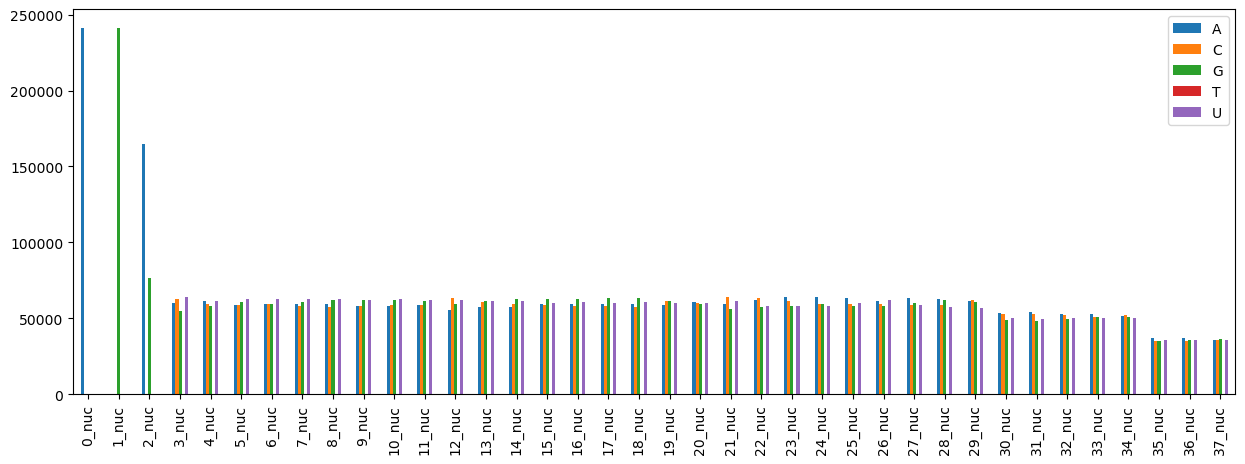

In [11]:
### egalize length
dfprobes['seq_length'] = dfprobes['seq'].apply(len)

if max(dfprobes['seq_length']) != min(dfprobes['seq_length']):
    print('I: Probes length is not uniform, detected range: %i ..%i' %
          (min(dfprobes['seq_length']), max(dfprobes['seq_length'])))
    max_length = max(dfprobes['seq_length'])
    dfprobes['padded_sequence'] = dfprobes['seq'].apply(
        lambda seq: seq + ((max_length - len(seq)) * '-'))
    print(
        "I: Probe sequences have been padded at the 5' to the uniform length of %i nucleotides"
        % max_length)
else:
    print('I: Probe sequences have the uniform length of %i nucleotides' %
          (dfprobes['seq_length'].median()))
    dfprobes['padded_sequence'] = dfprobes['seq']

print('I: Total datasets contains %i sequences.' % len(dfprobes))

# visualize composition of each position
df_nucleotides = mf.split_sequence_in_nucleotides(dfprobes['seq'])
dfcount = pd.DataFrame(index=['A', 'C', 'G', 'T', 'U'])
for column in df_nucleotides:
    dfcount[column] = df_nucleotides[column].value_counts()
dfcount = dfcount.fillna(0)  #zeros for NaN
dfcount.transpose().plot(figsize=(15, 5), kind='bar')
print('I: Visualisation of the base composition per position')
print(
    'I: If positions are invariant they can be removed before sequence analysis.'
)

I: Visualisation of the base composition per position after slicing.


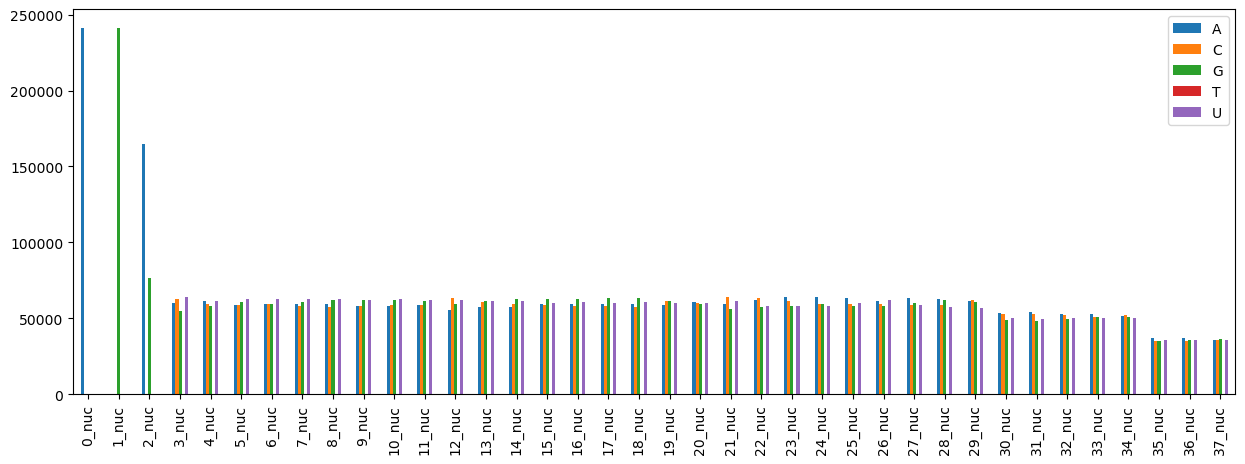

I: The whole dataset has been used to set the threshold for a positive probe.
I: The threshold is 38.582768
I: 1951 probes of 241319 are above threshold.


In [12]:
# You may remove invariant continuos positions by adjusting the slicing.
# It is recommended to leave a few invariant positions to allow for binding events
# between the variable and constant part of the probes.

dfprobes['seq'] = dfprobes['seq'].apply(lambda s: s[:])  ### <==== do the slicing here

# visualize composition of each position
print('I: Visualisation of the base composition per position after slicing.')
df_nucleotides = mf.split_sequence_in_nucleotides(dfprobes['seq'])
dfcount = pd.DataFrame(index=['A', 'C', 'G', 'T', 'U'])
for column in df_nucleotides:
    dfcount[column] = df_nucleotides[column].value_counts()
dfcount = dfcount.fillna(0)  #zeros for NaN
dfcount.transpose().plot(figsize=(15, 5), kind='bar')
plt.show()

# preparation for later classification
mean = dfprobes['signal binding'].mean()
std = dfprobes['signal binding'].std()
THRESHOLD = mean + 4 * std  #4*std used according to Weirauch et al., 2013
dfprobes['positive probe'] = dfprobes['signal binding'].apply(
    lambda s: True if s > THRESHOLD else False)

print(
    'I: The whole dataset has been used to set the threshold for a positive probe.'
)
print('I: The threshold is %f' % THRESHOLD)
print(
    f"I: {len(dfprobes[dfprobes['positive probe']])} probes of {len(dfprobes)} are above threshold."
)

if len(dfprobes[dfprobes['positive probe']]) == 0:
    print(
        'E: No probe above THRESHOLD. Classification is not possible. Please adjust the THRESHOLD.'
    )

I: The whole dataset has been split in training (80%) and test (20%) datasets.


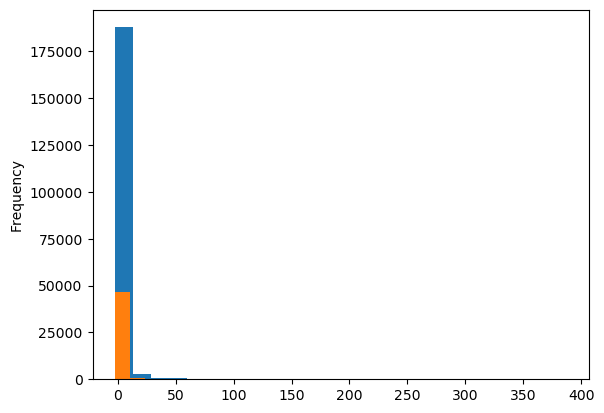

I: A downsampled dataset containing the lowest and highest 4.0 % of the dataset is generated.
I: Median values of lowest and highest 4.0 %:  -1.2918970584869385  17.524303436279297
I: The dataset is further downsampled to 1000 sequences.
I: Histogramm of the downsampled dataset.


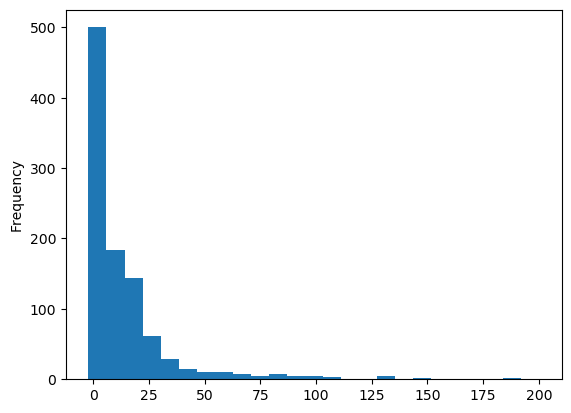

In [13]:
### Shuffle and prepare dataset for training and testing

# shuffle and split
dfprobes = shuffle(dfprobes)
dftrain, dftest = train_test_split(dfprobes, test_size=0.2)

print(
    'I: The whole dataset has been split in training (80%) and test (20%) datasets.'
)

# display histogramms of test and training set
dftrain['signal binding'].plot(kind='hist', bins=25)
dftest['signal binding'].plot(kind='hist', bins=25)
plt.show()

# generate a subset with maximal 1000 probes

downsampled_size = 1000  # You may change downsampled size here.

percentile = 0.5 * downsampled_size / len(
    dftrain
) * 100  #percentile required for lowest and highest to achieve down-sampled size
if percentile < 4:
    percentile = 4  #do not use only the extreme values
elif percentile > 10:
    percentile = 10  #avoid taking value from the mid-range

if len(dftrain) * percentile * 2 / 100 < downsampled_size / 4:
    print('W: The subset only contains %i probes - a rather low number.' %
          dftrain * percentile * 2 / 100)

print(
    'I: A downsampled dataset containing the lowest and highest %.1f %% of the dataset is generated.'
    % percentile)
dfsubset_high = dftrain[dftrain['signal binding'] >= dftrain['signal binding'].quantile(1 - percentile / 100)]  # highest part
dfsubset_low = dftrain[dftrain['signal binding'] <= dftrain['signal binding'].quantile(percentile / 100)]  # lowest part
print('I: Median values of lowest and highest %.1f %%:  %r  %r' %
      (percentile, dfsubset_low['signal binding'].quantile(0.5),
       dfsubset_high['signal binding'].quantile(0.5)))

if len(dfsubset_high) + len(dfsubset_low) > downsampled_size:
    print('I: The dataset is further downsampled to %i sequences.' %
          downsampled_size)
    dfsubset_high = dfsubset_high.sample(downsampled_size - int(downsampled_size / 2))
    dfsubset_low = dfsubset_low.sample(int(downsampled_size / 2))
    dfsubset = pd.concat([dfsubset_high, dfsubset_low])
else:
    dfsubset = pd.concat([dfsubset_high, dfsubset_low])

dfsubset = shuffle(dfsubset)   
    
# display main properties of downsampled data set
print('I: Histogramm of the downsampled dataset.')
dfsubset['signal binding'].plot(kind='hist', bins=25)
plt.show()

# establish numpy arrays of the sequenc and binding data in the dataframes

# complete data
X=mf.hotencode_sequence(dfprobes['padded_sequence'], nuc_type=NUC_TYPE)
y=np.array(dfprobes['signal binding'])

# training set
X_train=mf.hotencode_sequence(dftrain['padded_sequence'], nuc_type=NUC_TYPE)
y_train=np.array(dftrain['signal binding'])

# subset of training set
X_subset=mf.hotencode_sequence(dfsubset['padded_sequence'], nuc_type=NUC_TYPE)
y_subset=np.array(dfsubset['signal binding'])

# test set
X_test=mf.hotencode_sequence(dftest['padded_sequence'], nuc_type=NUC_TYPE)
y_test=np.array(dftest['signal binding'])

I: Optimization took 0.03 hours.
I: energy matrix and logos:



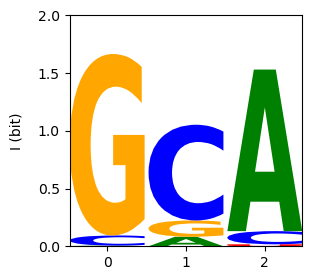

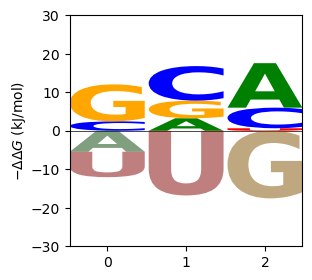


        A     C      G      U
0   5436 -2453  -9596   6613
1  -3252 -8968  -4579  16801
2 -11557 -5349  17560   -652

I: summed absolute energies of each position:
0    24100
1    33602
2    35120
dtype: int64

I: averaged summed energy over all positions: 30941
I: Mean and Standard Deviation for the Free Energy G to all subsequences of all probes: -21047 +/- 15693
I: Plot of the Occupancy of a subsite as the function of the Free Energy G 
   overlaid with the distribution of the Free Energy of all subsites.
I: There shall be only a small overlap of both curves. i.e. only the most negative Free Energies
    lead to a measurable occupancy.


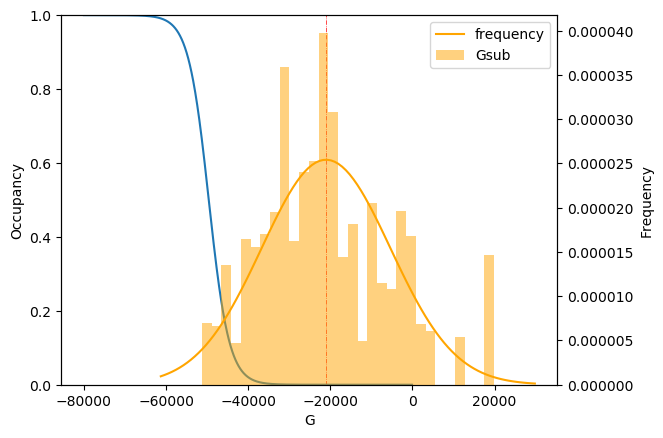

I: Calculated occupancy over all subsite of a single probe:
   binding:  0.00941 .. 2.84867 (ratio: 302.6)
I: number of probes: 1000
I: Pearson Correlation  r: 0.3992
I: mean absolute error: 12.7241


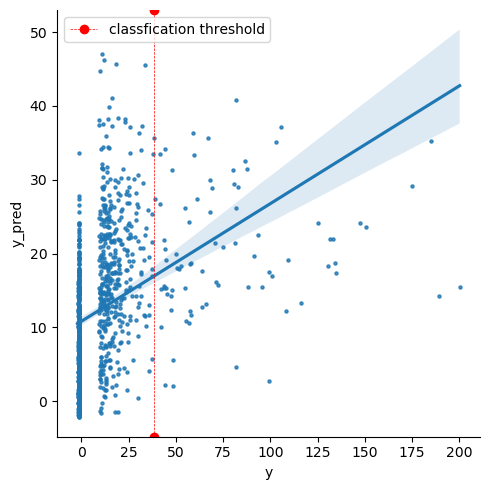

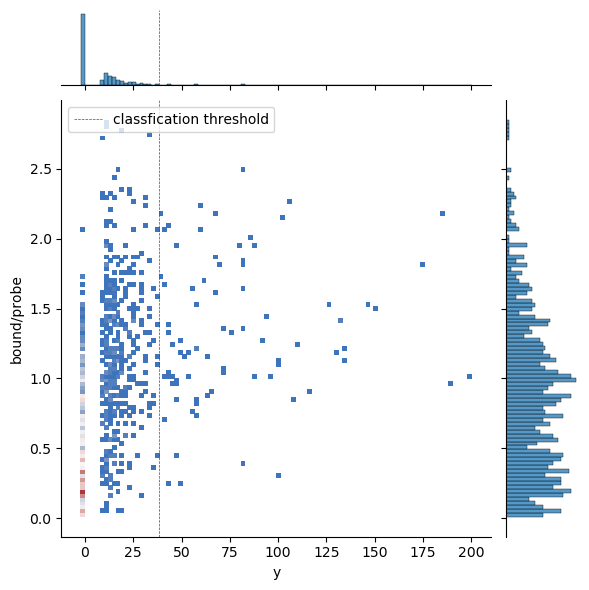

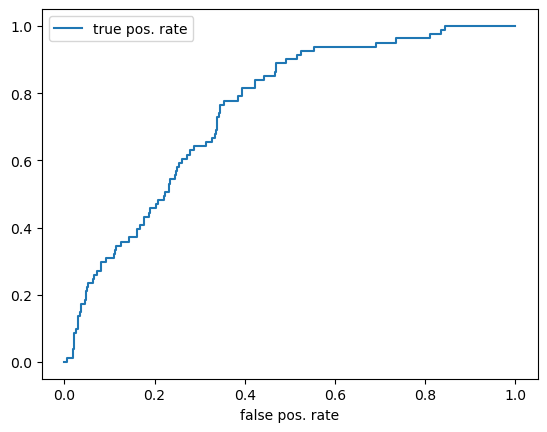

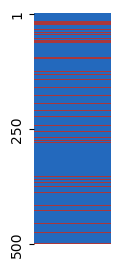

I: Classification performance AUROC: 0.7516



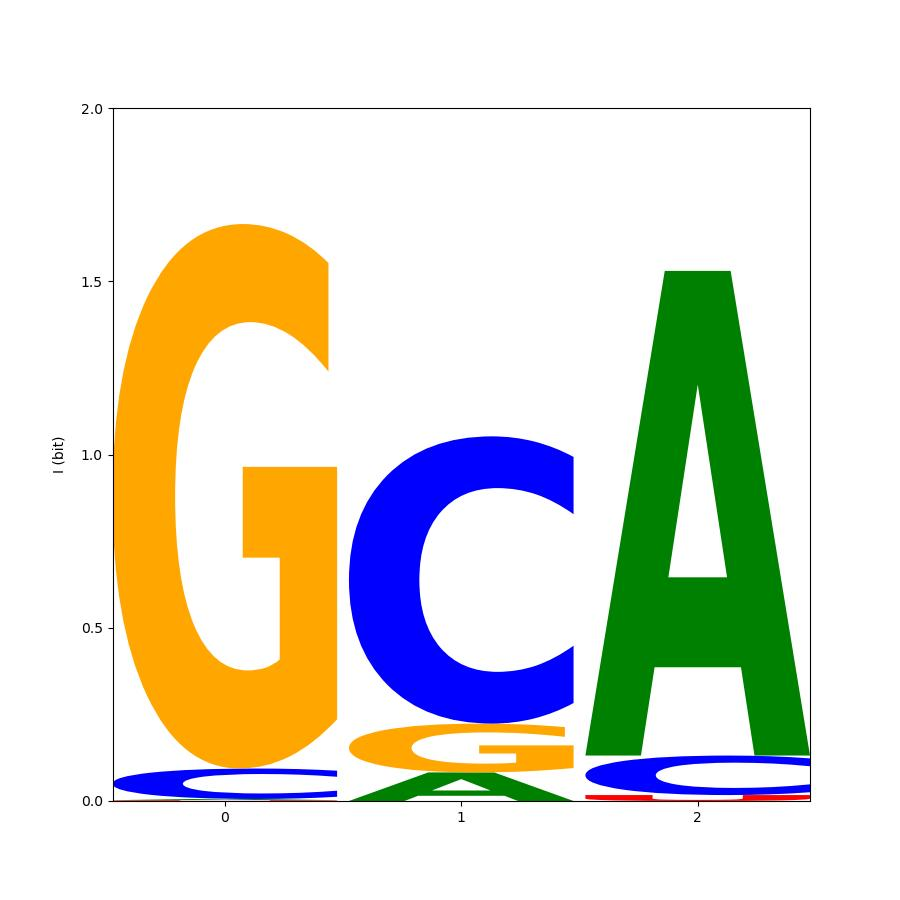

In [14]:
### perform a quick & dirty round for a short motif by fitting on subset to check data integrity

#fit regression quick_model
quick_model=mf.findmotif(motif_length=3, protein_conc=PROT_CONC, both_strands=BOTH_STRANDS, ftol=0.01)

start = time()
quick_model.fit(X_subset,y_subset)
print("I: Optimization took %.2f hours." % ((time() - start)/3600))

# print & display main results
quick_model.analyse_motif(X_subset,y_subset, THRESHOLD, nuc_type=NUC_TYPE)

# store results and display stages
STAGES.append('quick', quick_model)
mf.display_df(STAGES.df, nuc_type=NUC_TYPE)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
GridSearchCV took 0.55 hours for 6 candidate parameter settings.
I: number of samples: 1000
I: Plot of r2 vs motif length and vs root(motif length)


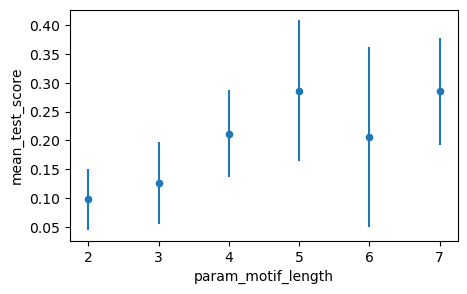

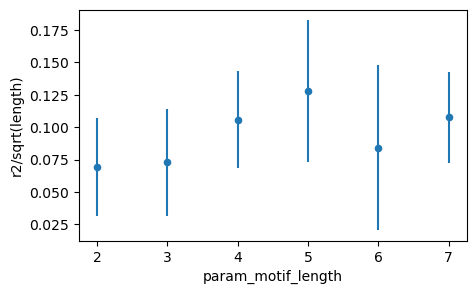

I: The maximum (5) is suggested as CORE_MOTIF_LENGTH
I: motif obtained with the best estimator from gridCV search
I: energy matrix and logos:



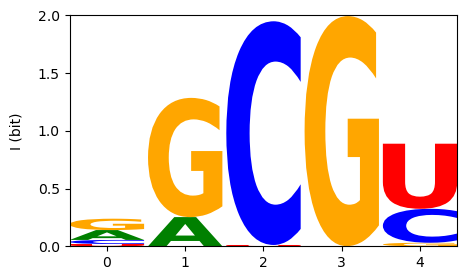

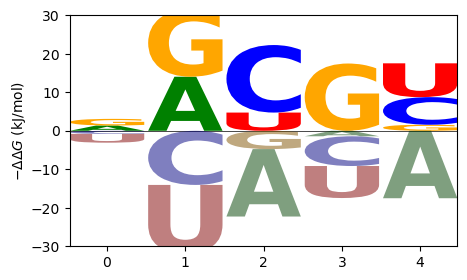


        A      C      G      U
0  -1372    813  -1721   2280
1 -14043  14064 -17529  17508
2  17513 -17542   4757  -4728
3   1427   7725 -17472   8320
4  17520  -7171  -1566  -8782

I: summed absolute energies of each position:
0     6187
1    63146
2    44542
3    34945
4    35041
dtype: int64

I: averaged summed energy over all positions: 36772
I: Mean and Standard Deviation for the Free Energy G to all subsequences of all probes: -15218 +/- 24278
I: Plot of the Occupancy of a subsite as the function of the Free Energy G 
   overlaid with the distribution of the Free Energy of all subsites.
I: There shall be only a small overlap of both curves. i.e. only the most negative Free Energies
    lead to a measurable occupancy.


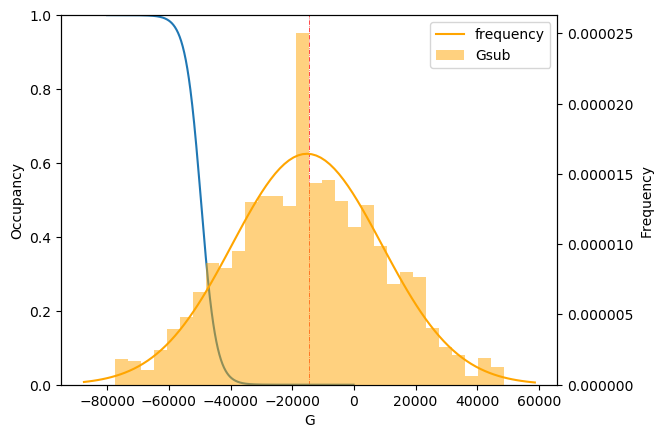

I: Calculated occupancy over all subsite of a single probe:
   binding:  0.00792 .. 9.62832 (ratio: 1216.0)
I: number of probes: 1000
I: Pearson Correlation  r: 0.3950
I: mean absolute error: 12.7510


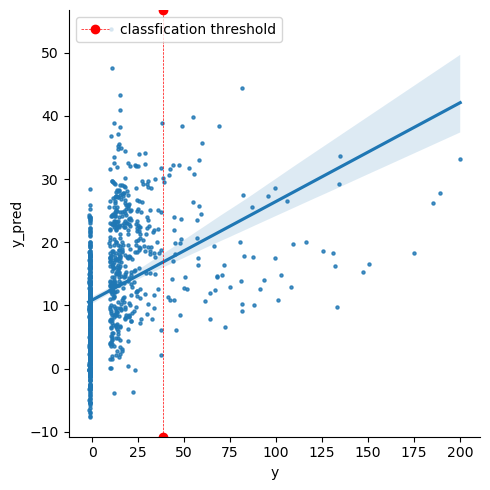

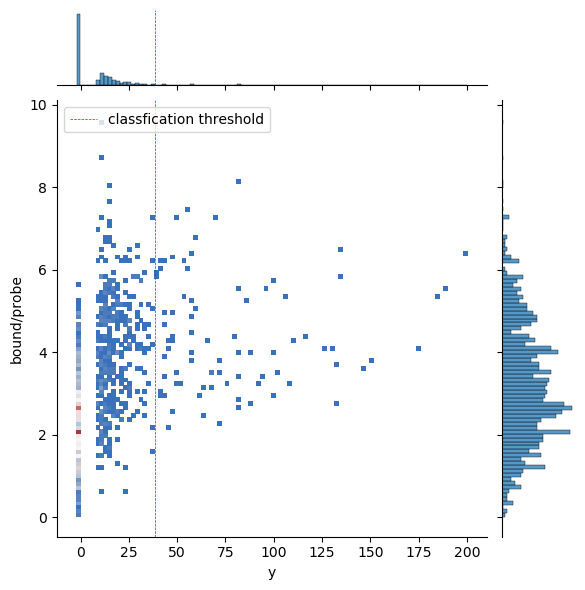

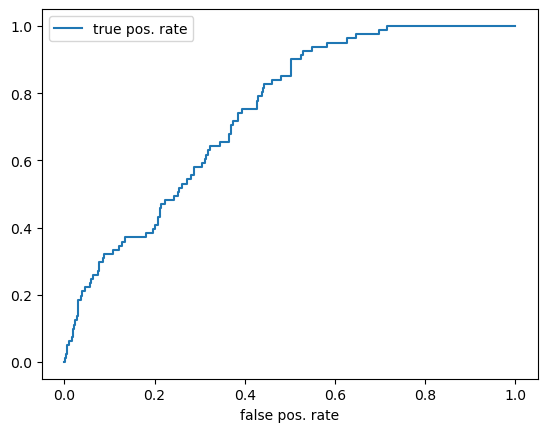

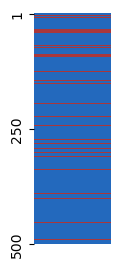

I: Classification performance AUROC: 0.7431



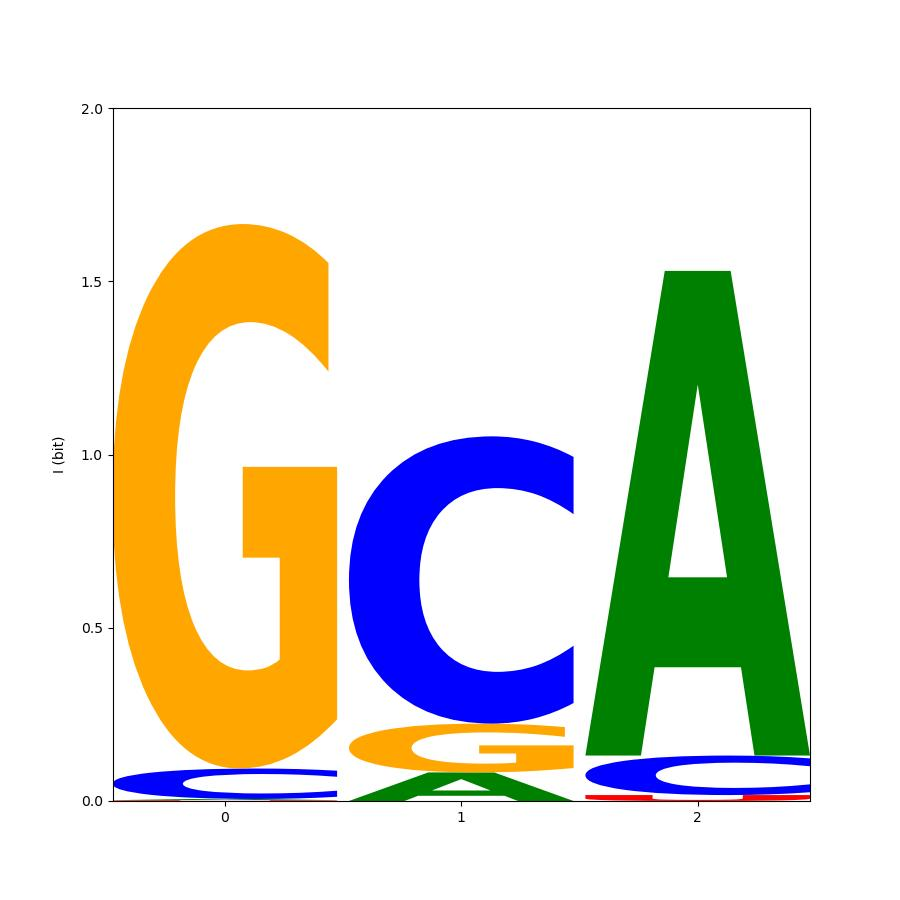
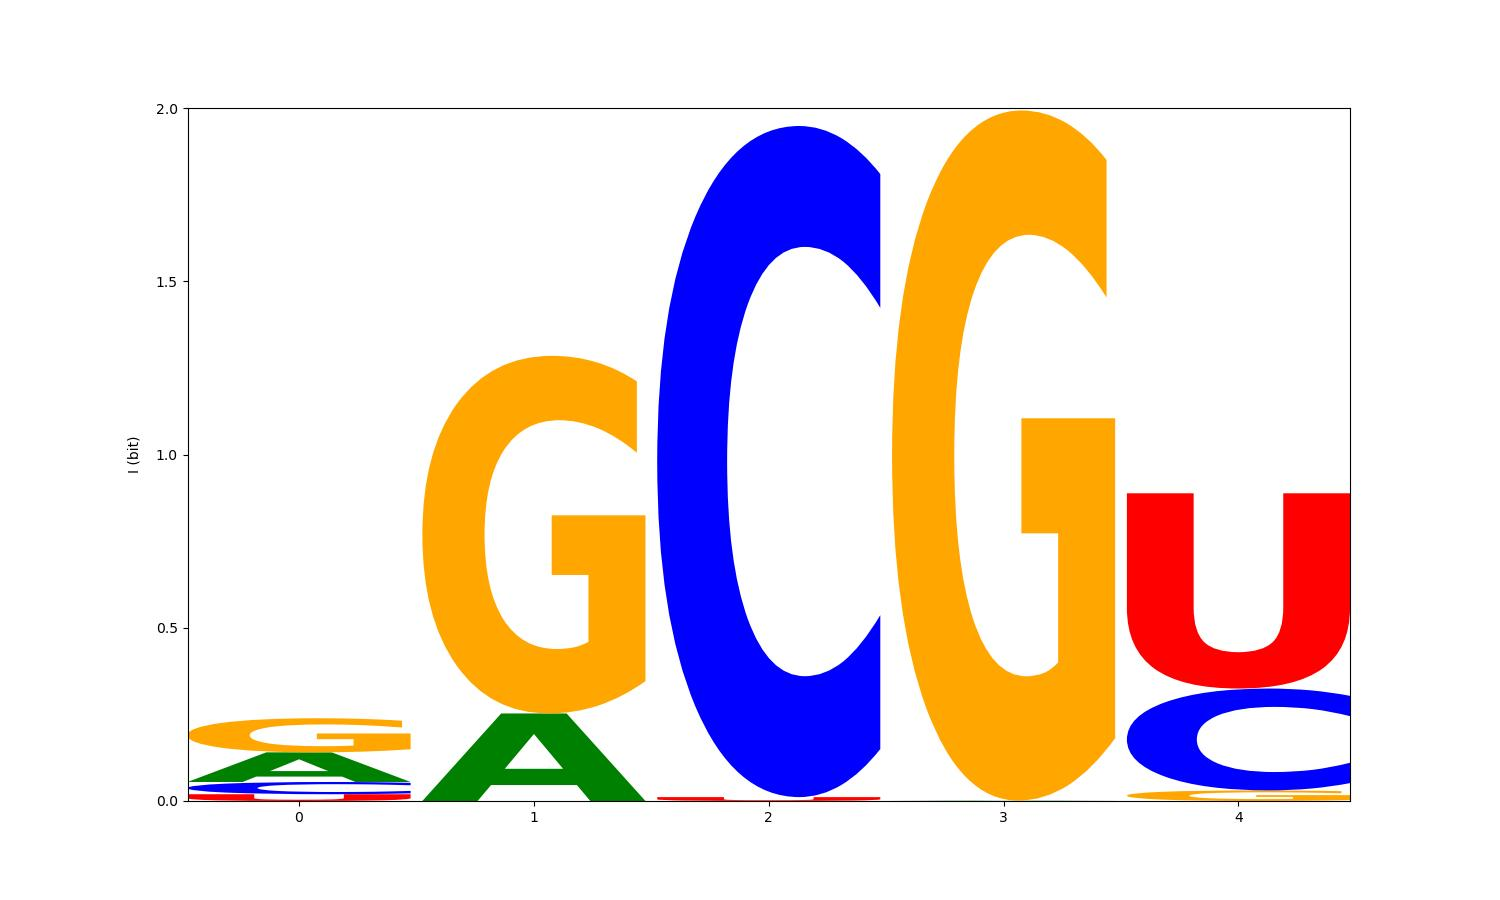

In [15]:
#### Perfrom GridCV Search for exploration of the motif length goal: identify the minimum motif length which gives a good r-value

# optional: allow for global optimization to verify whether the local optimization is good enough
# not recommended include fitG0=True. This option should only be considered when the local optimization is started with an approximate motif and the start parameter is set
# not recommended set time_dissociation. The effect of dissociation should be only considered when the local optimization is started with an approximate motif.


# prepare grid search over motif_length
model_grid=mf.findmotif(protein_conc=PROT_CONC, both_strands=BOTH_STRANDS)
param_grid = {"motif_length": [2,3,4,5,6,7]}     # choose sensible range for length of motif

# define custom refit function
def custom_refit(cv_results):
    """returns index of max r2/sqrt(motif_length)"""
    df_grid=pd.DataFrame(cv_results)
    index=(df_grid['mean_test_score']**2/(df_grid['param_motif_length'].apply(float).apply(np.sqrt))).idxmax()
    return index

# run grid search and refit according to custom refit
grid_search = GridSearchCV(model_grid, param_grid=param_grid, verbose=6, cv=5, refit=custom_refit, n_jobs=-1)

start = time()
grid_search.fit(X_subset, y_subset)

print("I: GridSearchCV took %.2f hours for %d candidate parameter settings."
    % ((time() - start)/3600, len(grid_search.cv_results_["params"])))
print('I: number of samples: %i' %len(X_subset))

df_grid=pd.DataFrame(grid_search.cv_results_)
print('I: Plot of r2 vs motif length and vs root(motif length)')
df_grid.plot(kind='scatter', x='param_motif_length', y='mean_test_score', yerr='std_test_score', figsize=(5,3)).set_xticks(param_grid["motif_length"])
df_grid['r2/sqrt(length)']=df_grid['mean_test_score']/(df_grid['param_motif_length'].apply(float).apply(np.sqrt))
df_grid['std/sqrt(length)']=df_grid['std_test_score']/(df_grid['param_motif_length'].apply(float).apply(np.sqrt))
df_grid.plot(kind='scatter', x='param_motif_length', y='r2/sqrt(length)',yerr='std/sqrt(length)', figsize=(5,3)).set_xticks(param_grid["motif_length"])
plt.show()

best_index=df_grid['r2/sqrt(length)'].idxmax()
CORE_MOTIF_LENGTH=df_grid.loc[best_index, 'param_motif_length']
print(f'I: The maximum ({CORE_MOTIF_LENGTH}) is suggested as CORE_MOTIF_LENGTH')

print('I: motif obtained with the best estimator from gridCV search')
# print & display results from best estimator
model_grid=grid_search.best_estimator_
model_grid.analyse_motif(X_subset,y_subset, THRESHOLD, nuc_type=NUC_TYPE)

# store results and display stages
STAGES.append('best grid', model_grid)
mf.display_df(STAGES.df, nuc_type=NUC_TYPE)

  0%|          | 0/16 [00:00<?, ?engine/s]

single_job:   0%|          | 0/20 [00:00<?, ?tasks/s]

Optimization took 0.32 hours.



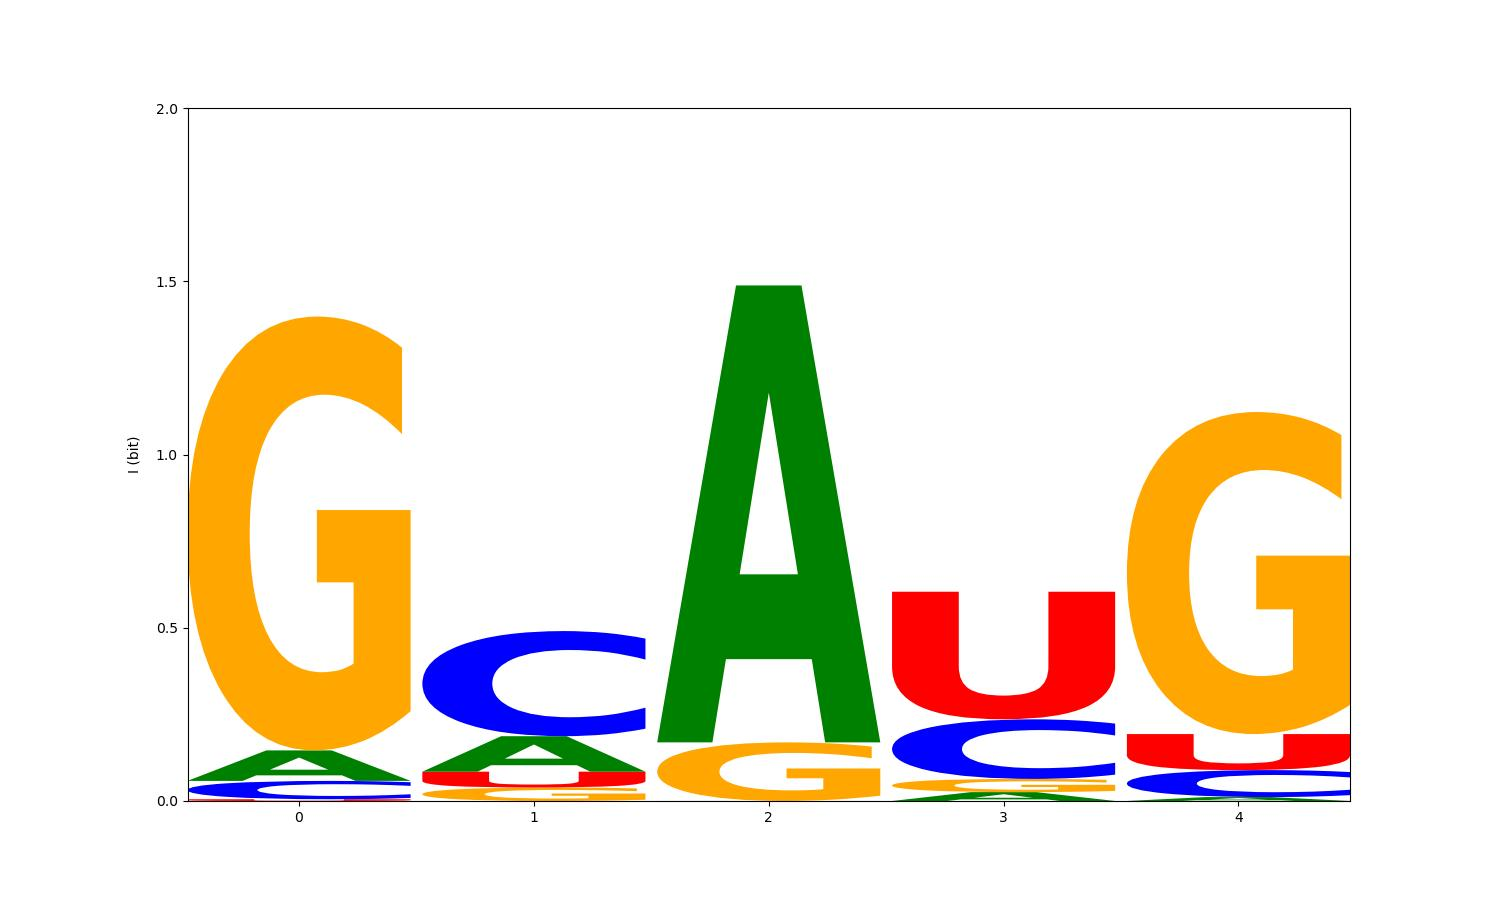
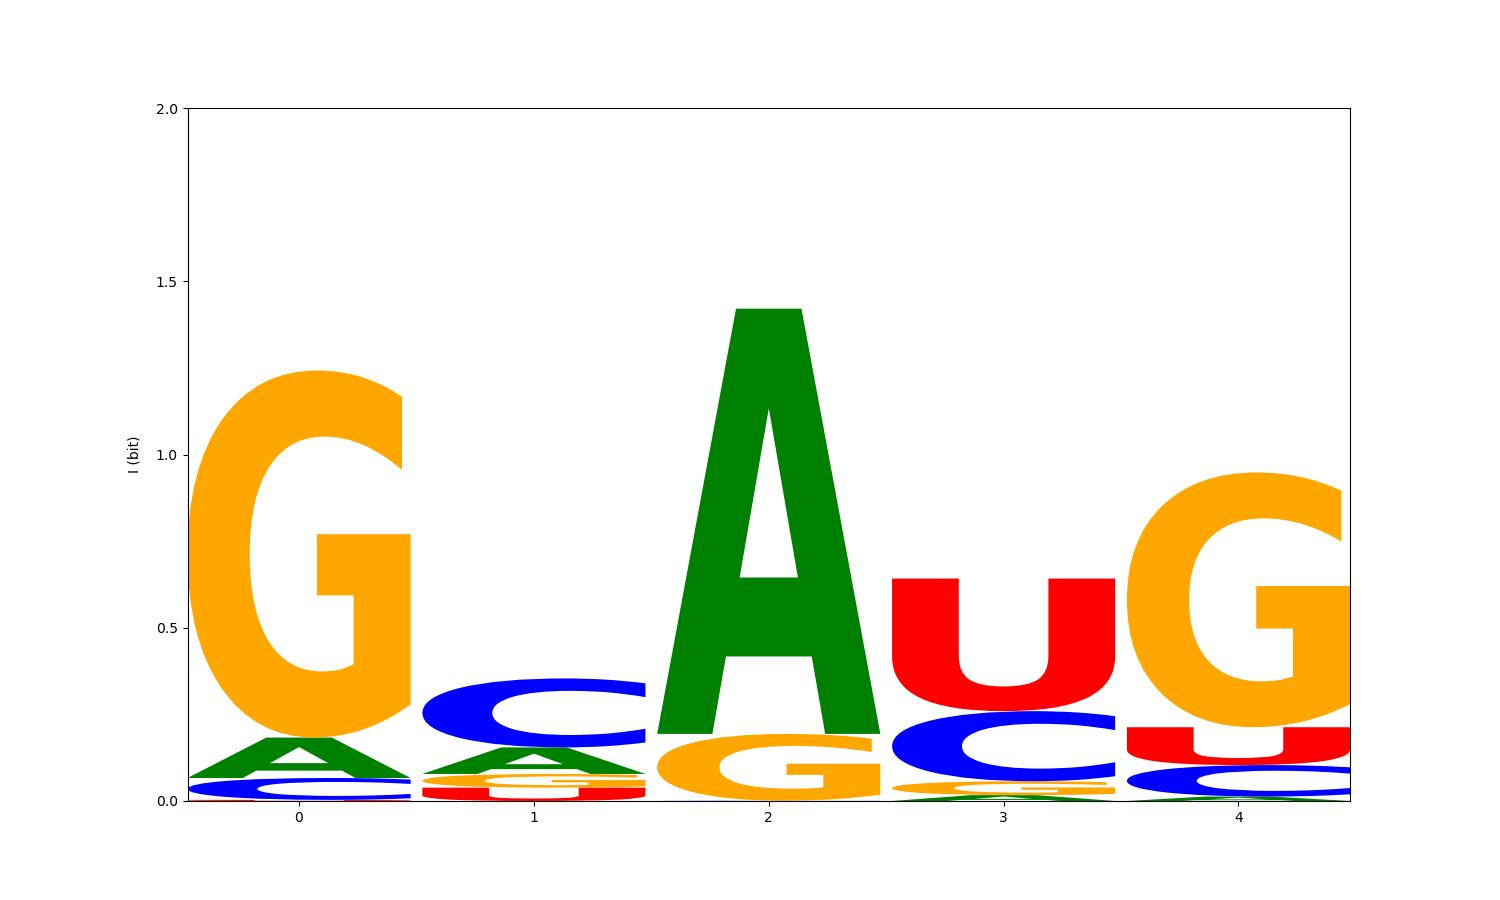
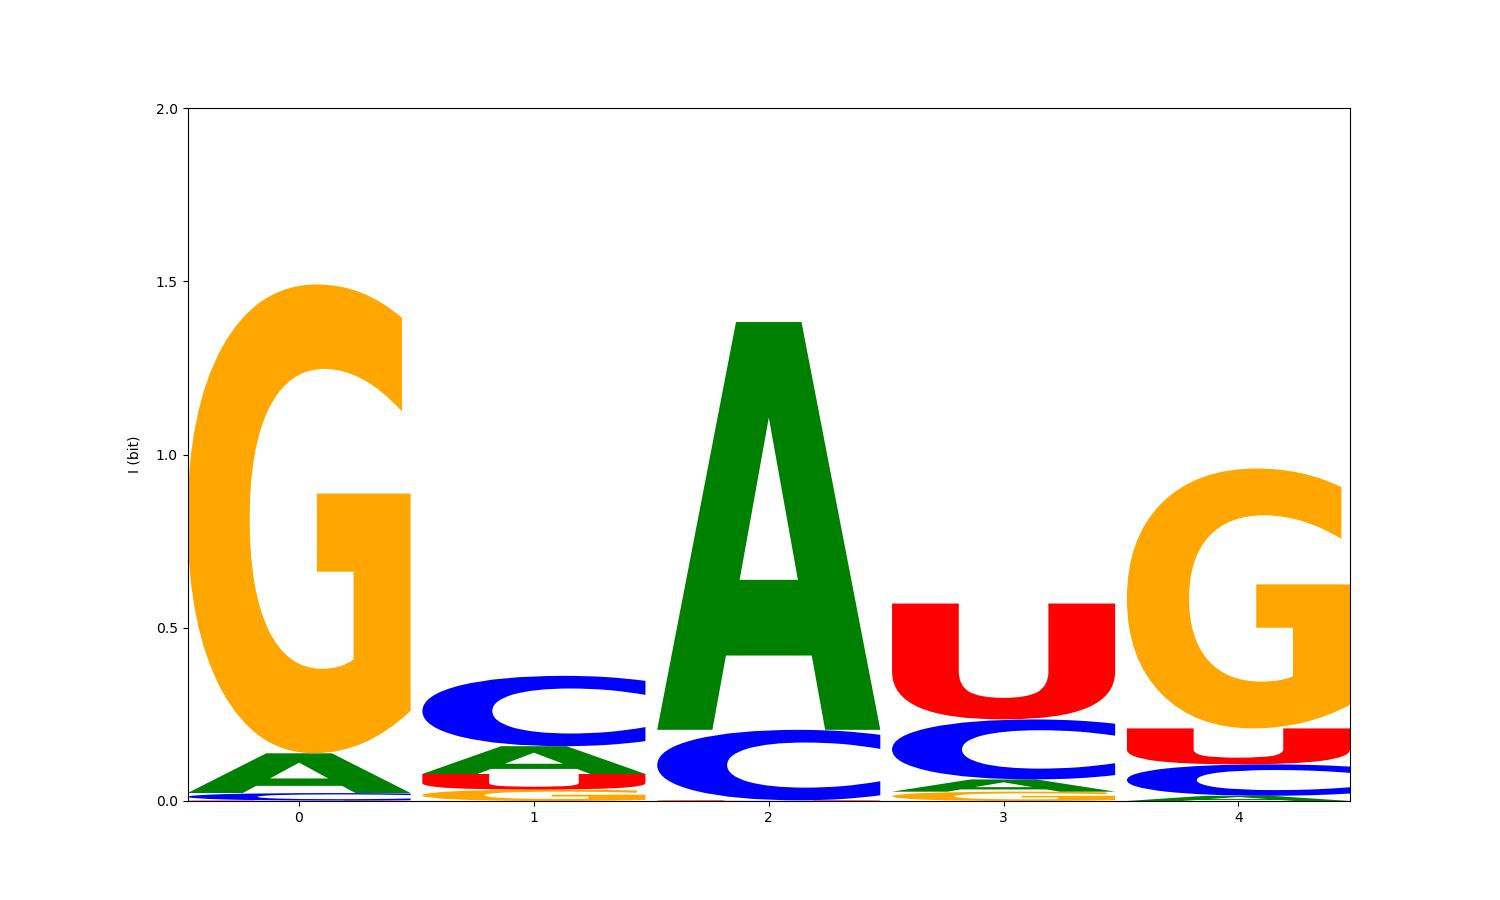
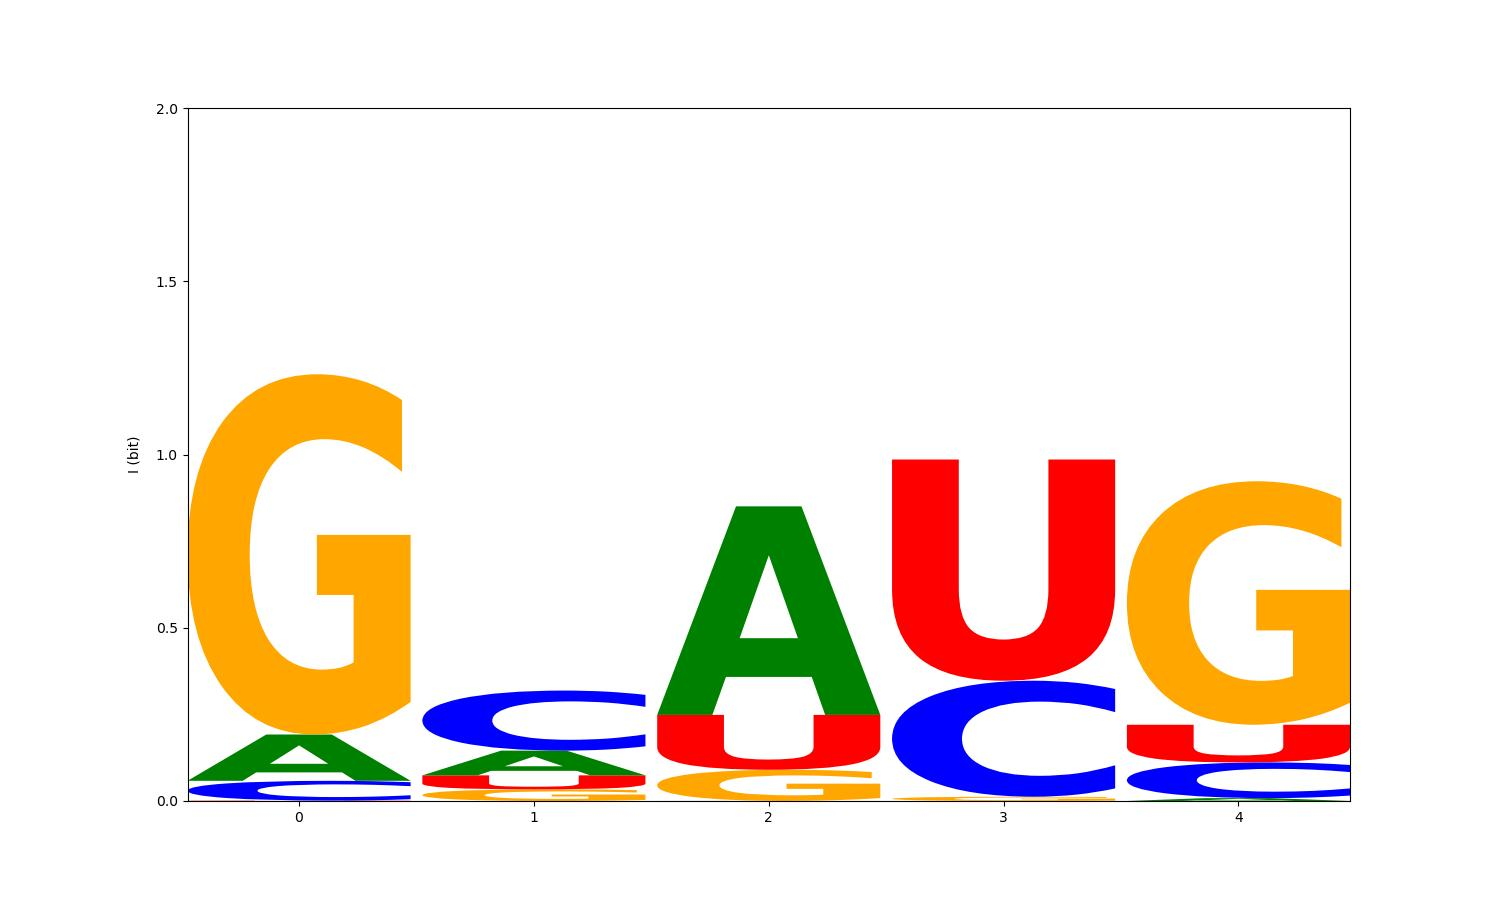
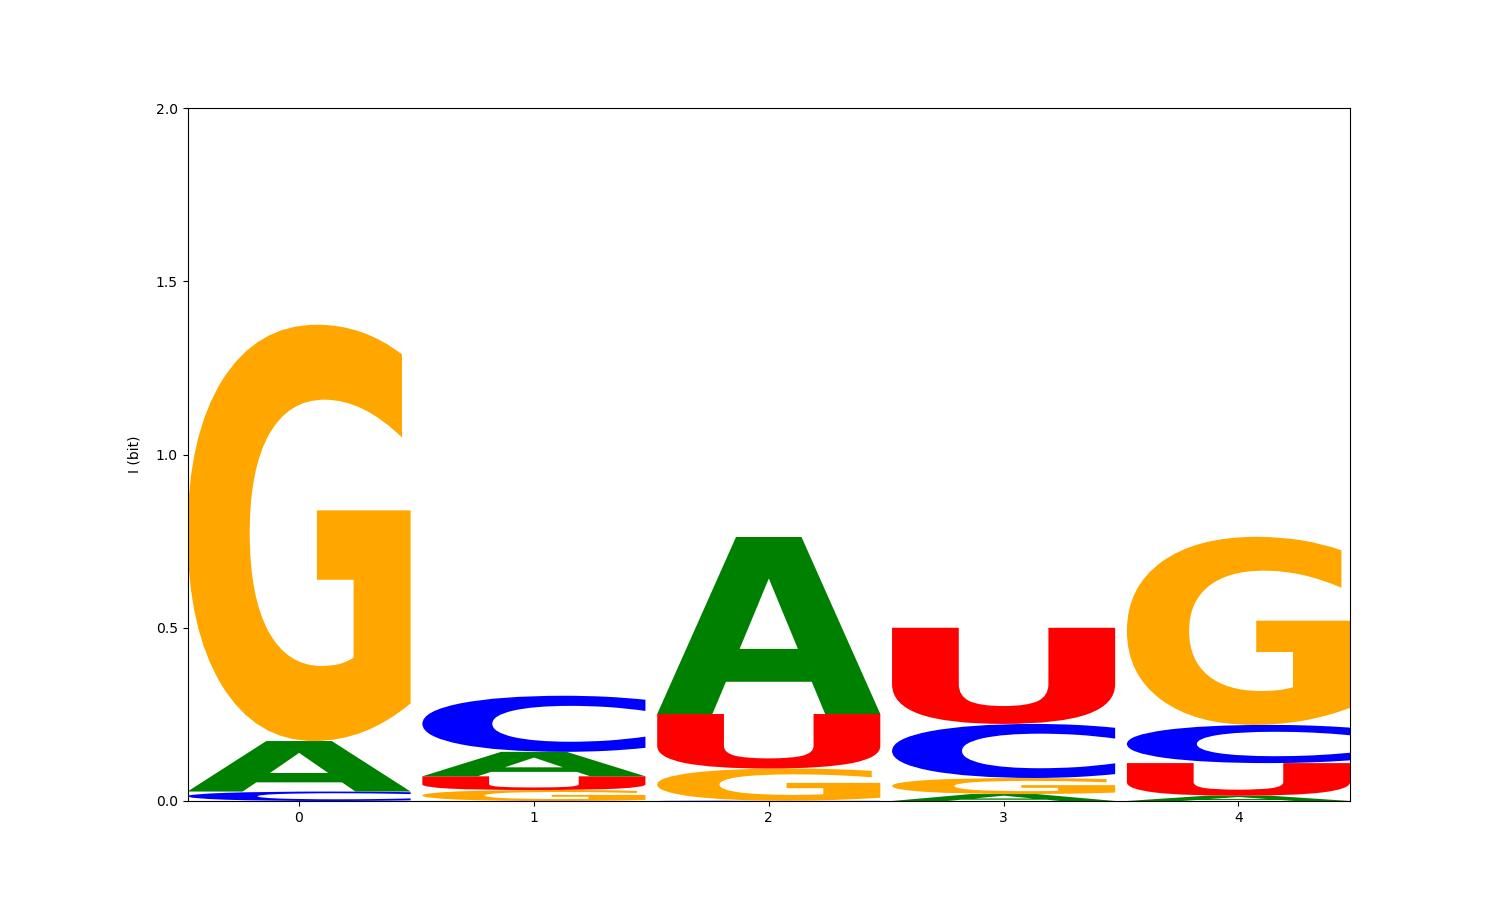
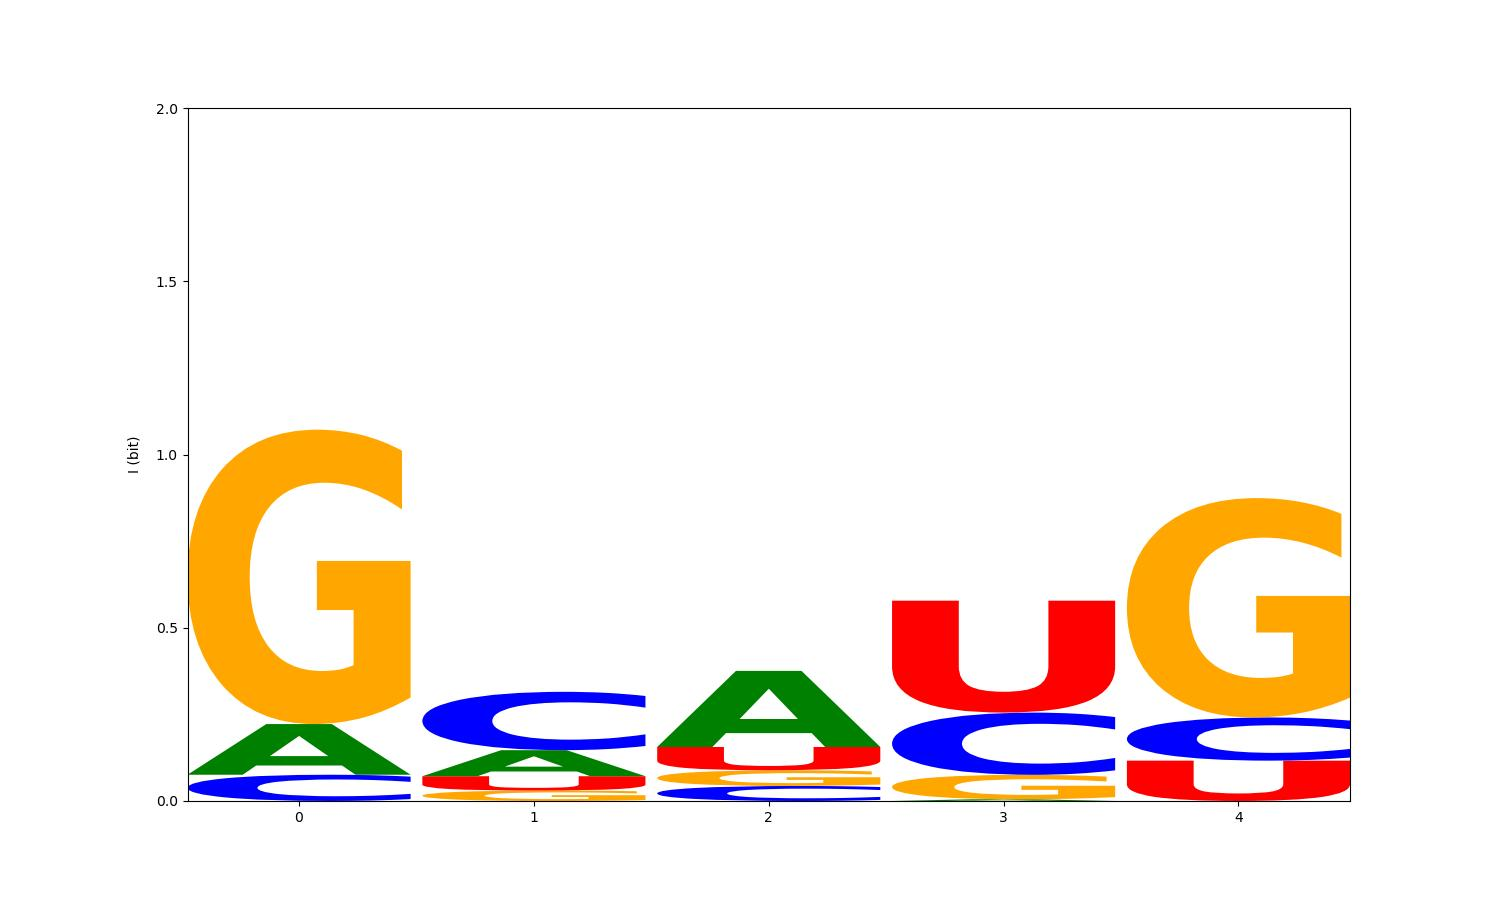
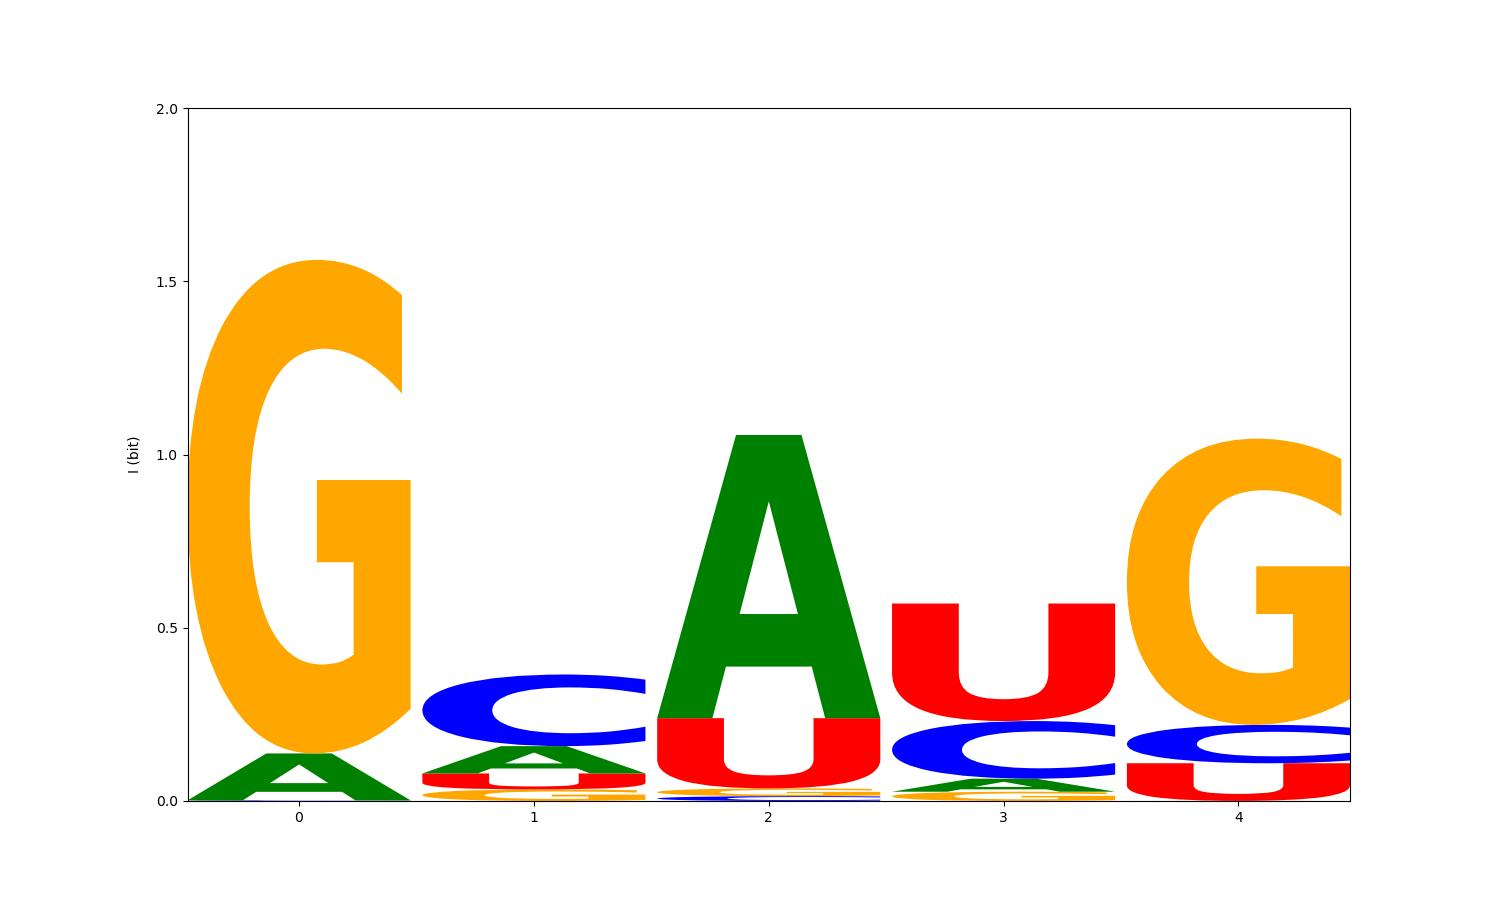
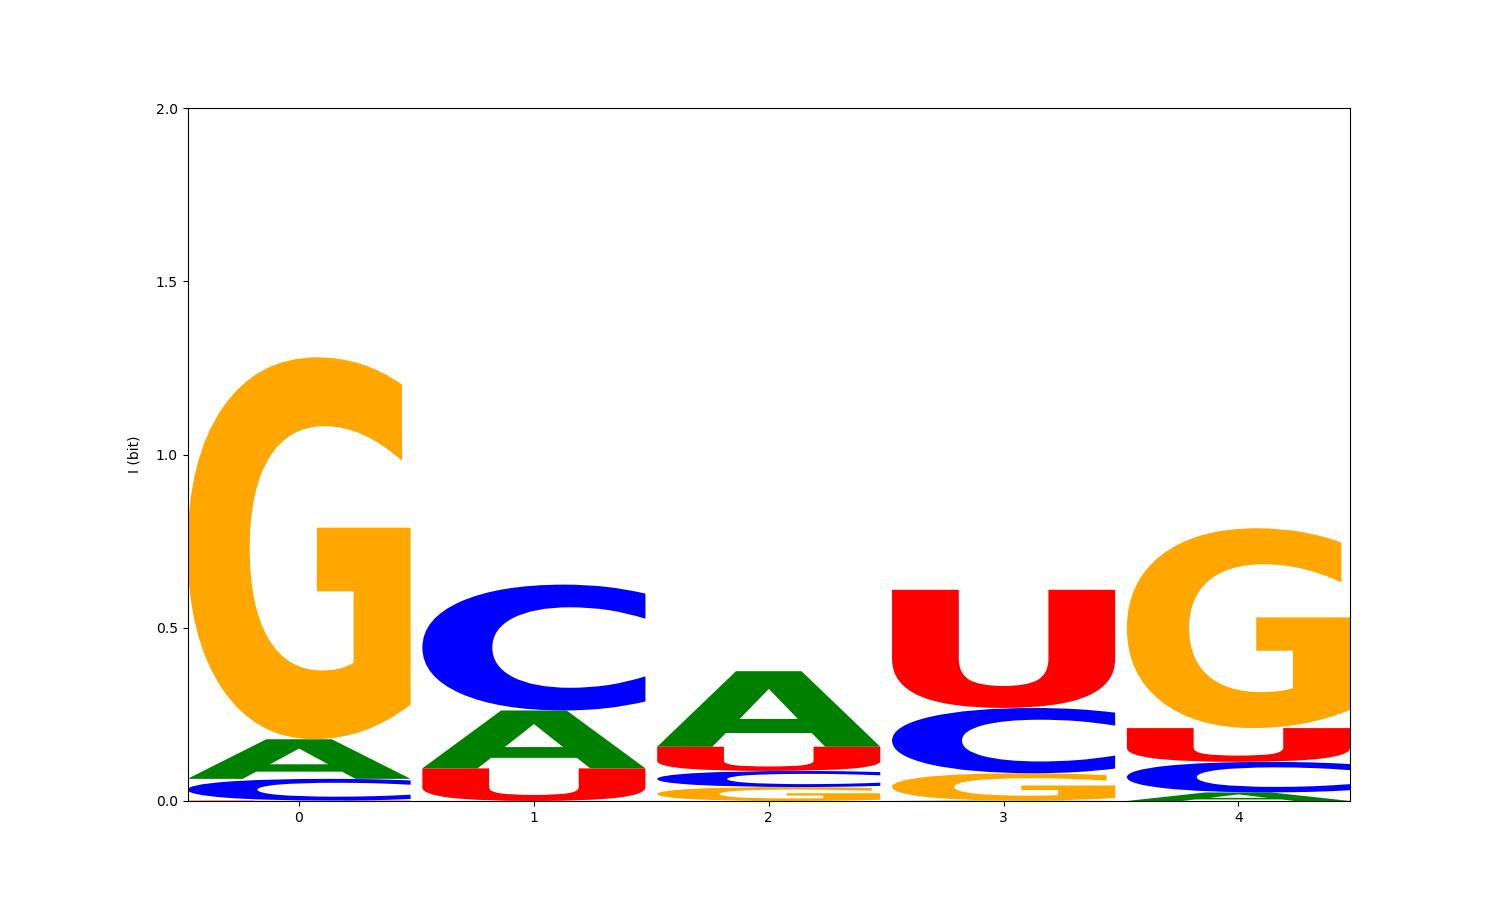
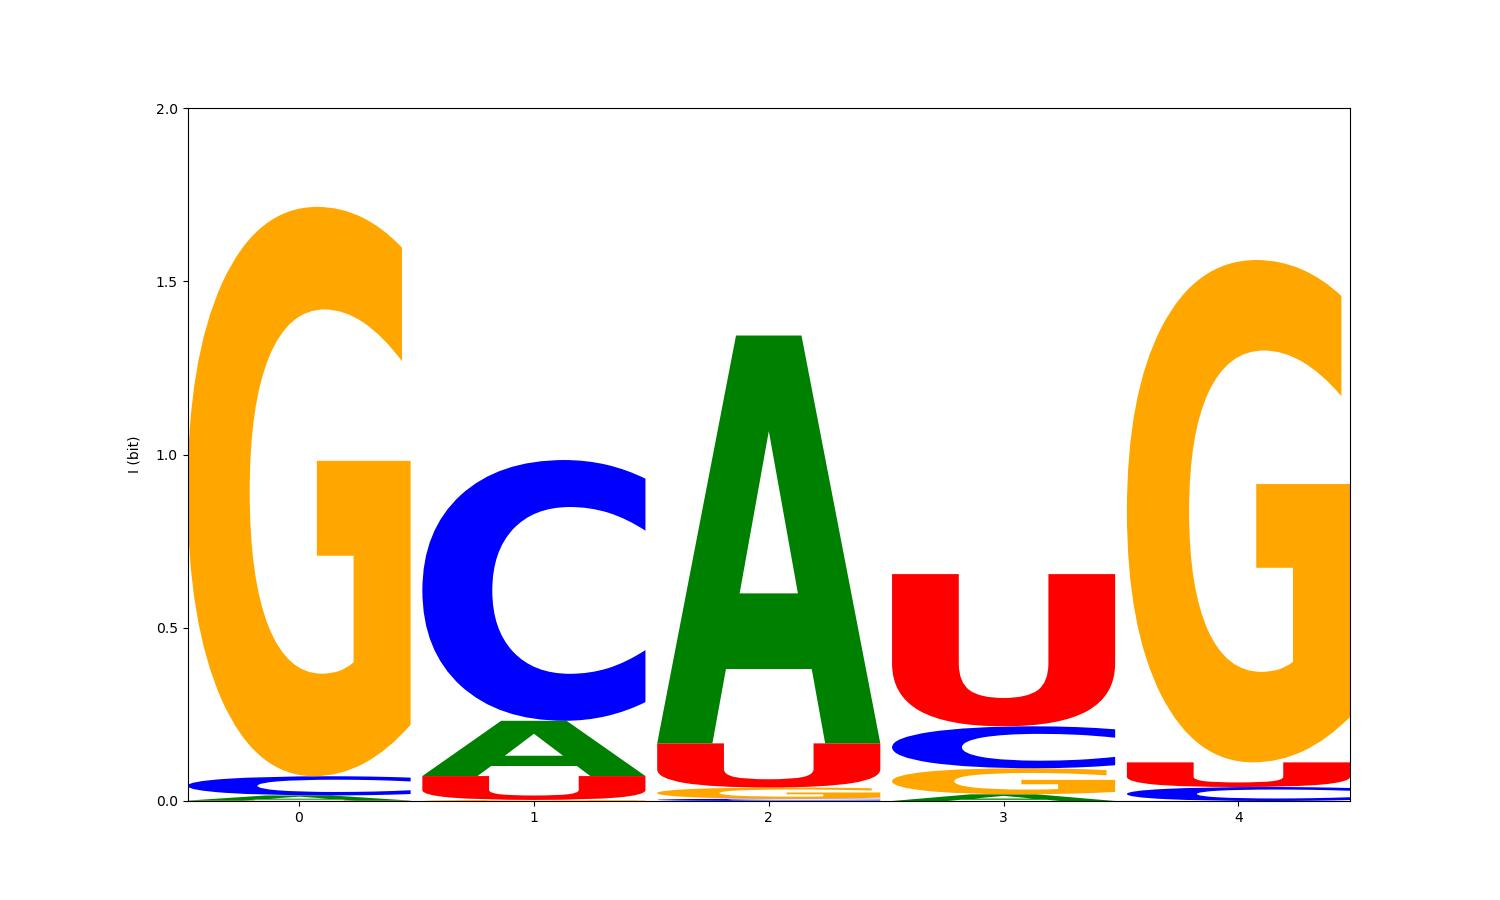
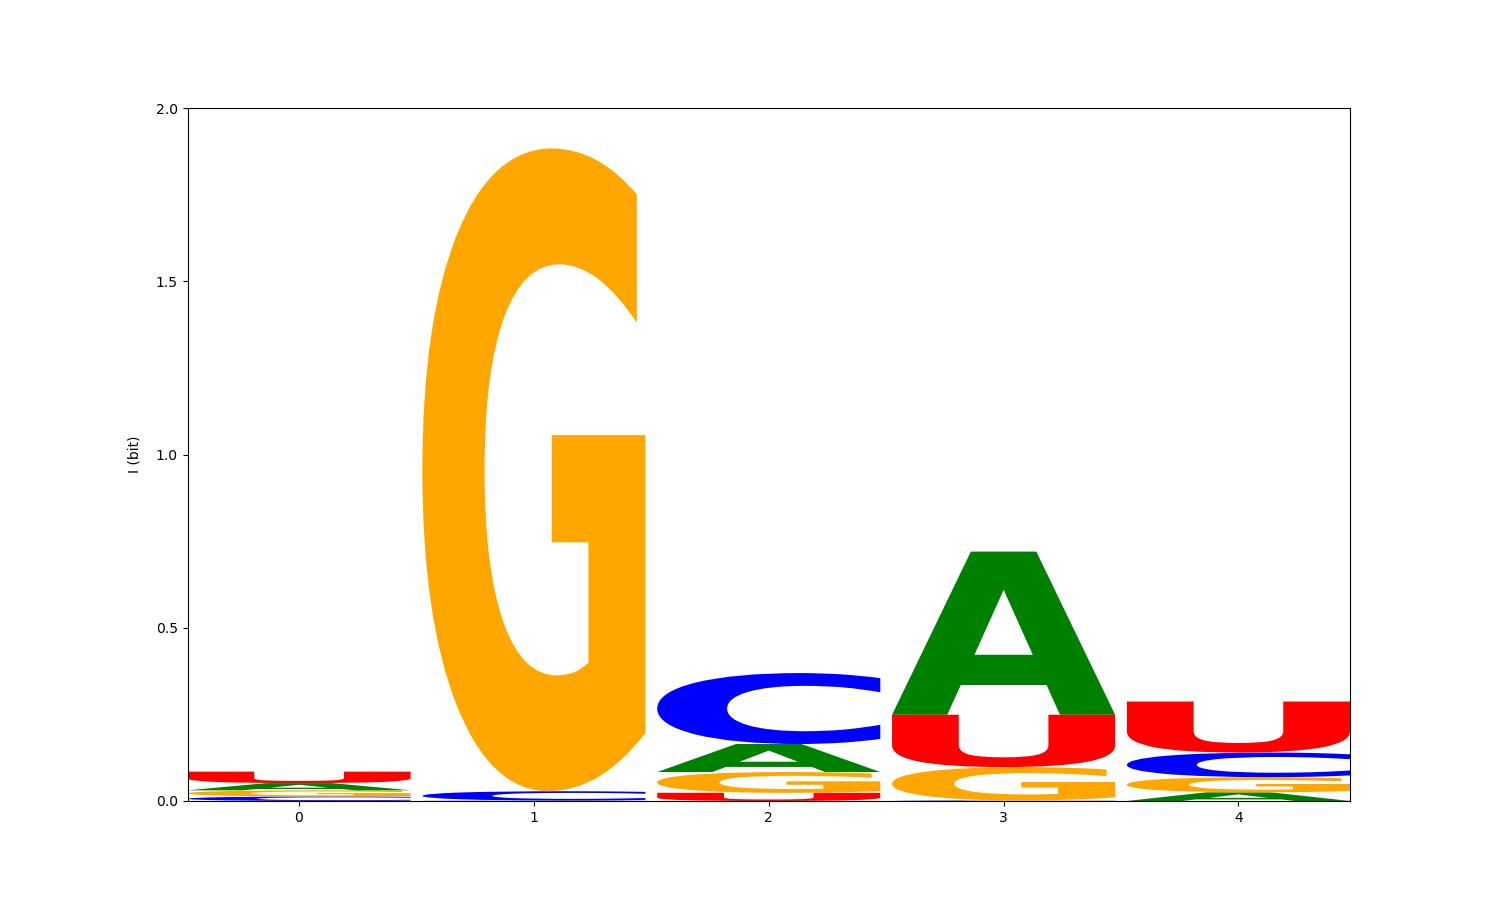
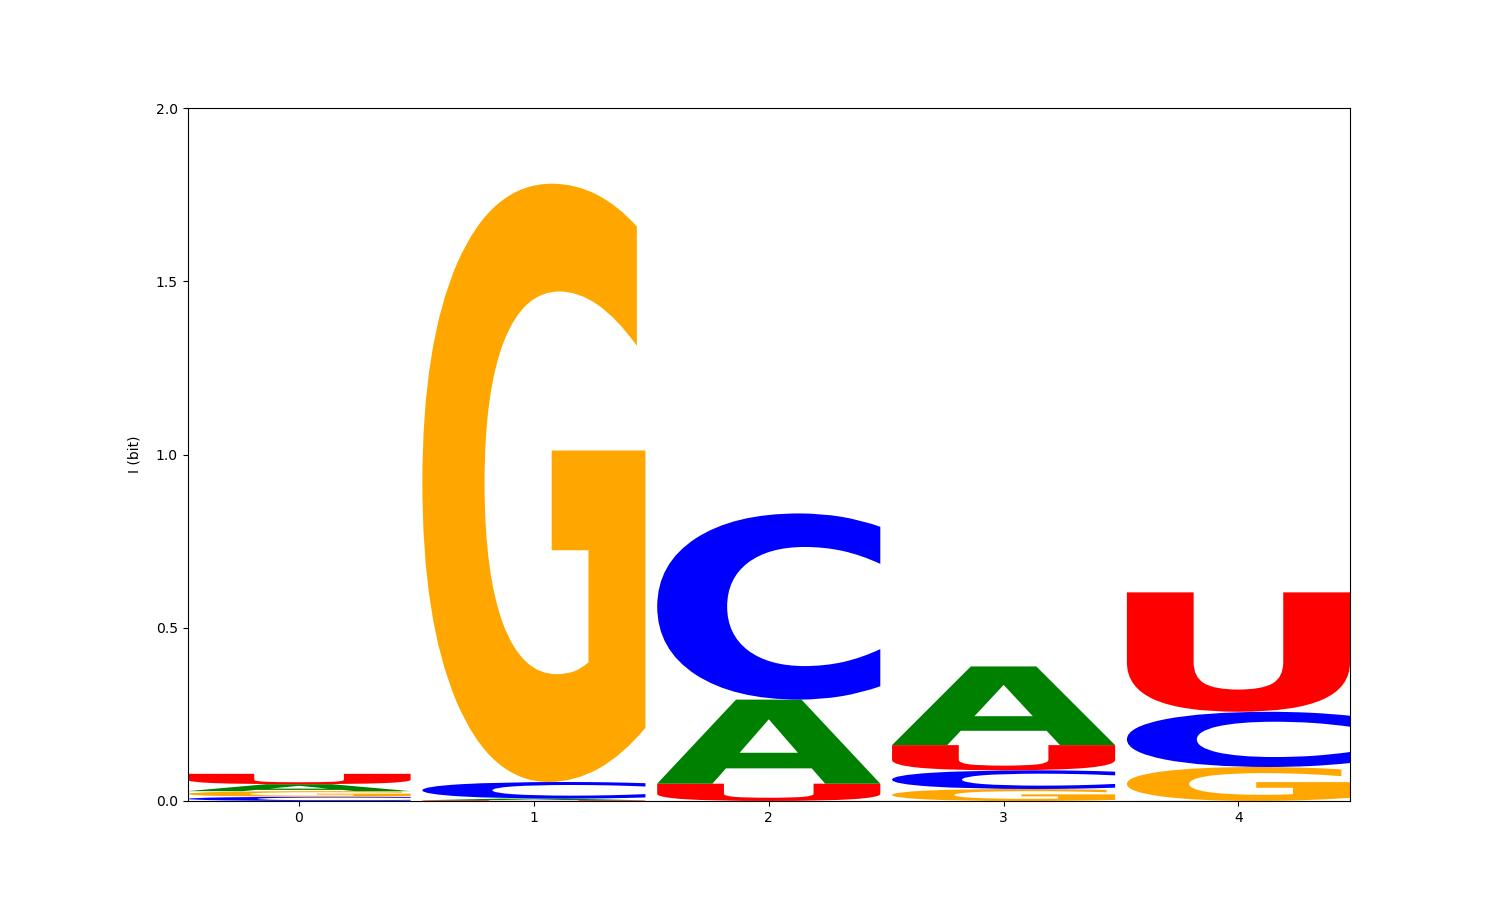
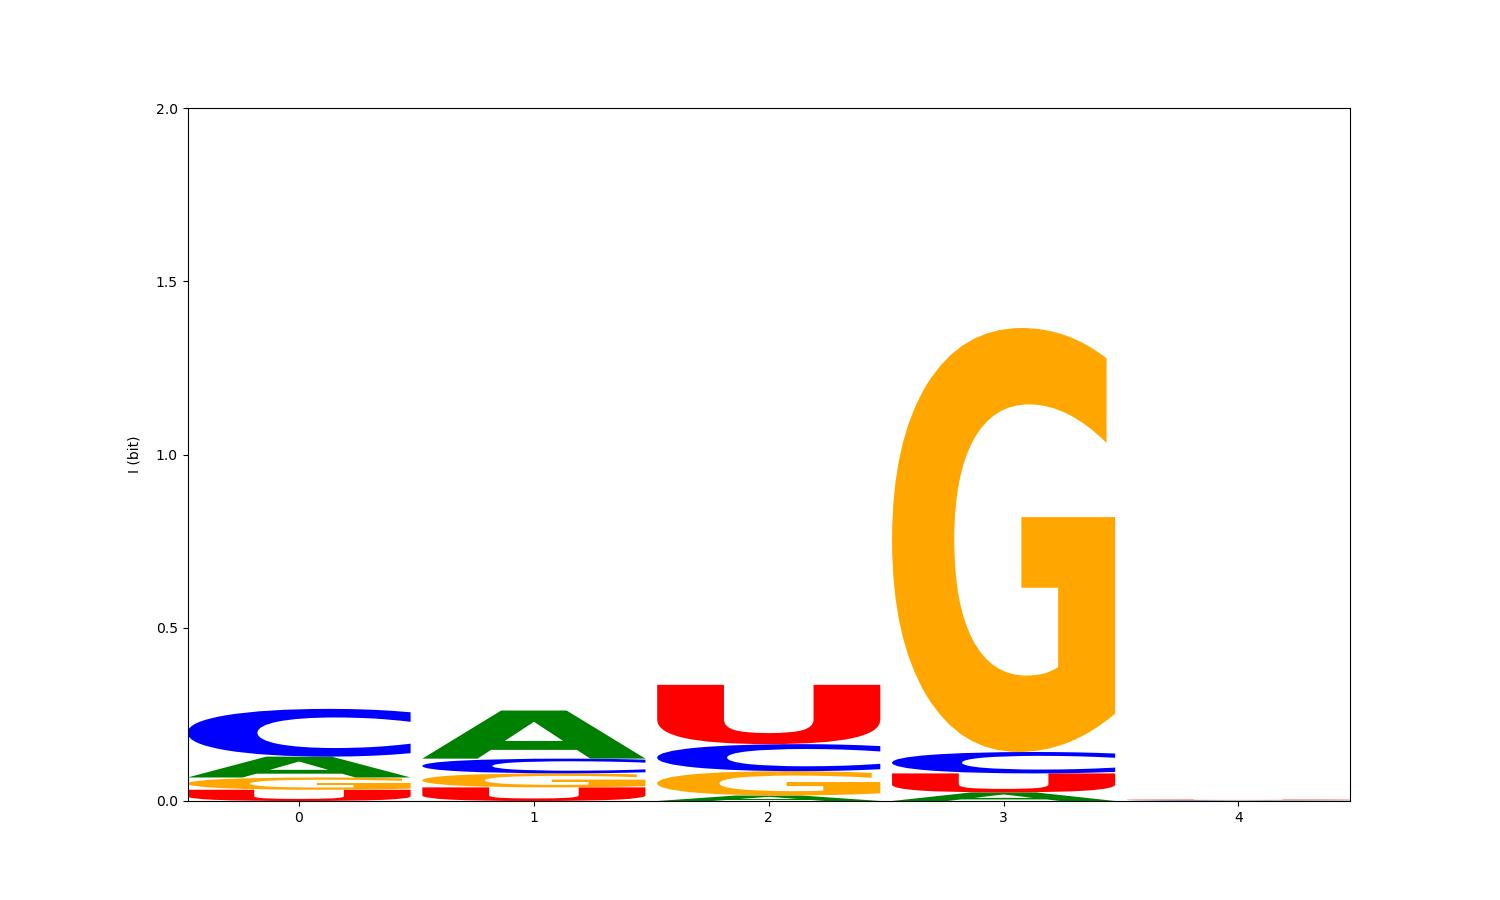
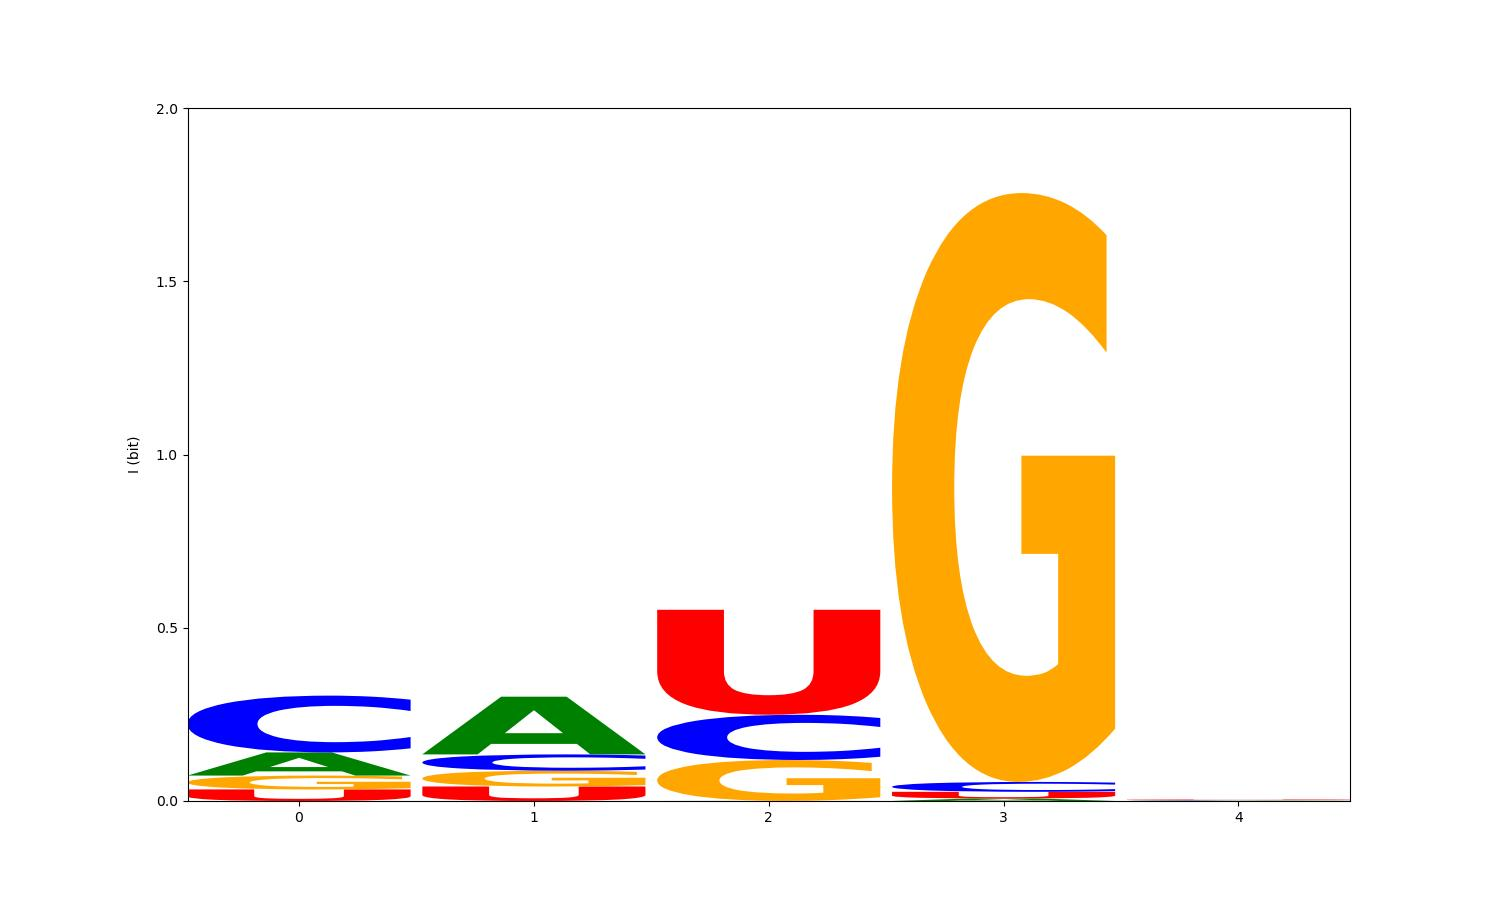
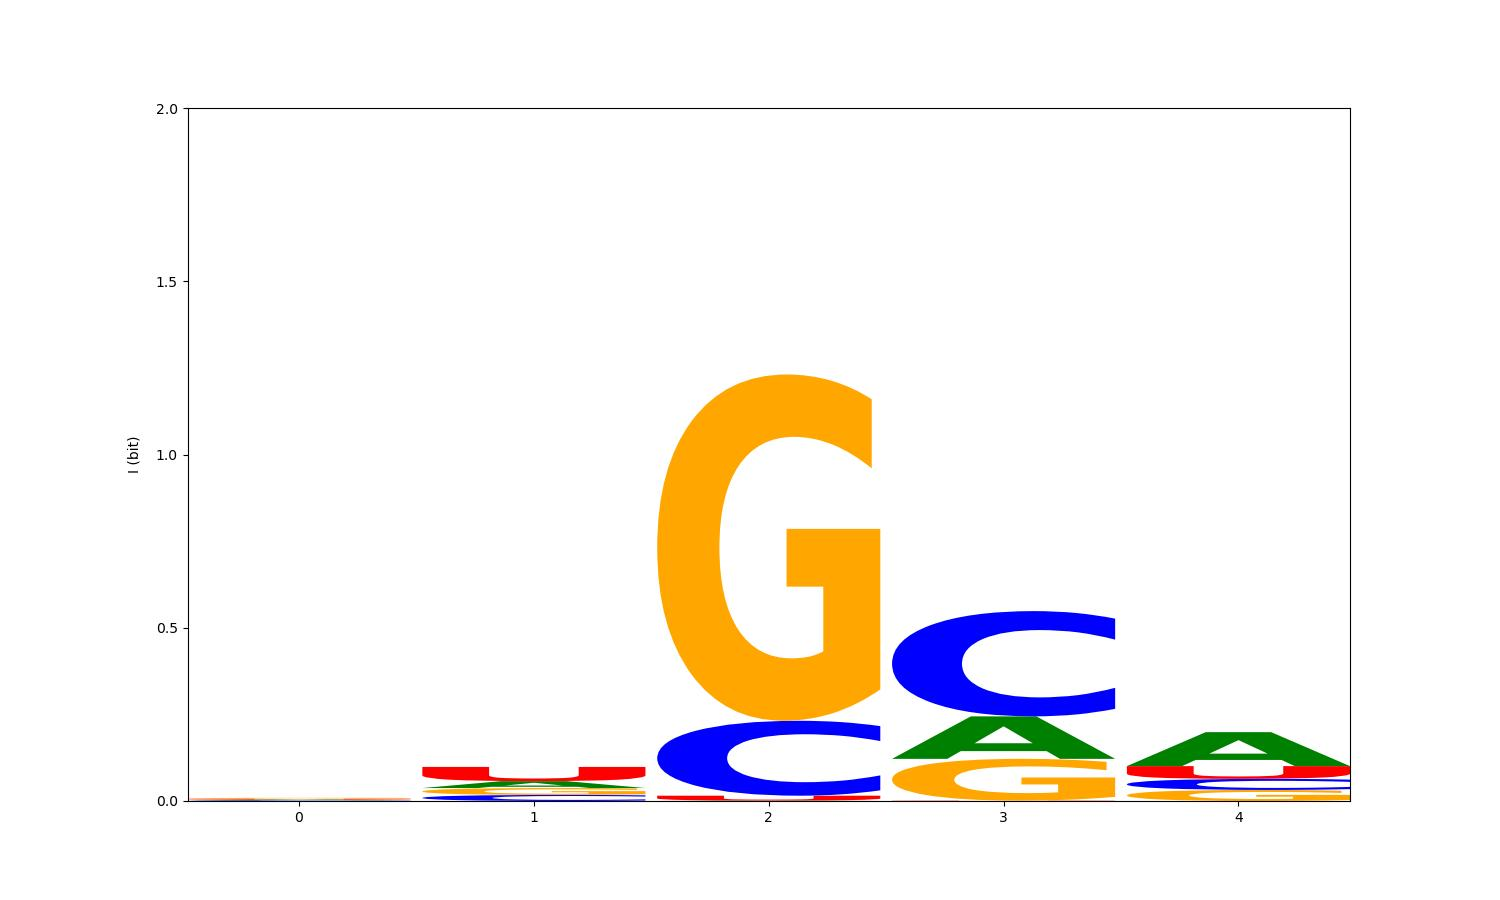
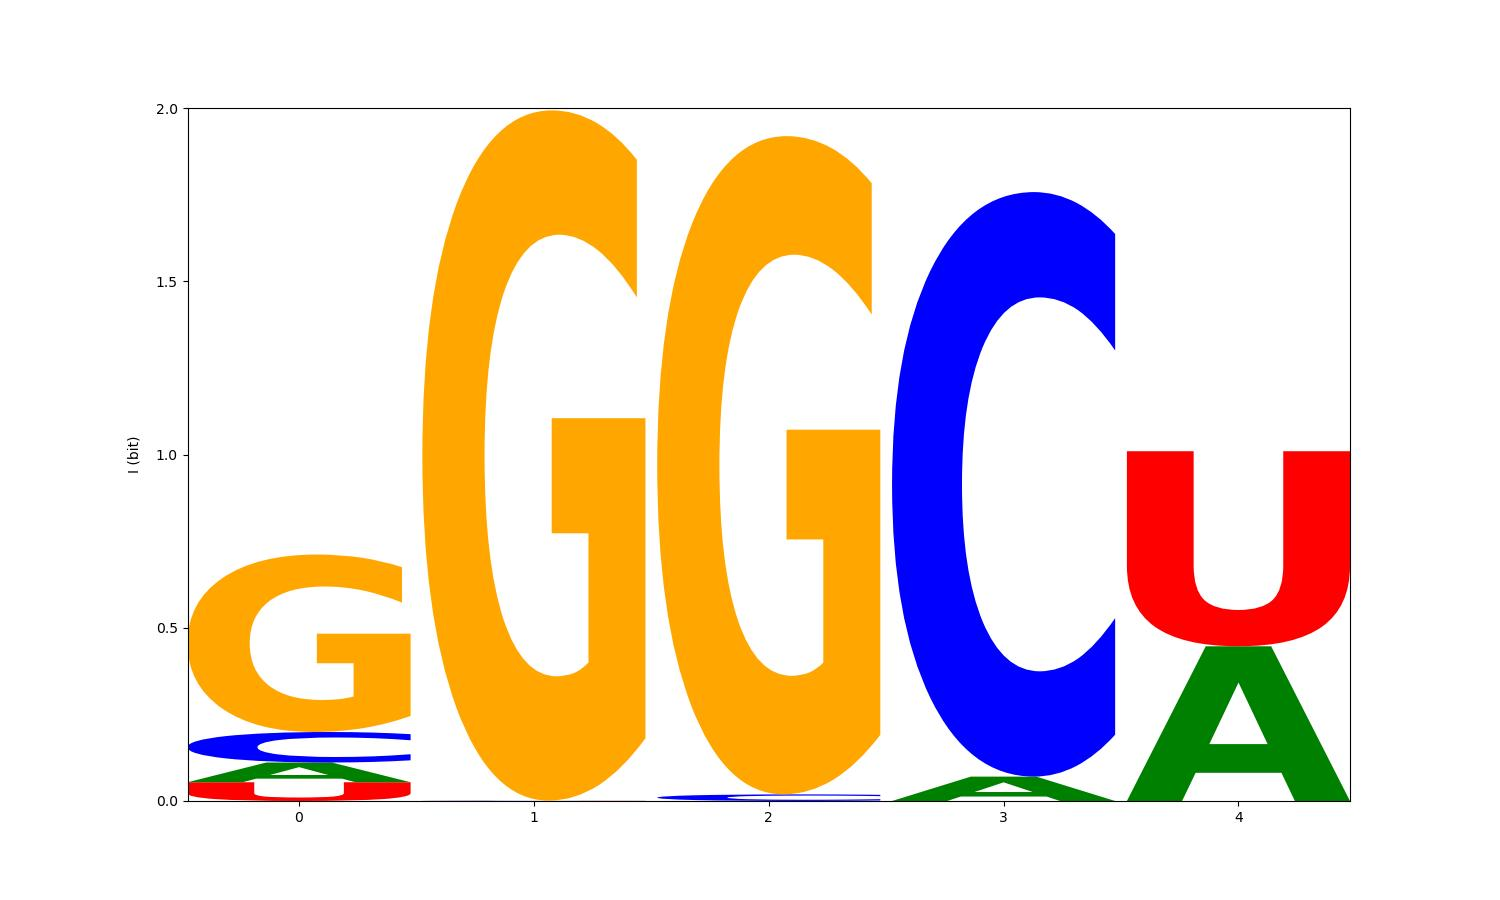
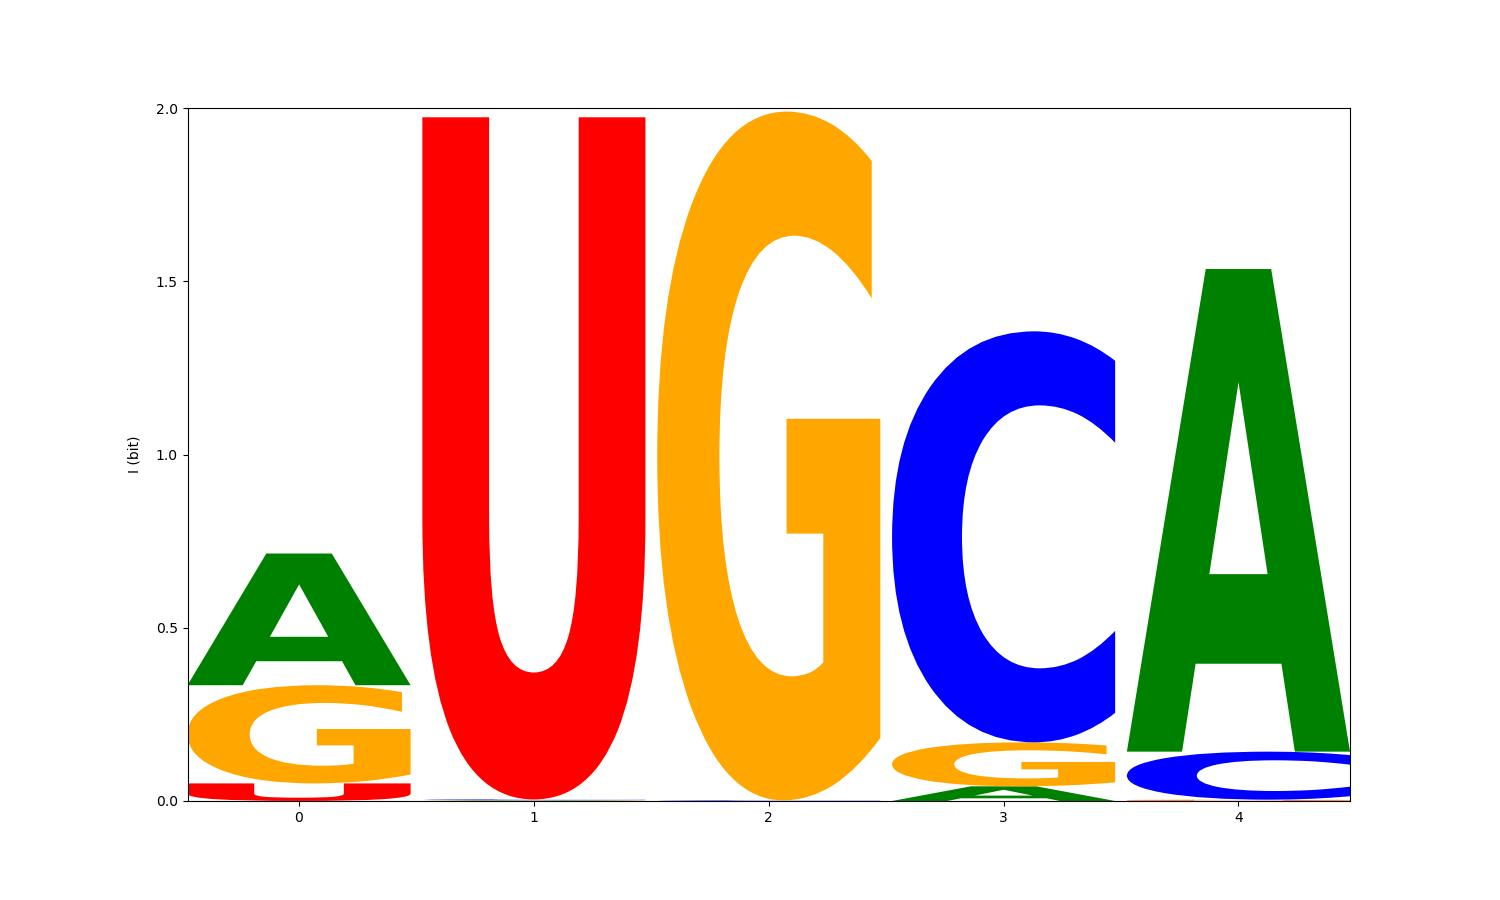
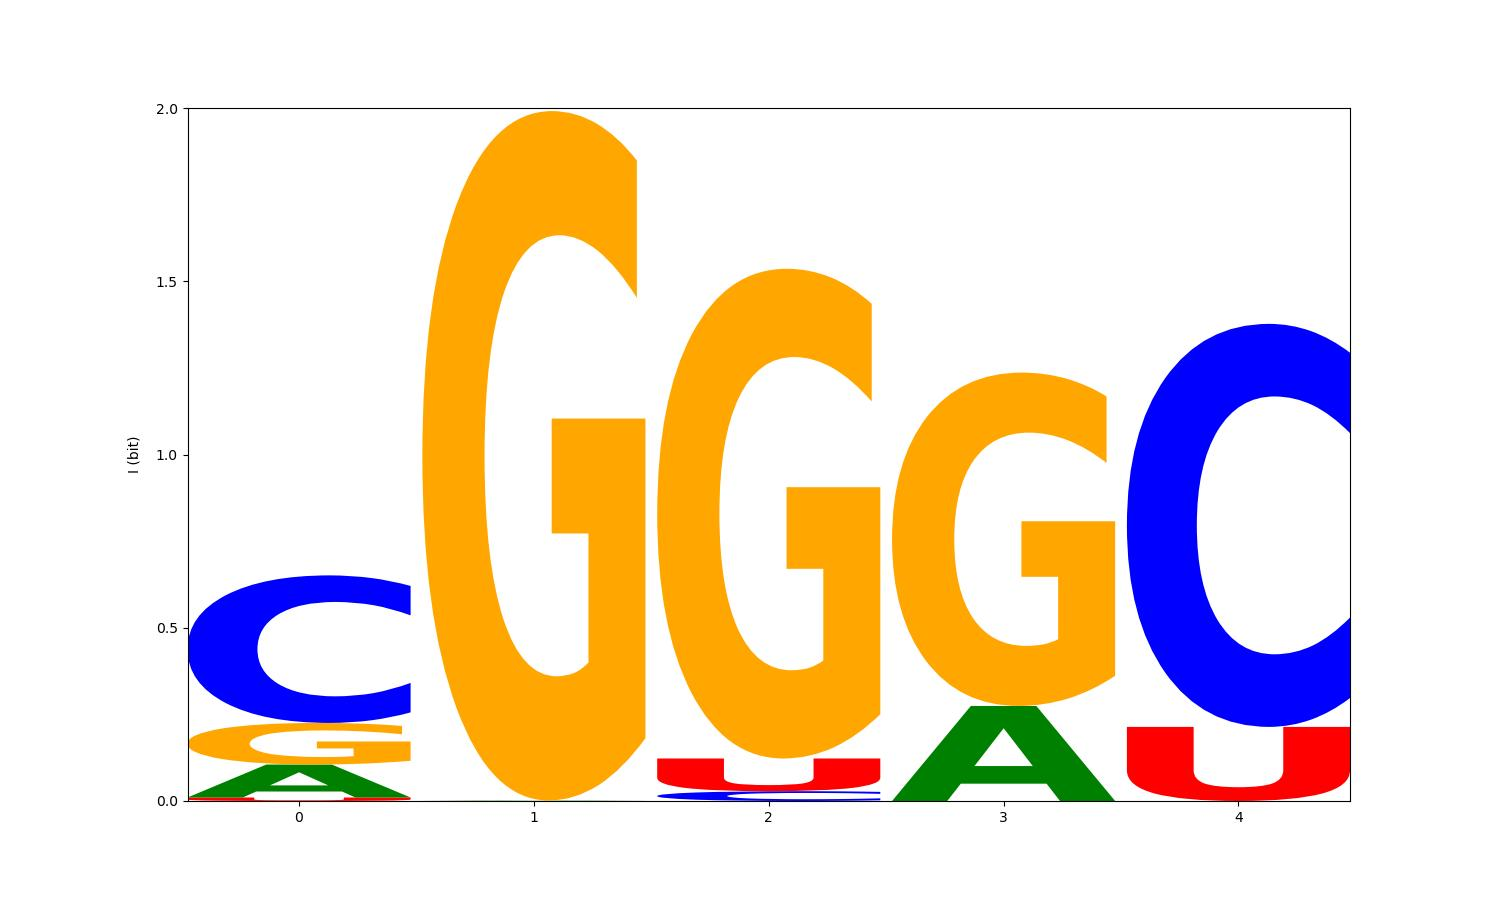
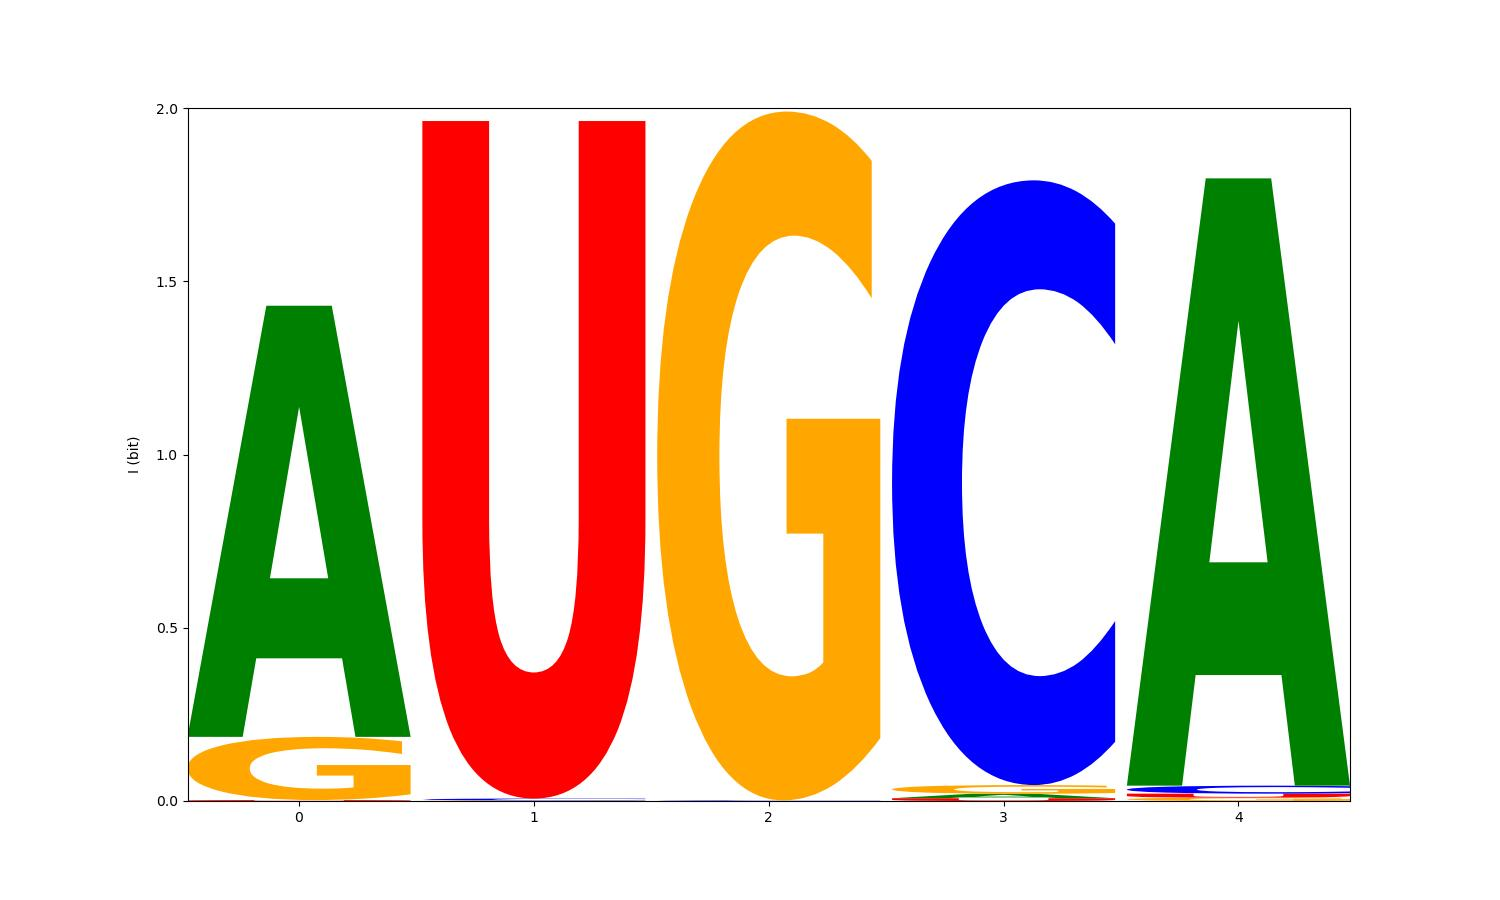
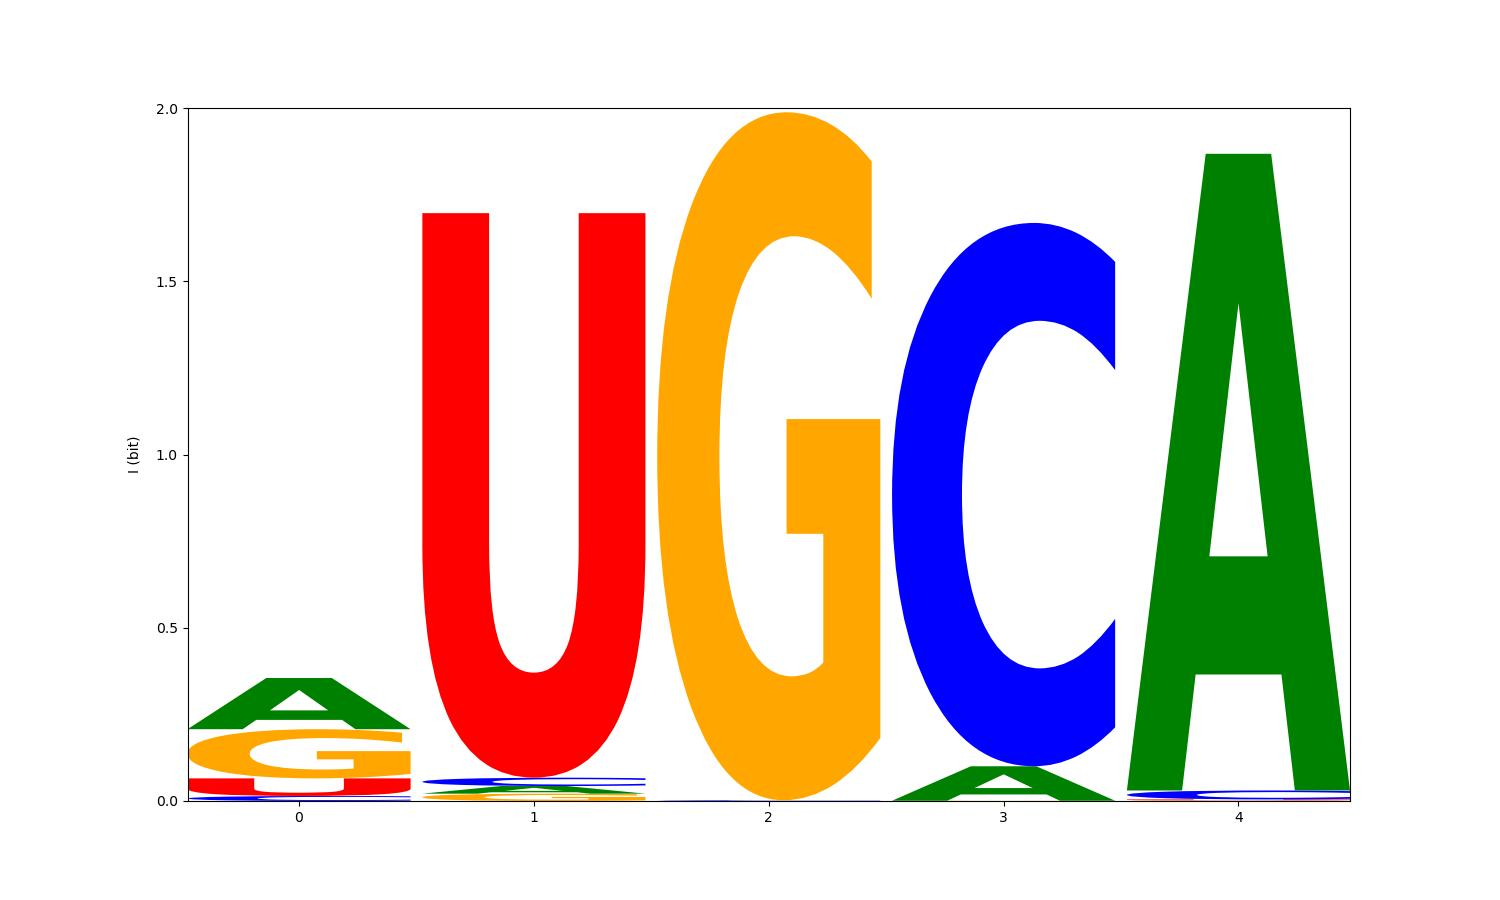
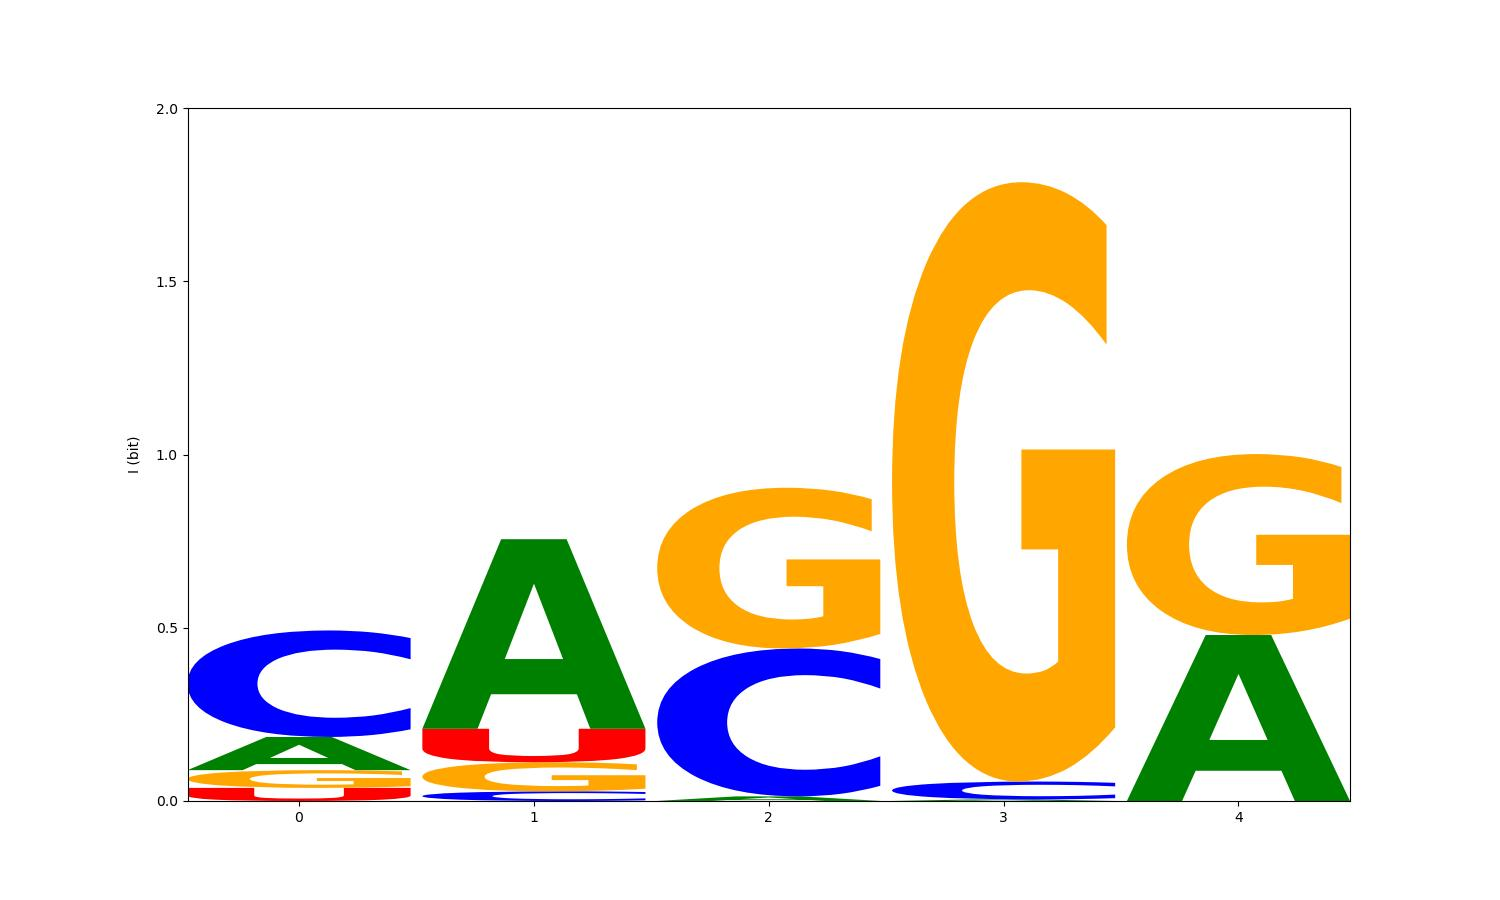

In [16]:
### run a number of identical optimizations with motif length found during grid search
### goal: find best motif through repetition, judge stabiltiy of optimization

#CORE_MOTIF_LENGTH=5  # adjust core motif length if needed, motif length can be changed later

# prepare for ipyparallel
number_of_optimizations = 20
model_list = [mf.findmotif(motif_length=CORE_MOTIF_LENGTH, protein_conc=PROT_CONC, both_strands=BOTH_STRANDS)] * number_of_optimizations
X_list = [X_subset] * number_of_optimizations
y_list = [y_subset] * number_of_optimizations


def single_job(model, X, y):
    model.fit(X, y)
    return {'model':model}

# run the optimizations on ipp.cluster
start = time()
with ipp.Cluster(log_level=40) as rc:
    rc[:].use_pickle()
    view = rc.load_balanced_view()
    asyncresult = view.map_async(single_job, model_list, X_list, y_list)
    asyncresult.wait_interactive()
    result = asyncresult.get()
print("I: Optimization took %.2f hours." % ((time() - start) / 3600))


  
# assemble results and analyze
df_repetitions=pd.DataFrame(result)
df_repetitions['r (subset)']=df_repetitions['model'].apply(lambda e: e.rvalue)
df_repetitions['r (train)']=df_repetitions['model'].apply(lambda e: mf.linregress(e.predict(X_train),y_train).rvalue)
df_repetitions['r (test)']=df_repetitions['model'].apply(lambda e: mf.linregress(e.predict(X_test),y_test).rvalue)
df_repetitions['G0']=df_repetitions['model'].apply(lambda e: e.finalG0_)
df_repetitions['max binding']=df_repetitions['model'].apply(lambda e: max(e.binding))
df_repetitions['min binding']=df_repetitions['model'].apply(lambda e: min(e.binding))
df_repetitions['ratio'] = df_repetitions['max binding'] / df_repetitions['min binding']
df_repetitions['energies']=df_repetitions['model'].apply(lambda e: e.energies_)
#df_repetitions['information']=df_repetitions['model'].apply(lambda e: mf.energies2information(e.energies_))


# display results of the ensemble of optimizations
df_repetitions.sort_values('r (train)', ascending=False, inplace=True)
mf.display_df(df_repetitions, nuc_type=NUC_TYPE)
print('I: Results of the repeated motif finding, sorted according to the regression coefficient with the train dataset')

I: Histogram of the regression coefficients r obtained by repeated optimizaion.


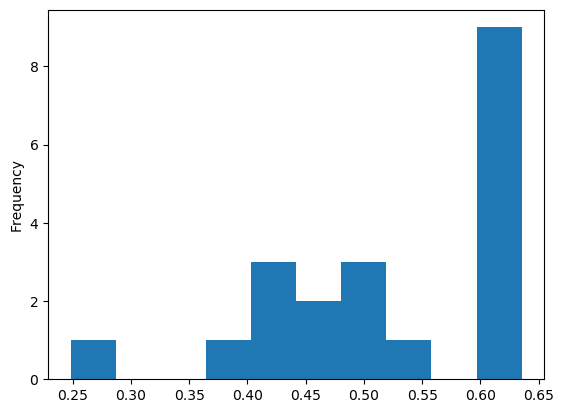

I: 2-dimensional PCA explained 60 % of variance.
I: Visualization of the PCA with the regression quality vs. subset and training dataset by color.


/home/GLipps/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


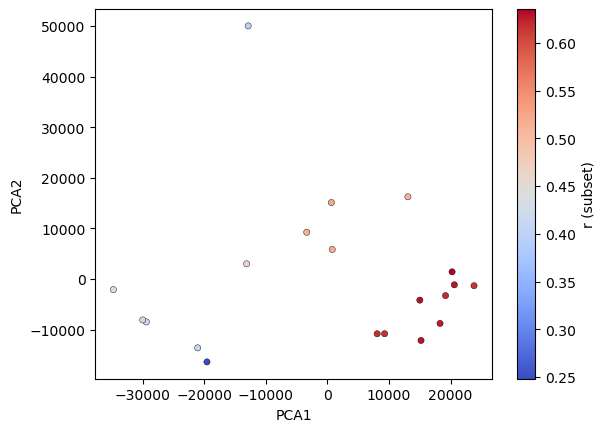

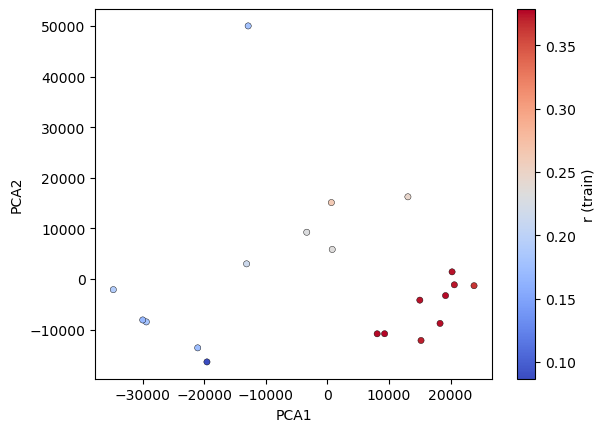

In [17]:
### compare energy matrices of ensemble using PCA
print('I: Histogram of the regression coefficients r obtained by repeated optimizaion with the subset.')
df_repetitions['r (subset)'].plot(kind='hist')
plt.show()

pca=PCA(n_components=2)  # perform 2-dimensional PCA of energy matrices                
pca_2c=pca.fit_transform(df_repetitions['energies'].tolist())    
df_repetitions[['PCA1', 'PCA2']]=pca_2c
print('I: 2-dimensional PCA explained %i %% of variance.' %(sum(pca.explained_variance_ratio_)*100))
if sum(pca.explained_variance_ratio_)<0.5:
      print('W: 2-dimensional PCA explained only %i %% of variance' %(sum(pca.explained_variance_ratio_)*100))

print('I: Visualization of the PCA with the regression quality vs. subset and training dataset by color.')        
df_repetitions.plot(x='PCA1', y='PCA2', kind='scatter', c='r (subset)',cmap=cm.coolwarm, edgecolors='black', linewidths=0.3)
df_repetitions.plot(x='PCA1', y='PCA2', kind='scatter', c='r (train)',cmap=cm.coolwarm, edgecolors='black', linewidths=0.3)

I: Best motif according to r (train) from the repeated optimizations.
I: energy matrix and logos:



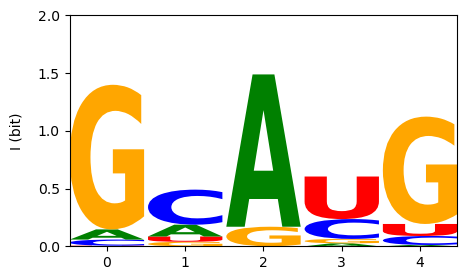

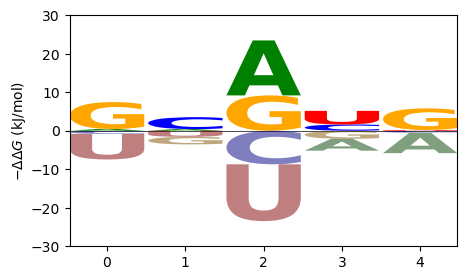


        A     C     G      U
0   -441   817 -7016   6640
1   -424 -3115  1968   1572
2 -14276  8711 -9189  14754
3   3077 -1641  2089  -3526
4   5294   521 -5620   -196

I: summed absolute energies of each position:
0    14915
1     7081
2    46931
3    10334
4    11632
dtype: int64

I: averaged summed energy over all positions: 18179
I: Mean and Standard Deviation for the Free Energy G to all subsequences of all probes: -14949 +/- 13683
I: Plot of the Occupancy of a subsite as the function of the Free Energy G 
   overlaid with the distribution of the Free Energy of all subsites.
I: There shall be only a small overlap of both curves. i.e. only the most negative Free Energies
    lead to a measurable occupancy.


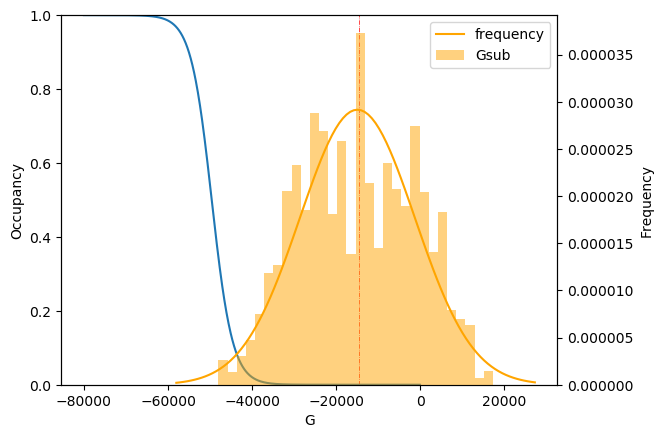

I: Calculated occupancy over all subsite of a single probe:
   binding:  0.00020 .. 0.76617 (ratio: 1228.8)
I: number of probes: 1000
I: Pearson Correlation  r: 0.6174
I: mean absolute error: 10.9255


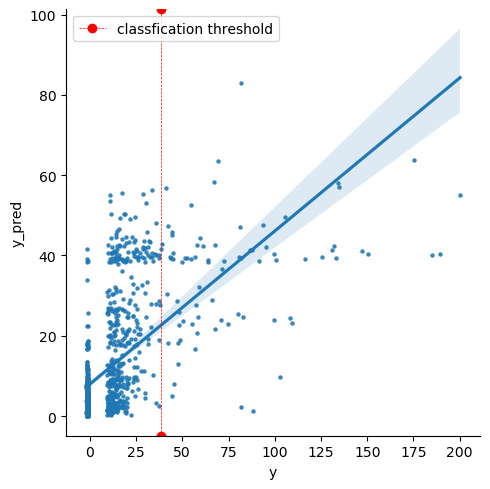

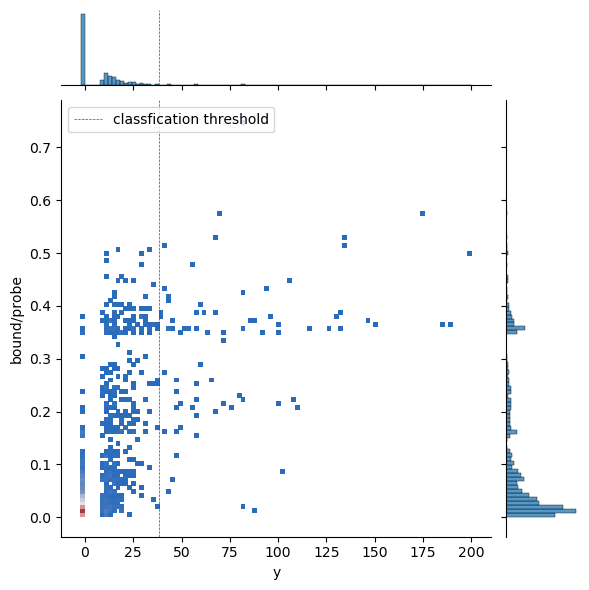

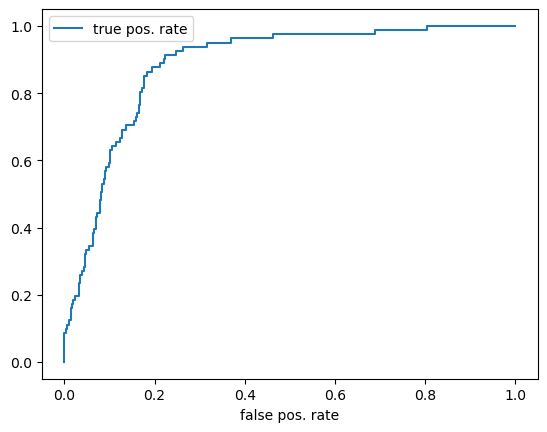

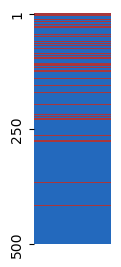

I: Classification performance AUROC: 0.8839



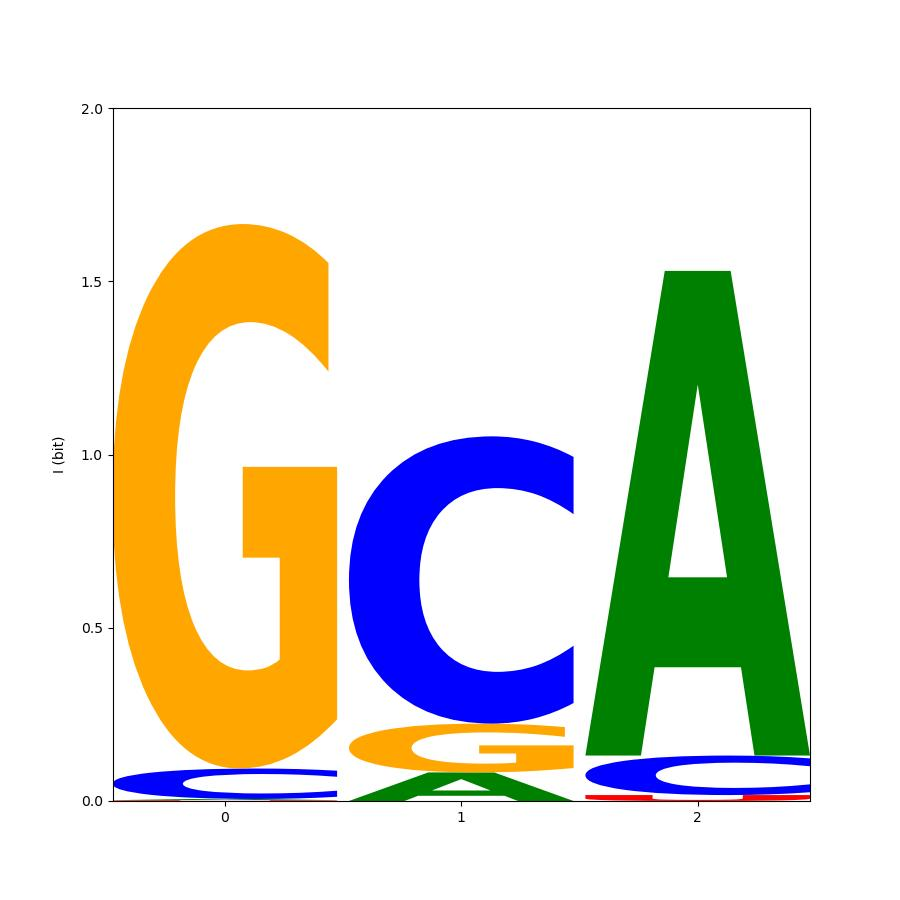
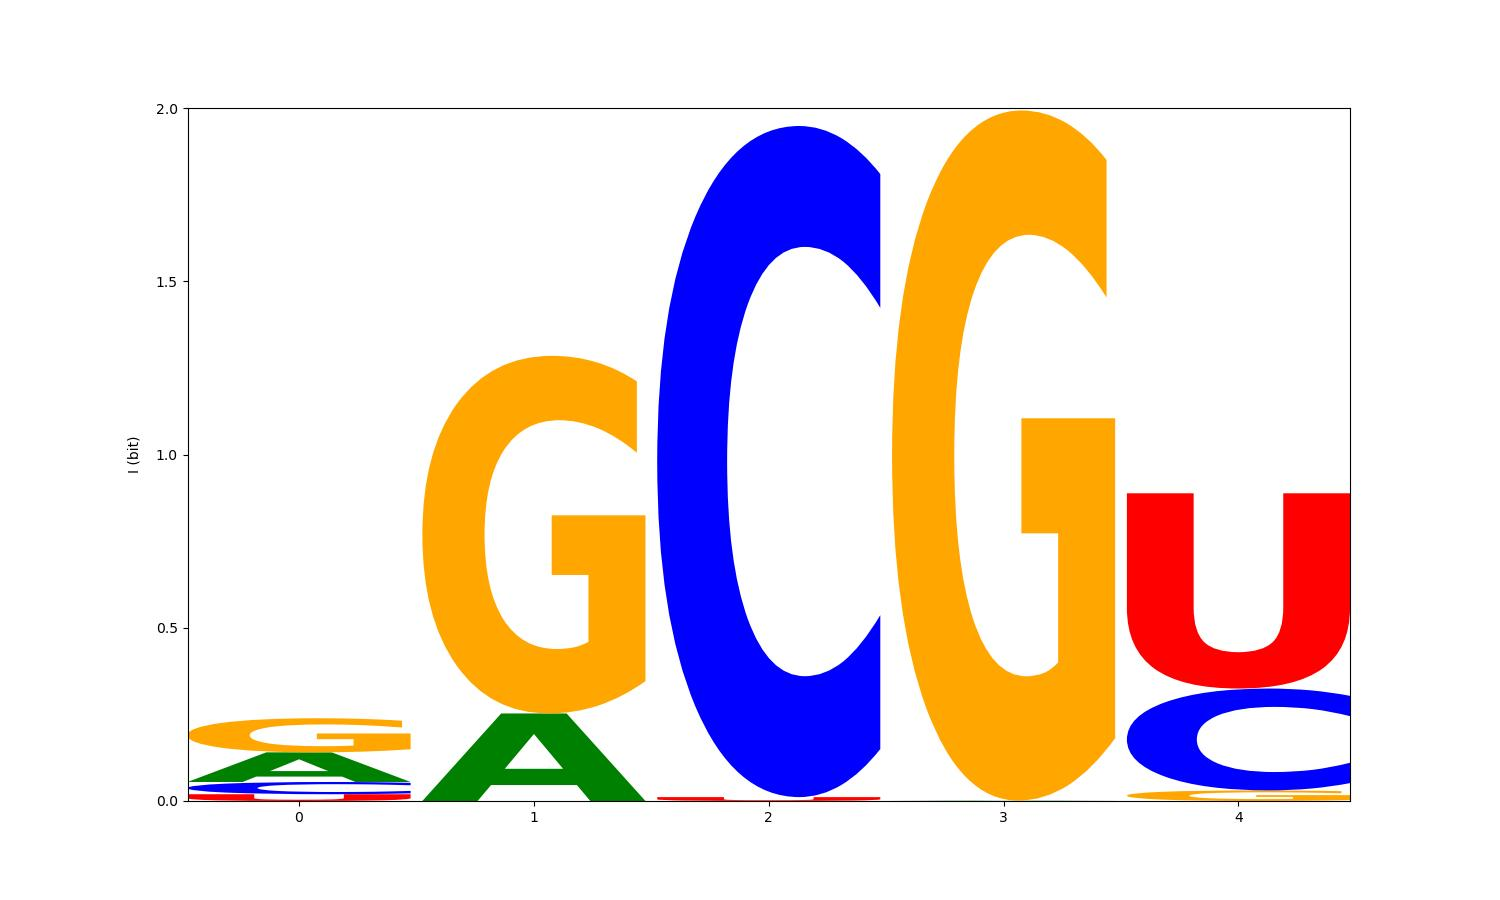
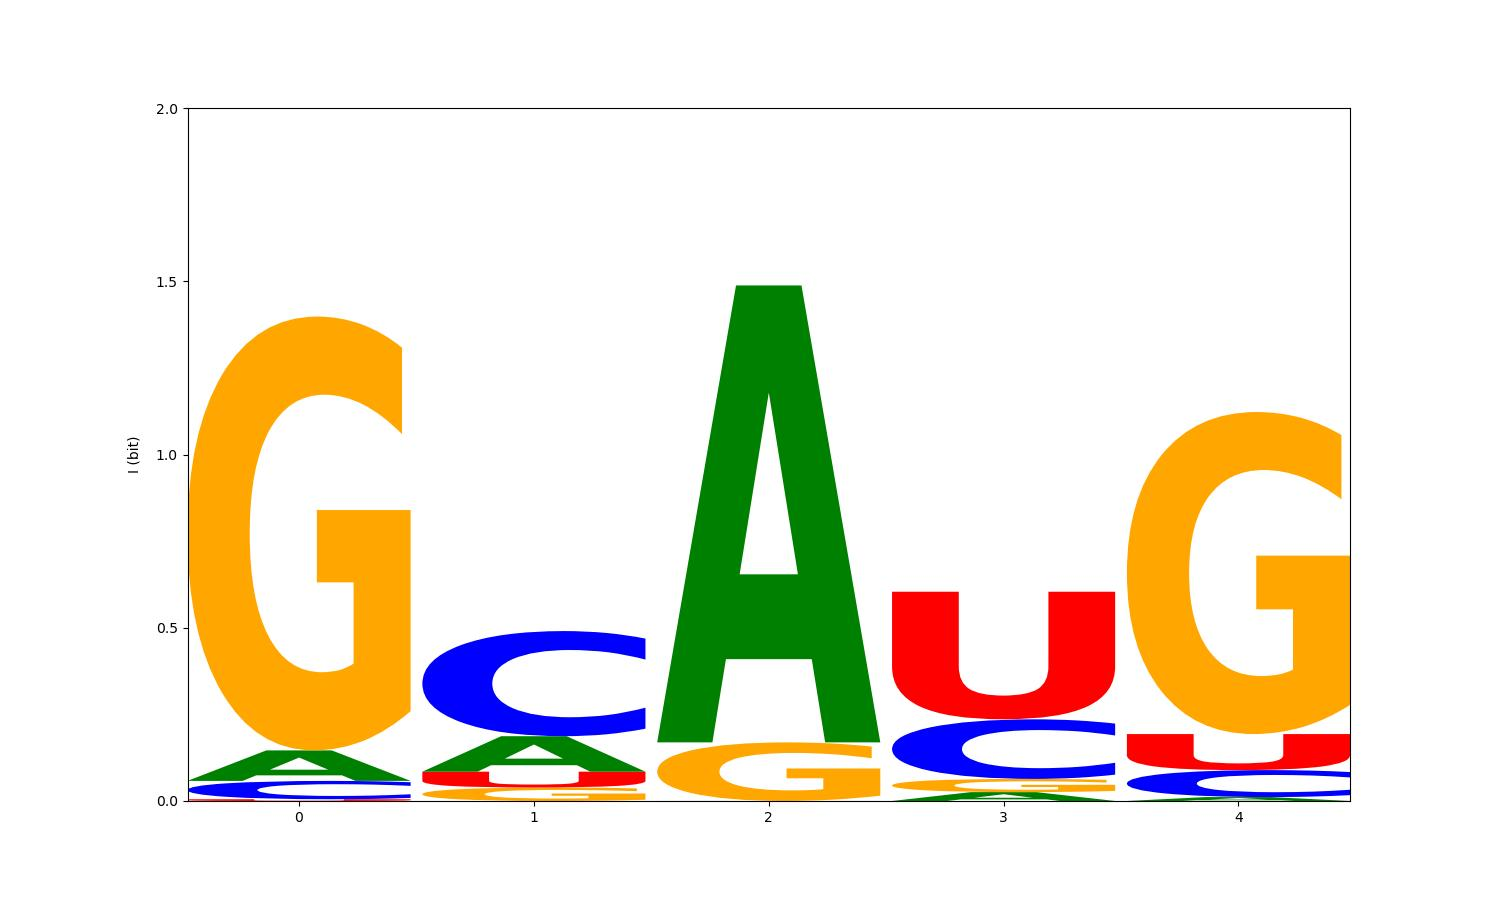

In [18]:
# visualisation of the motif with the highest r with the train dataset
print('I: Best motif according to r (train) from the repeated optimizations.')
model_best_repetition=df_repetitions.iloc[0]['model']
model_best_repetition.analyse_motif(X_subset,y_subset, THRESHOLD, nuc_type=NUC_TYPE) 
# store results and display stages
STAGES.append('best repetition', model_best_repetition, new_entries={'r (test)': mf.linregress(model_best_repetition.predict(X_test),y_test).rvalue})
mf.display_df(STAGES.df, nuc_type=NUC_TYPE)

Optimization took 10.26 hours.
I: energy matrix and logos:



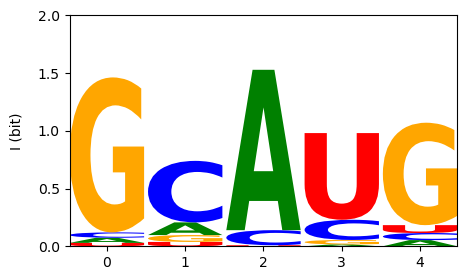

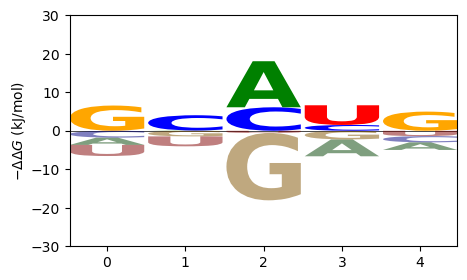


        A     C      G     U
0   1887  1780  -6557  2889
1    -63 -3975   1453  2585
2 -11959 -6106  17505   559
3   4385 -1509   2239 -5115
4   1978  1631  -4980  1370

I: summed absolute energies of each position:
0    13114
1     8078
2    36130
3    13249
4     9960
dtype: int64

I: averaged summed energy over all positions: 16106
I: Mean and Standard Deviation for the Free Energy G to all subsequences of all probes: -14642 +/- 12349
I: Plot of the Occupancy of a subsite as the function of the Free Energy G 
   overlaid with the distribution of the Free Energy of all subsites.
I: There shall be only a small overlap of both curves. i.e. only the most negative Free Energies
    lead to a measurable occupancy.


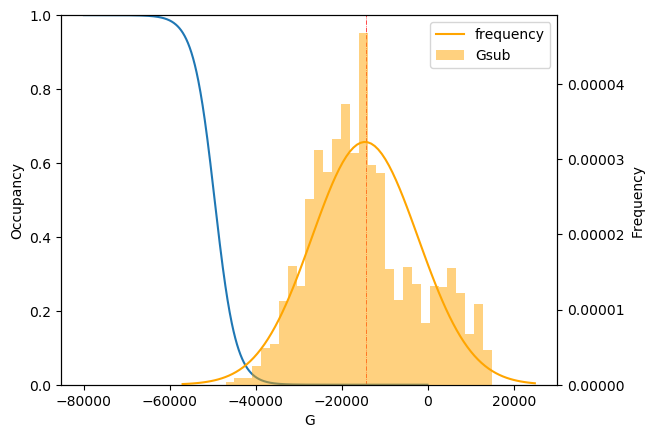

I: Calculated occupancy over all subsite of a single probe:
   binding:  0.00016 .. 0.62638 (ratio: 3883.3)
I: number of probes: 193055
I: Pearson Correlation  r: 0.4044
I: mean absolute error: 2.6771


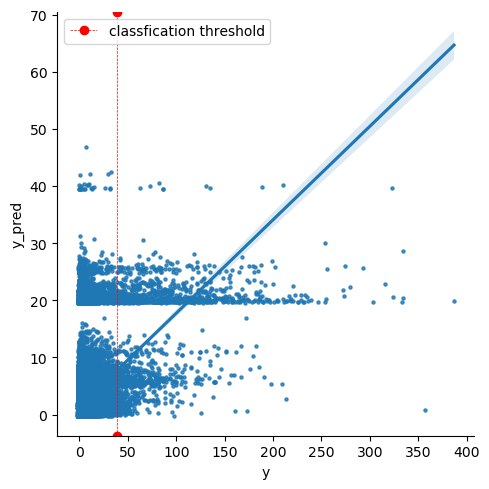

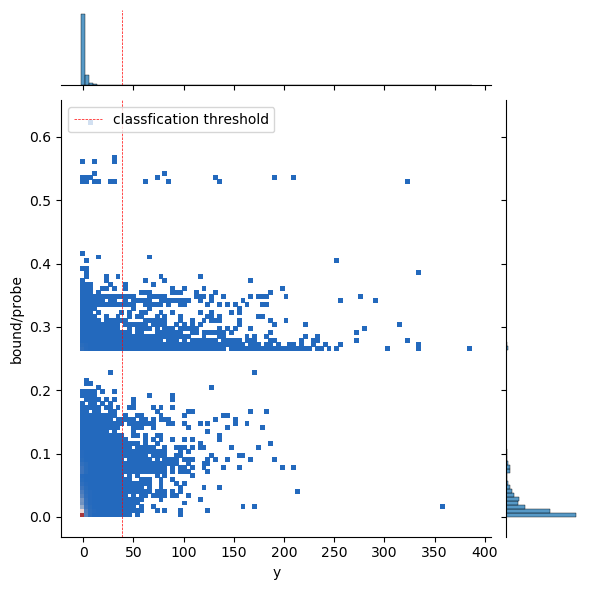

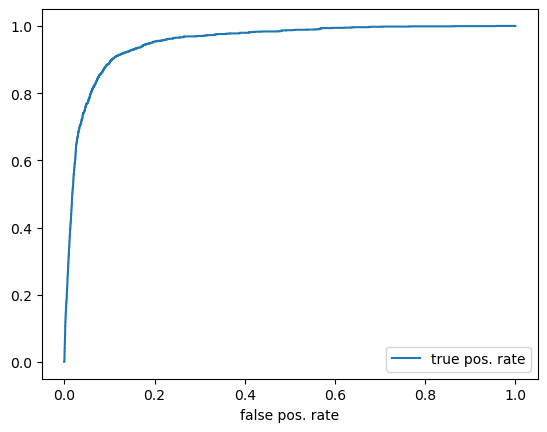

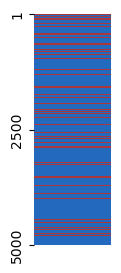

I: Classification performance AUROC: 0.9523



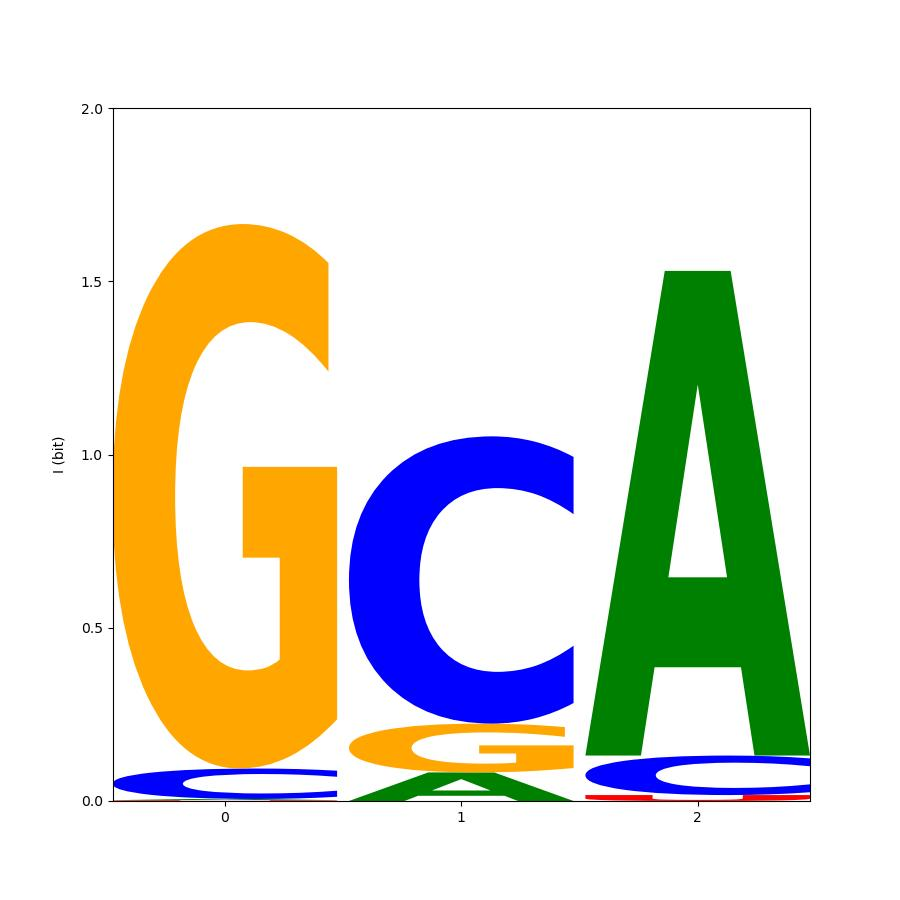
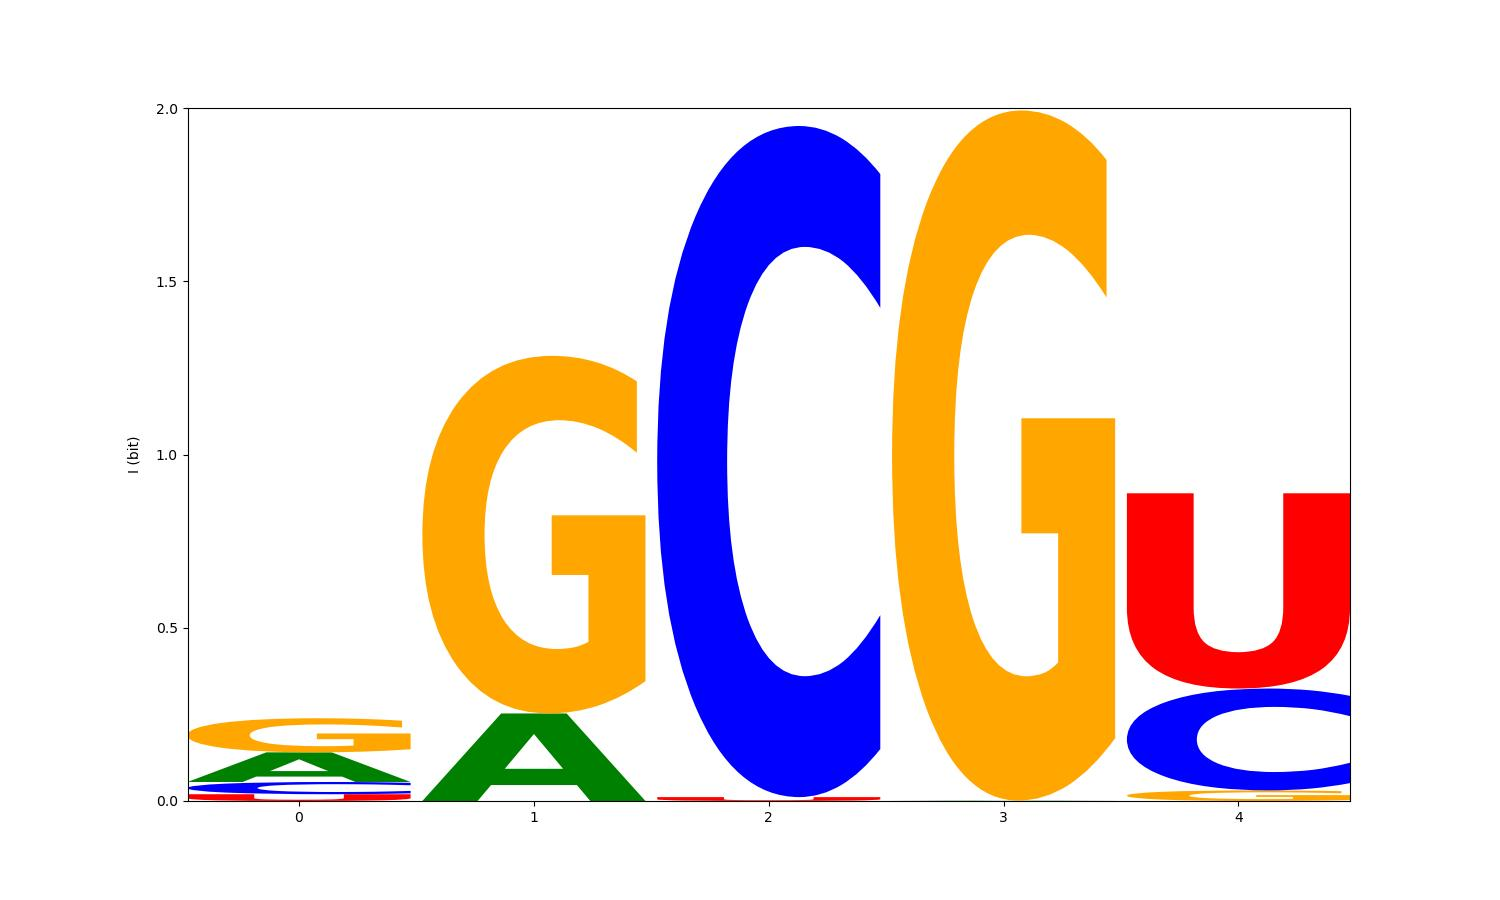
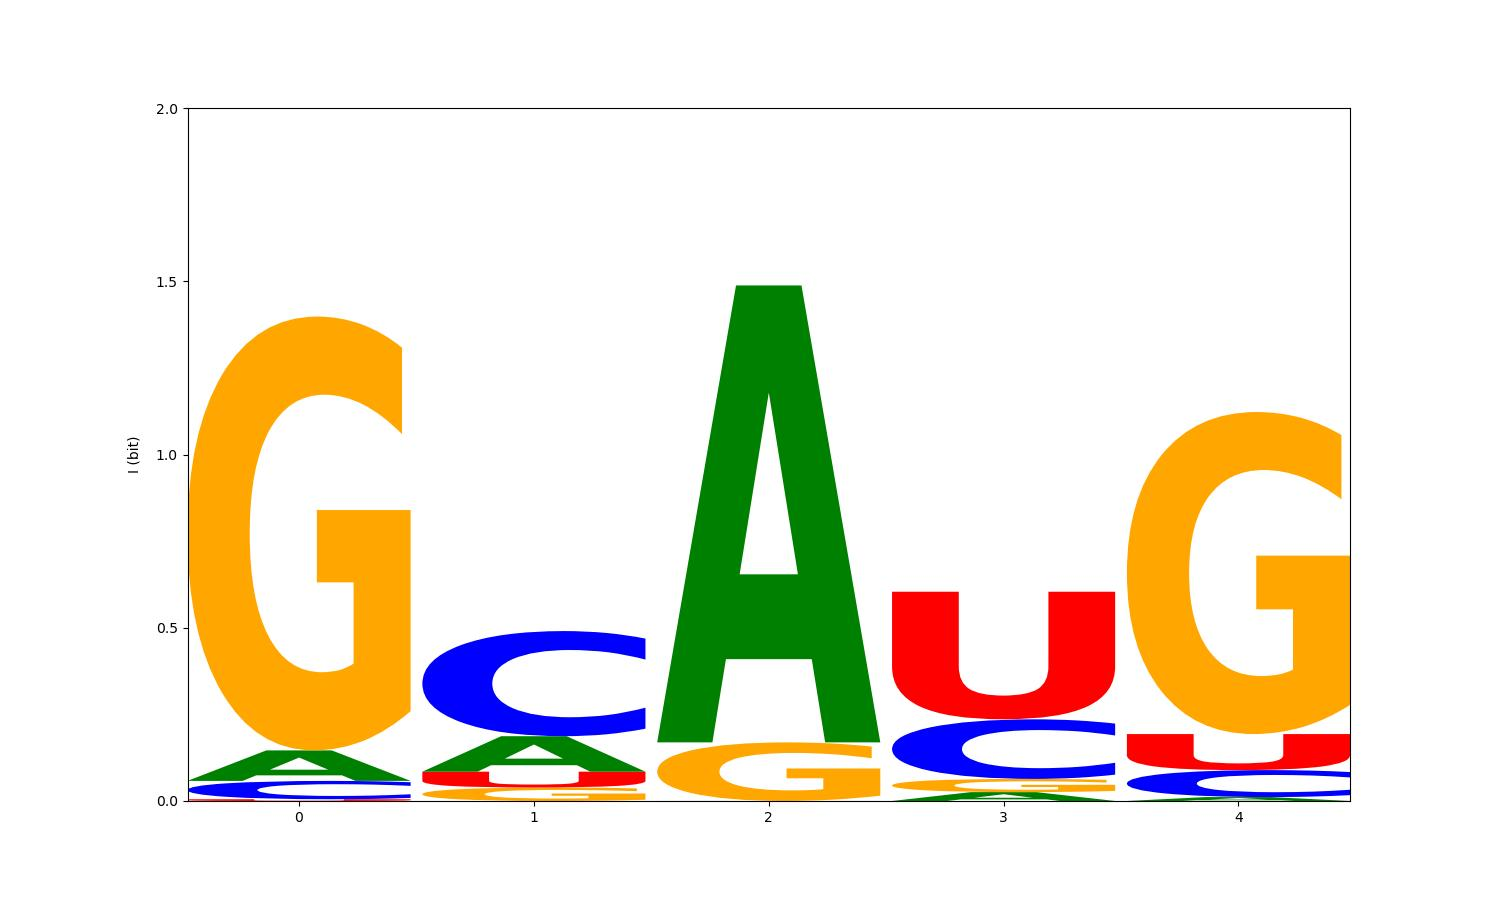
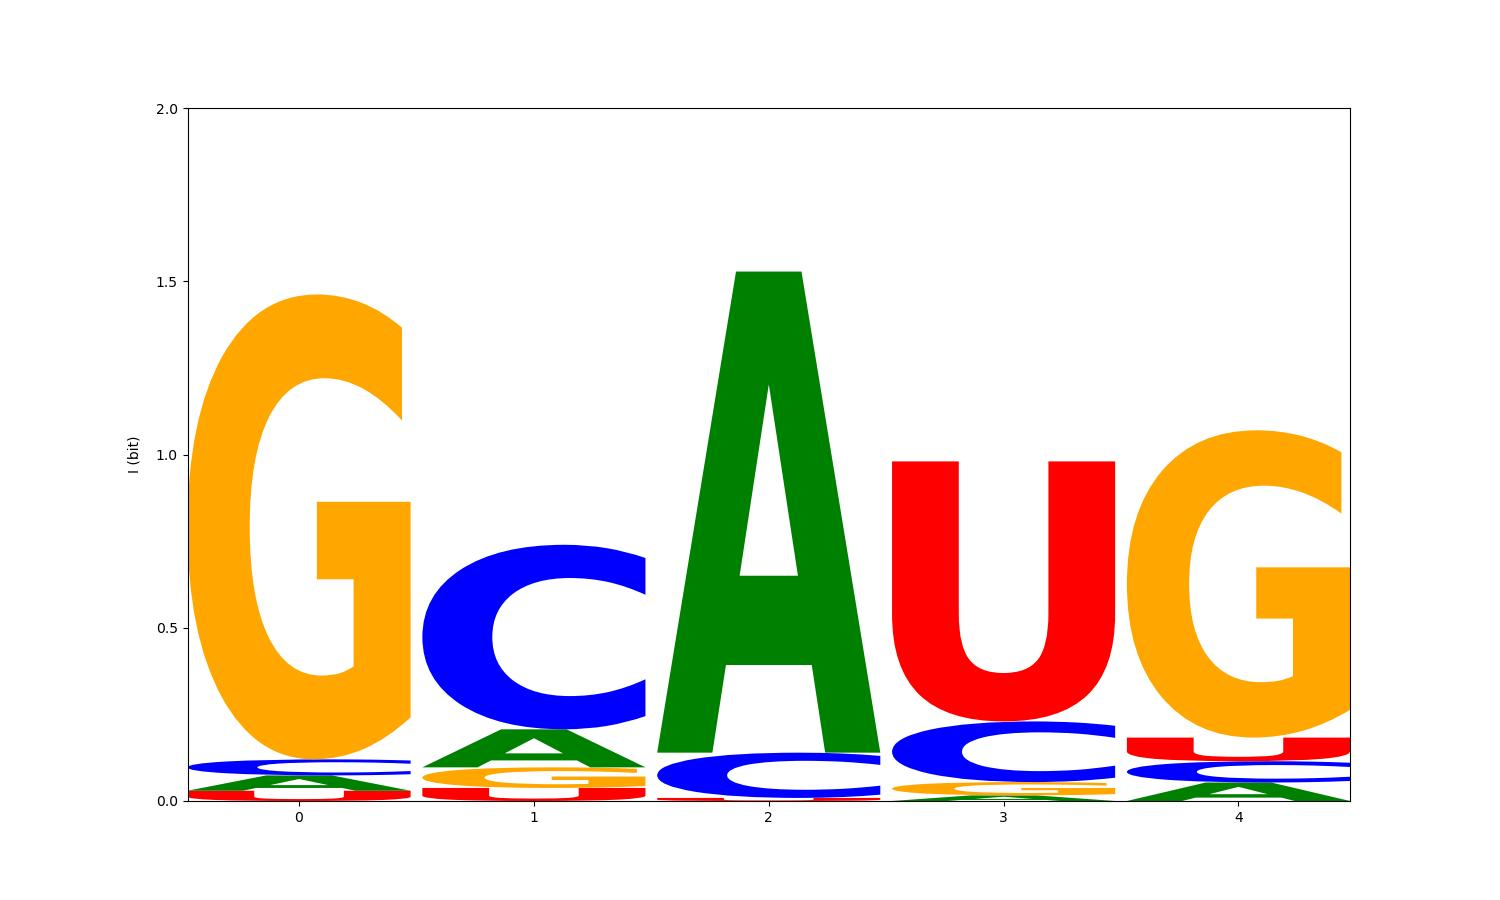

In [19]:
### motif finding on complete training dataset starting with best motif from repetitions

#fit & predict optimization starting with previous energy matrix
model_train=mf.findmotif(motif_length=CORE_MOTIF_LENGTH, protein_conc=PROT_CONC, both_strands=BOTH_STRANDS,
                   start=model_best_repetition.energies_)
start = time()
model_train.fit(X_train,y_train)
print("I: Optimization took %.2f hours." % ((time() - start)/3600))

# print & display main results
model_train.analyse_motif(X_train,y_train, THRESHOLD, nuc_type=NUC_TYPE)

# store results and display stages
STAGES.append('train dataset', model_train, new_entries={'r (test)': mf.linregress(model_train.predict(X_test),y_test).rvalue})
mf.display_df(STAGES.df, nuc_type=NUC_TYPE)

  0%|          | 0/6 [00:00<?, ?engine/s]

job5:   0%|          | 0/3 [00:00<?, ?tasks/s]

job3:   0%|          | 0/3 [00:00<?, ?tasks/s]

Optimization took 1.32 hours.


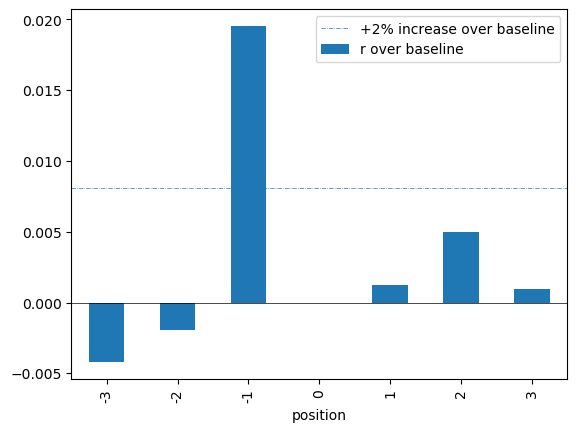

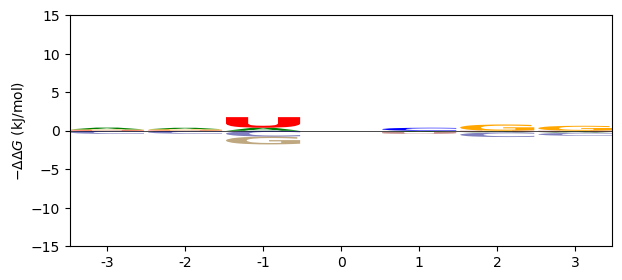

I: It is suggested to extend the core motif at the 5' end by 1 and at the 3' end by 0 positions.
I: Current GO = -14468 J/mol (see red broken line in figure below) with r = 0.404.
I: Optimizing G0 for highest r ...
  ... maximal r is 0.404 at G0=-13874 J/mol (see green broken line below).

I: Optimizing G0 for predetermined maximal binding ...
        max binding    G0 [J/mol]
        0.2           -11169
        2             -19468
... see blue broken lines in figure



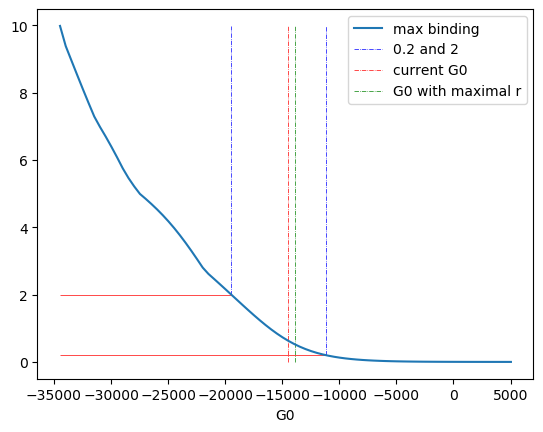

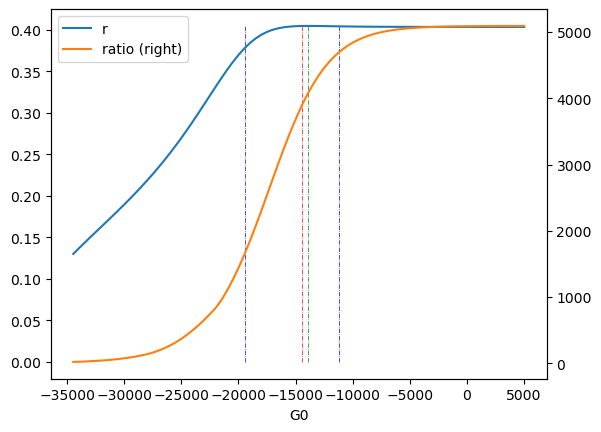

I: G0 is in a range leading to maximal probe occupancy between 0.2 and 2. Good.
W: G0 differs strongly to the G0 leading to maximal r. G0 might be set manually for adjustment.


In [20]:
### Based on the motif of CORE_MOTIF_LENGTH analyze the neigbouring positions 
### whether their inclusion can improve the quality of the motif
df_positions=model_train.investigate_extension_parallel(X_train,y_train, end5=3, end3=3, nuc_type=NUC_TYPE)

list_positions=df_positions.index[df_positions['+2%']].tolist()+[0] # list of positions with an increase of2% and default position 0
ext5=-min(list_positions)
ext3=max(list_positions)
print("I: It is suggested to extend the core motif at the 5' end by %i and at the 3' end by %i positions." %(ext5, ext3))

### Analyze model whether the estimated G0 is correct
results=model_train.investigate_G0(X_train,y_train)
G0_maxr, G0_max_binding_low, G0_max_binding_high=results[1:]

if model_train.finalG0_>=G0_max_binding_high and model_train.finalG0_<=G0_max_binding_low:
    print('I: G0 is in a range leading to maximal probe occupancy between 0.2 and 2. Good.')
else:
    print('W: G0 outside the range leading to maximal probe occupancy between 0.2 and 2. G0 might be set manually for adjustment.')

if model_train.finalG0_>=0.95*G0_maxr.x[0] and model_train.finalG0_<=1.05*G0_maxr.x[0]:  ### FIXME include both r for calculation
    print('I: G0 is close to the G0 leading to maximal r. Good')
else:
    print('W: G0 differs strongly to the G0 leading to maximal r. G0 might be set manually for adjustment.')    


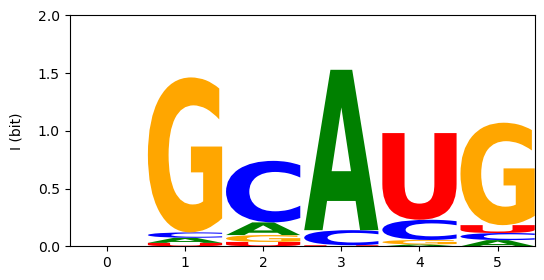

In [21]:
expanded_energies=mf.modify_energies(model_train.energies_, end5=ext5, end3=ext3)  # <==== adjust end5 and end3 to enlarge core motif on 5' and 3' end
mf.energies2logo(expanded_energies, nuc_type=NUC_TYPE)
expanded_motif_length=len(expanded_energies)//4

Optimization took 27.17 hours.
I: energy matrix and logos:



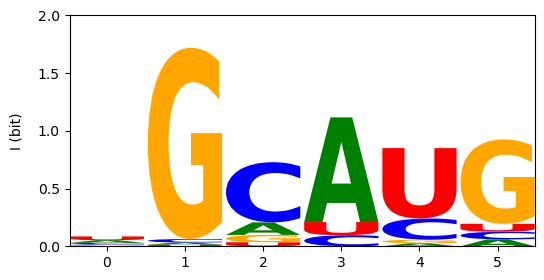

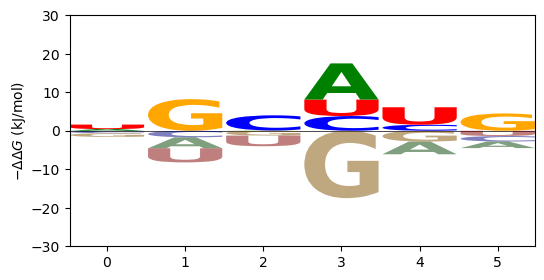


       A     C      G     U
0  -441   632    974 -1165
1  2856  1691  -8213  3665
2   -67 -3949   1244  2772
3 -9401 -3828  17500 -4271
4  3301 -1567   2804 -4538
5  1711  1433  -4500  1355

I: summed absolute energies of each position:
0     3213
1    16427
2     8033
3    35001
4    12212
5     9001
dtype: int64

I: averaged summed energy over all positions: 13981
I: Mean and Standard Deviation for the Free Energy G to all subsequences of all probes: -11864 +/- 11947
I: Plot of the Occupancy of a subsite as the function of the Free Energy G 
   overlaid with the distribution of the Free Energy of all subsites.
I: There shall be only a small overlap of both curves. i.e. only the most negative Free Energies
    lead to a measurable occupancy.


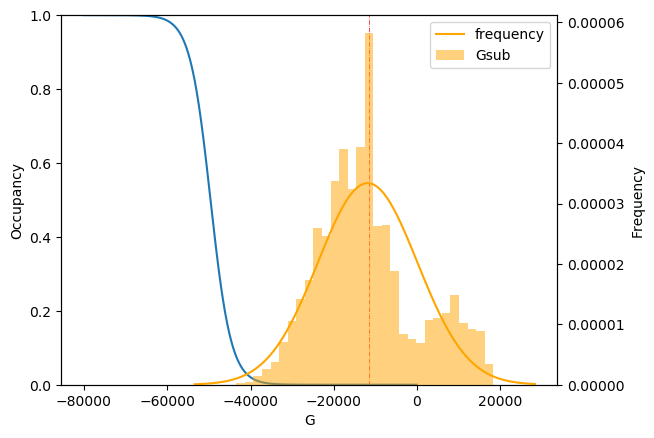

I: Calculated occupancy over all subsite of a single probe:
   binding:  0.00007 .. 0.15469 (ratio: 2244.4)
I: number of probes: 193055
I: Pearson Correlation  r: 0.4303
I: mean absolute error: 2.6661


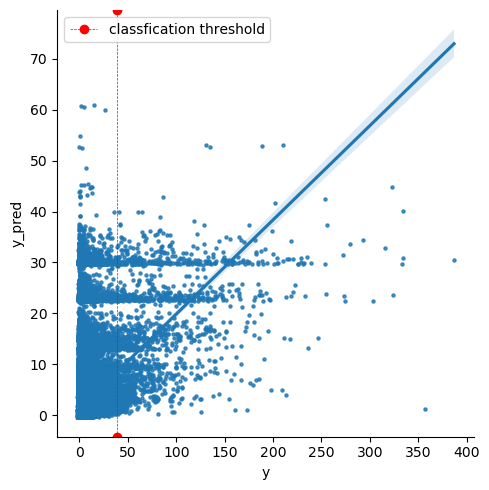

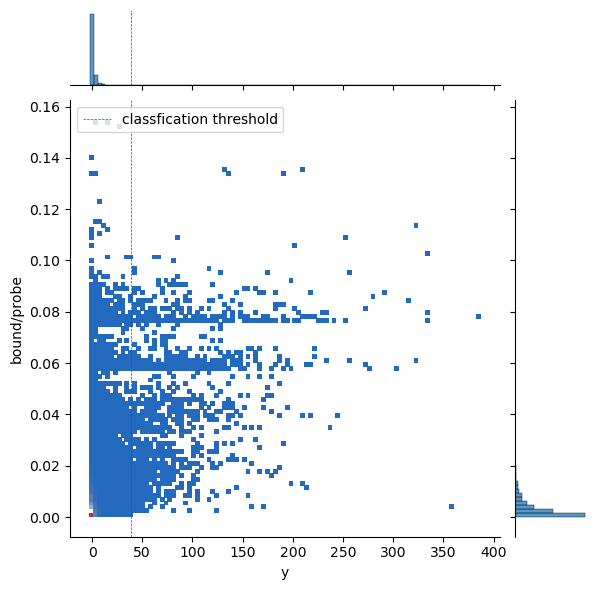

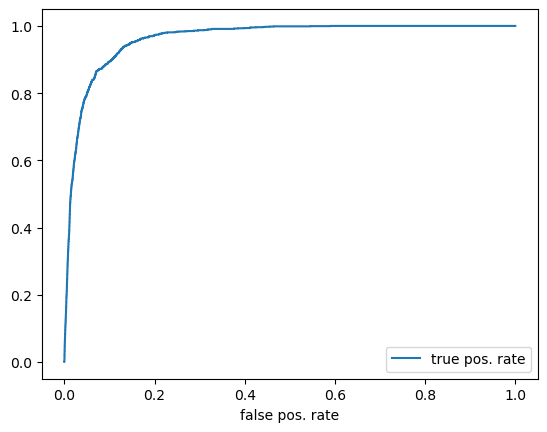

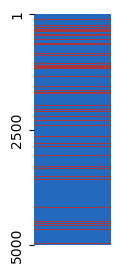

I: Classification performance AUROC: 0.9625



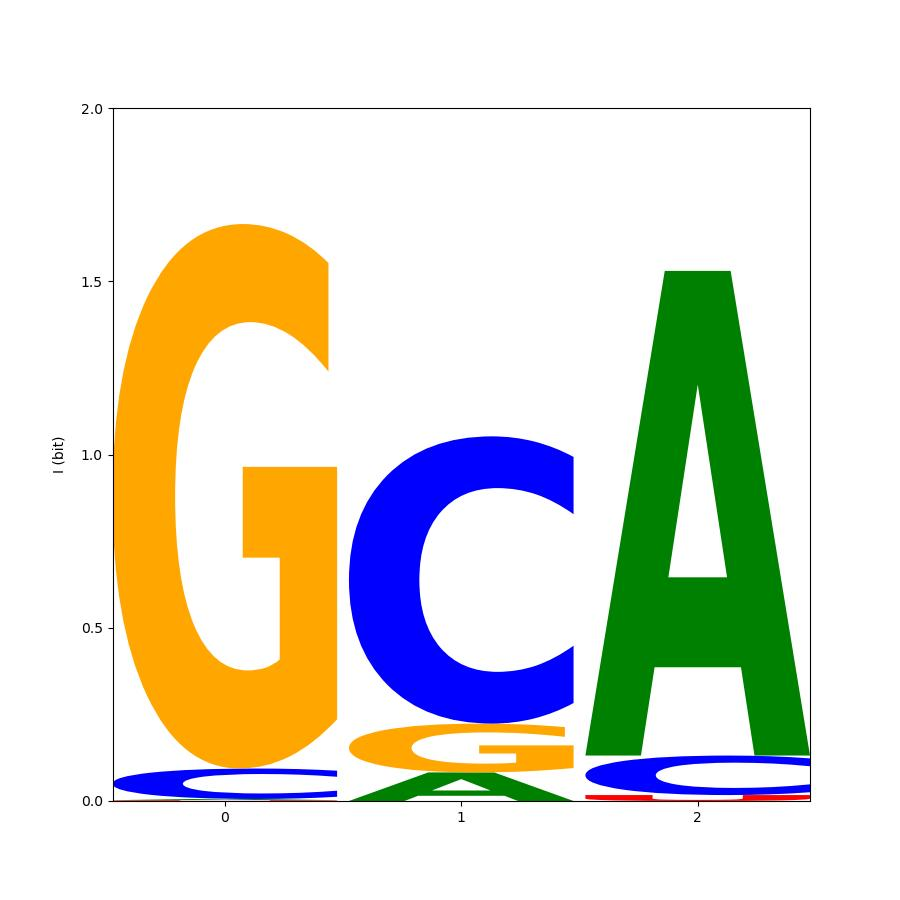
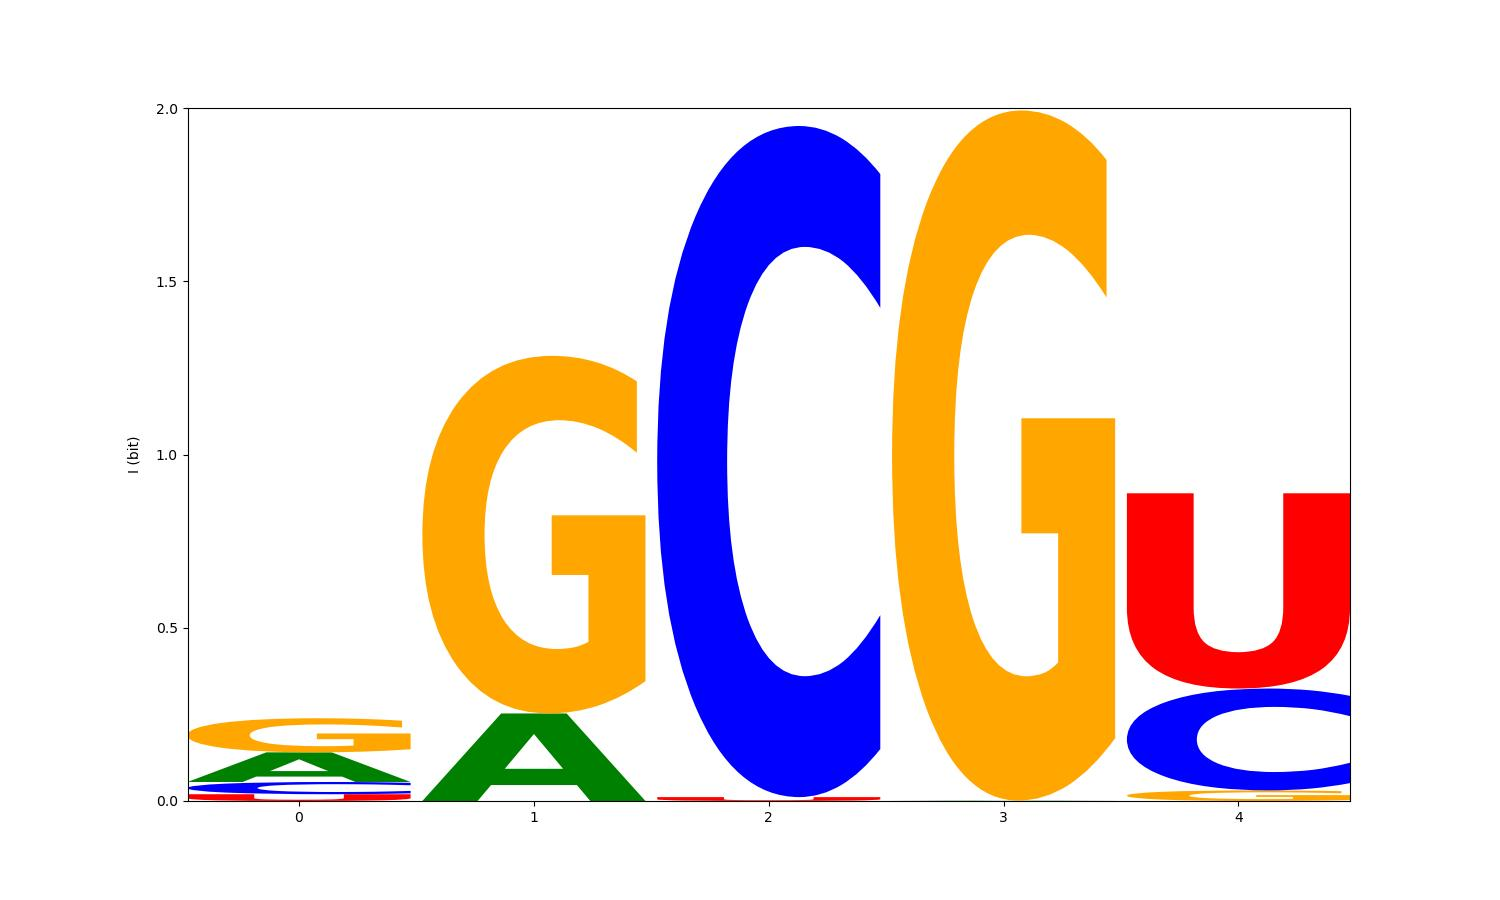
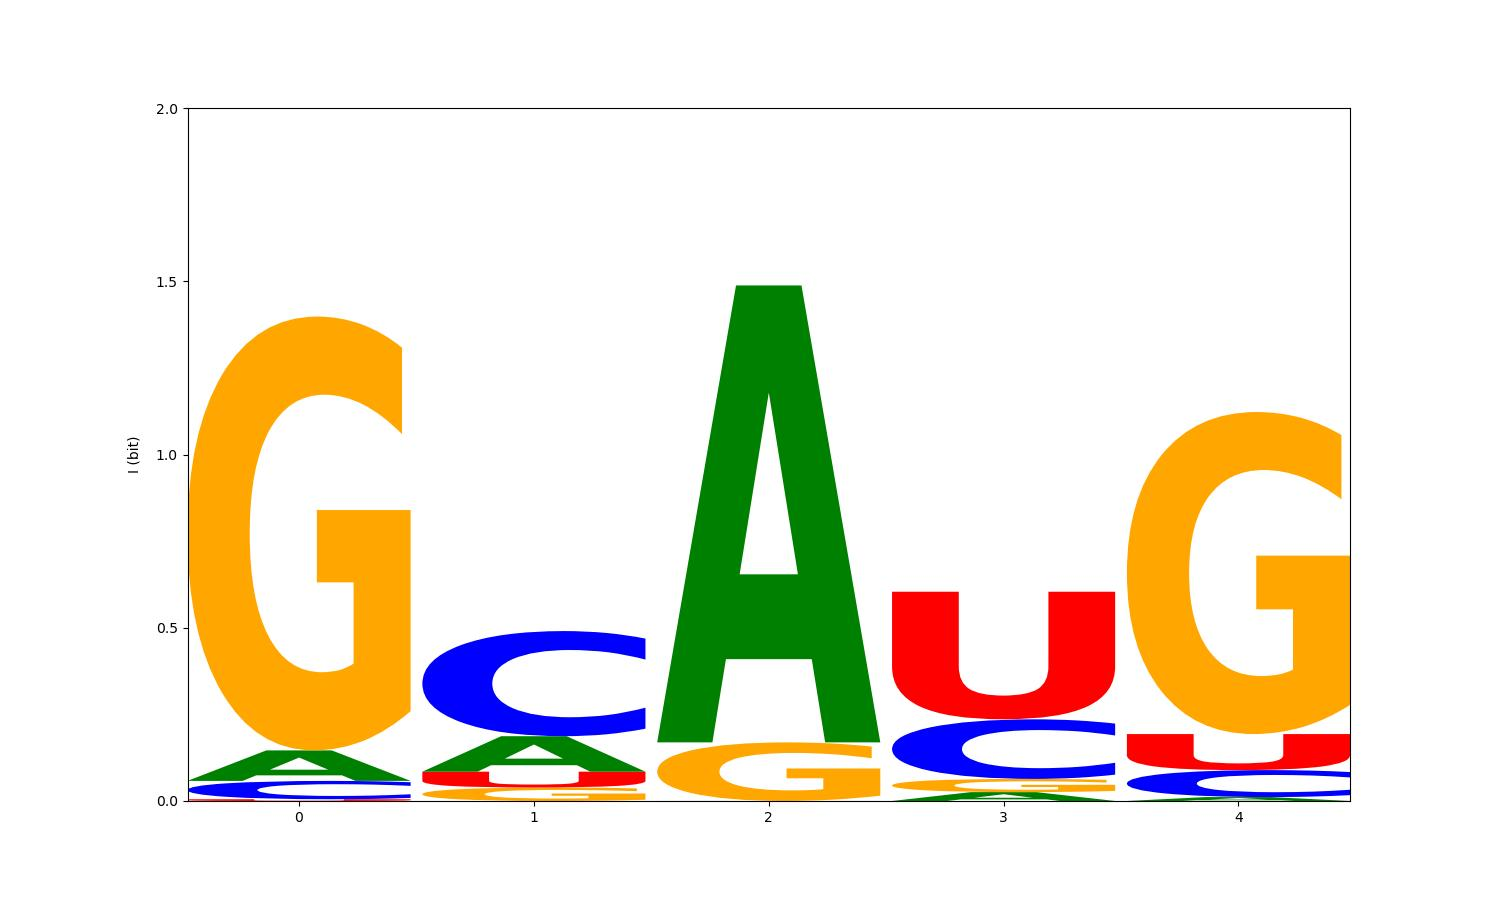
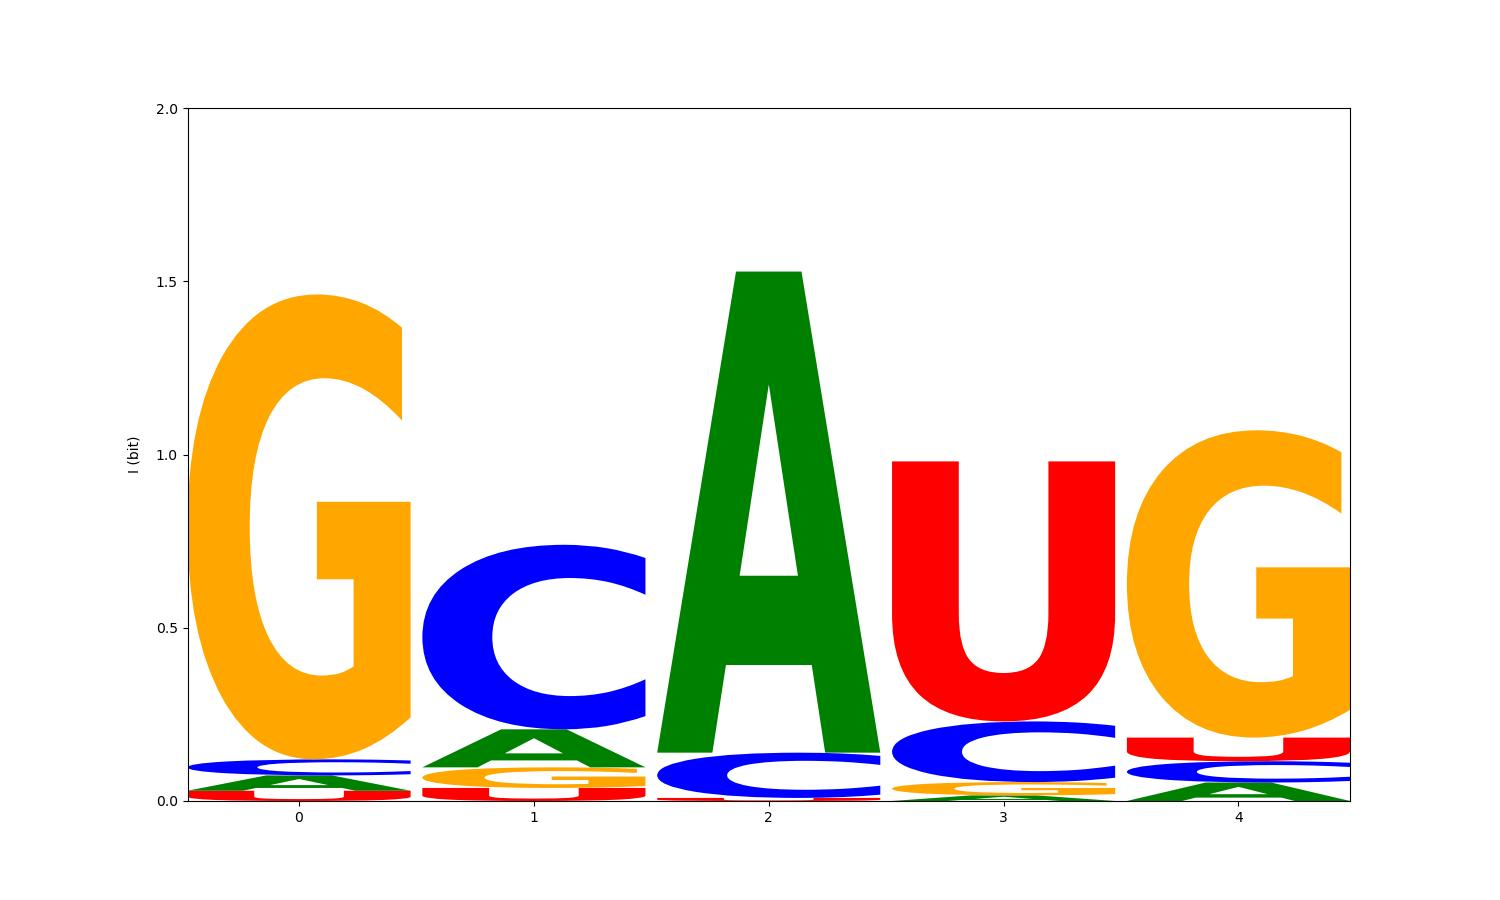
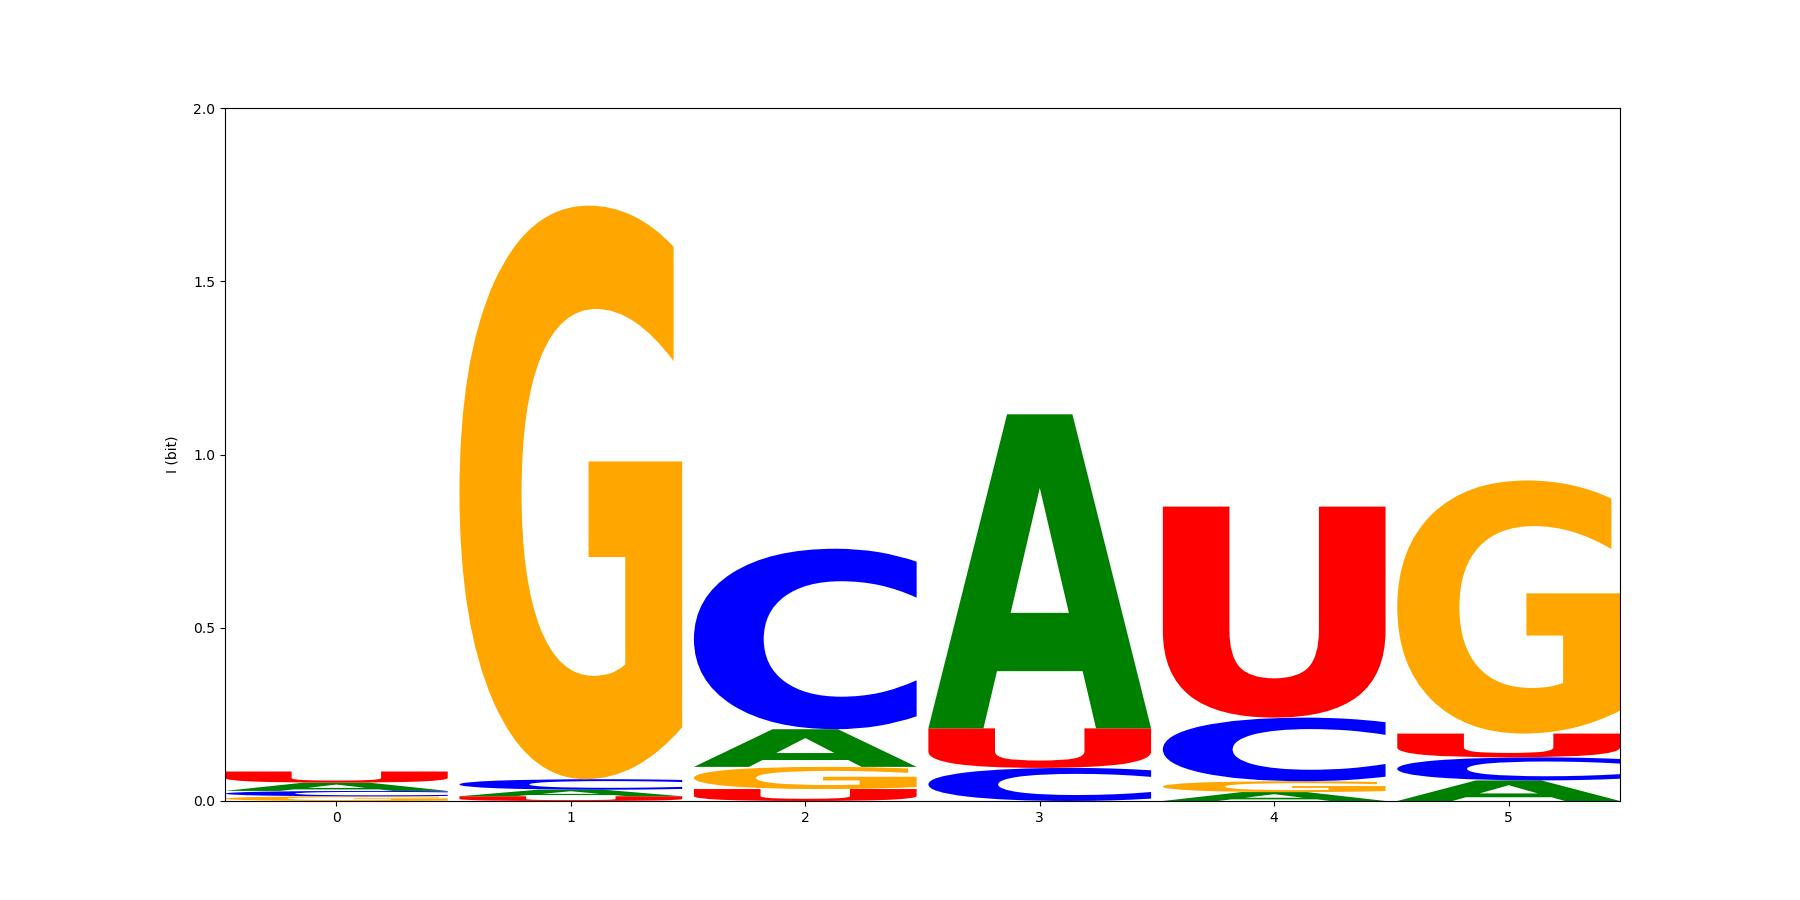

In [22]:
### fit & predict optimization starting with extended energy matrix
model_extended=mf.findmotif(motif_length=expanded_motif_length, protein_conc=PROT_CONC, both_strands=BOTH_STRANDS,
                   start=expanded_energies)

start = time()
model_extended.fit(X_train,y_train)
print("Optimization took %.2f hours." % ((time() - start)/3600))

# print & display main results
model_extended.analyse_motif(X_train,y_train, THRESHOLD, nuc_type=NUC_TYPE)

# store results and display stages
STAGES.append('train, extended', model_extended, new_entries={'r (test)': mf.linregress(model_extended.predict(X_test),y_test).rvalue})
mf.display_df(STAGES.df, nuc_type=NUC_TYPE)

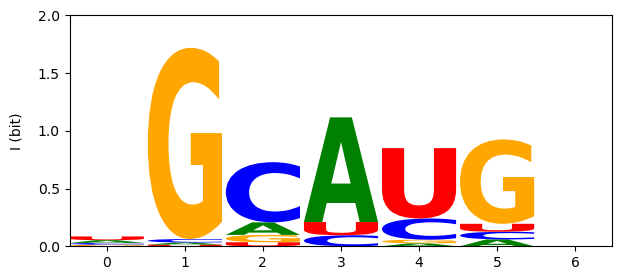

Optimization took 9.73 hours.
I: energy matrix and logos:



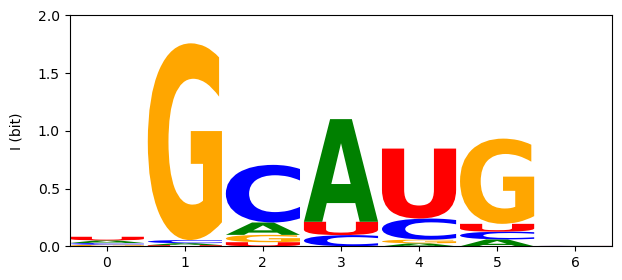

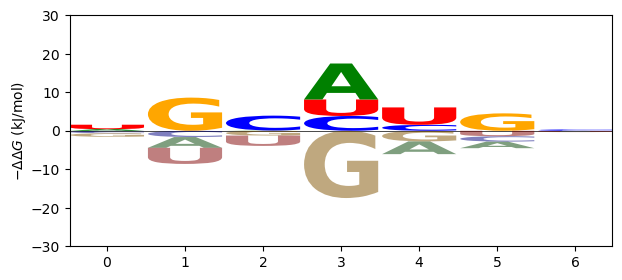


       A     C      G     U
0  -423   647    928 -1152
1  2794  1628  -8614  4191
2   -62 -3868   1237  2692
3 -9339 -3845  17472 -4287
4  3315 -1547   2751 -4520
5  1706  1416  -4523  1400
6    72  -343     34   236

I: summed absolute energies of each position:
0     3151
1    17228
2     7861
3    34945
4    12134
5     9047
6      686
dtype: int64

I: averaged summed energy over all positions: 12150
I: Mean and Standard Deviation for the Free Energy G to all subsequences of all probes: -9282 +/- 12169
I: Plot of the Occupancy of a subsite as the function of the Free Energy G 
   overlaid with the distribution of the Free Energy of all subsites.
I: There shall be only a small overlap of both curves. i.e. only the most negative Free Energies
    lead to a measurable occupancy.


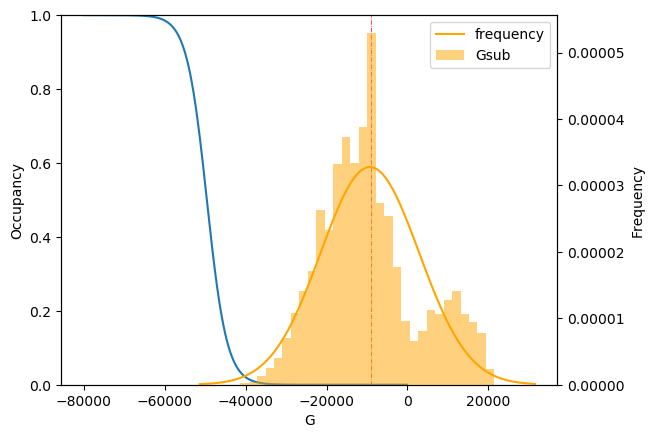

I: Calculated occupancy over all subsite of a single probe:
   binding:  0.00003 .. 0.07134 (ratio: 2709.6)
I: number of probes: 193055
I: Pearson Correlation  r: 0.4320
I: mean absolute error: 2.6596


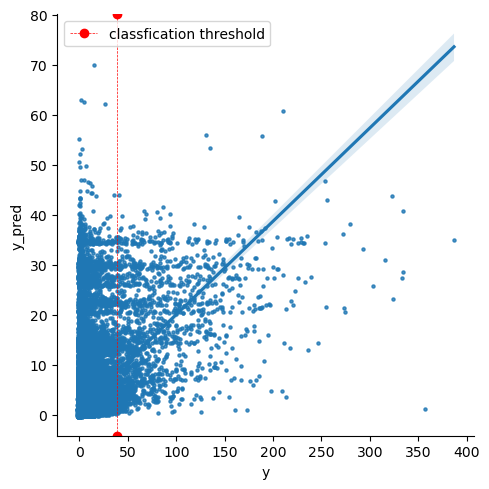

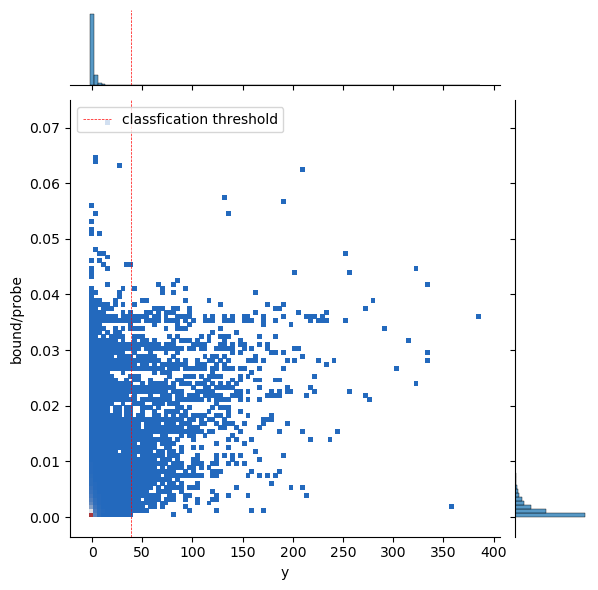

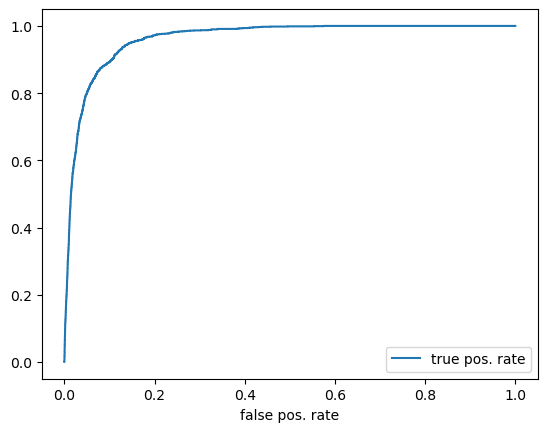

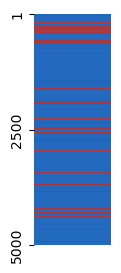

I: Classification performance AUROC: 0.9624


In [23]:
### fit & predict optimization starting with extended energy matrix plus one bordering position on each side if current bordering position exceed the information of 0.25

I_5=mf.energies2information(model_extended.energies_[0:4])>0.25 #sufficient information content of 5' end position
I_3=mf.energies2information(model_extended.energies_[-4:])>0.25 #sufficient information content of 3' end position

if I_5 or I_3:
    expanded_energies_with_border=mf.modify_energies(model_extended.energies_, end5=I_5, end3=I_3)  
    mf.energies2logo(expanded_energies_with_border, nuc_type=NUC_TYPE)
    motif_length_with_border=len(expanded_energies_with_border)//4

    model_with_border=mf.findmotif(motif_length=motif_length_with_border, protein_conc=PROT_CONC, both_strands=BOTH_STRANDS,
                   start=expanded_energies_with_border)


    start = time()
    model_with_border.fit(X_train,y_train)
    print("Optimization took %.2f hours." % ((time() - start)/3600))

    # print & display main results
    model_with_border.analyse_motif(X_train,y_train, THRESHOLD, nuc_type=NUC_TYPE)

    # store results and display stages
    STAGES.append('train, expanded, border', model_with_border, new_entries={'r (test)': mf.linregress(model_with_border.predict(X_test),y_test).rvalue})
    mf.display_df(STAGES.df, nuc_type=NUC_TYPE)

Optimization terminated successfully.
         Current function value: 2.153076
         Iterations: 13
         Function evaluations: 4069
Optimization took 37.97 hours.
I: energy matrix and logos:



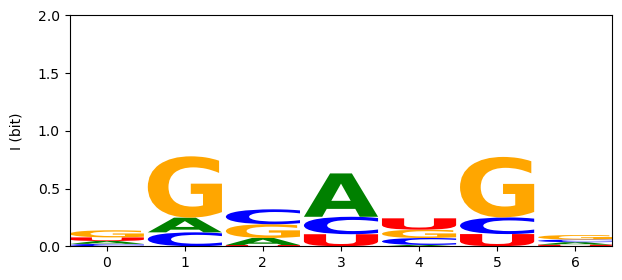

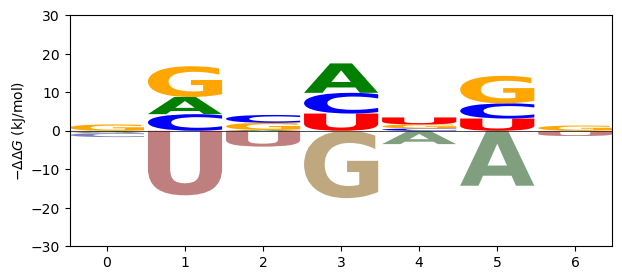


        A     C      G      U
0    559  1044  -1646     42
1  -4453 -4318  -7989  16761
2   -210 -2050  -1848   4110
3  -7641 -5385  17500  -4473
4   3460  -592  -1051  -1816
5  14272 -3949  -7144  -3177
6    158   -27  -1335   1204

I: summed absolute energies of each position:
0     3292
1    33523
2     8220
3    35000
4     6921
5    28544
6     2726
dtype: int64

I: averaged summed energy over all positions: 16889
I: Mean and Standard Deviation for the Free Energy G to all subsequences of all probes: -9448 +/- 16177
I: Plot of the Occupancy of a subsite as the function of the Free Energy G 
   overlaid with the distribution of the Free Energy of all subsites.
I: There shall be only a small overlap of both curves. i.e. only the most negative Free Energies
    lead to a measurable occupancy.


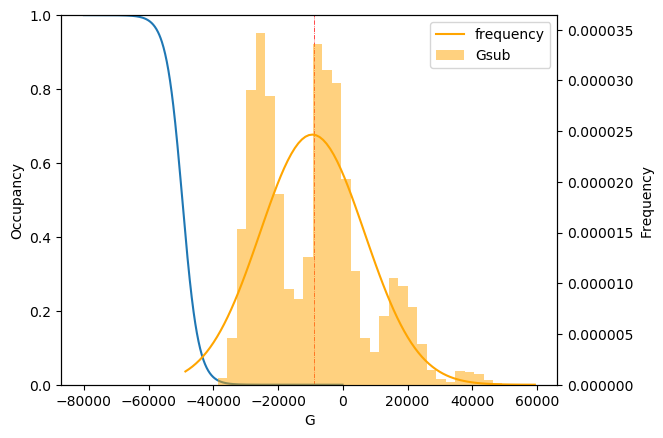

I: Calculated occupancy over all subsite of a single probe:
   binding:  0.00006 .. 0.03192 (ratio: 2709.6)
I: number of probes: 193055
I: Pearson Correlation  r: 0.2276
I: mean absolute error: 2.1569


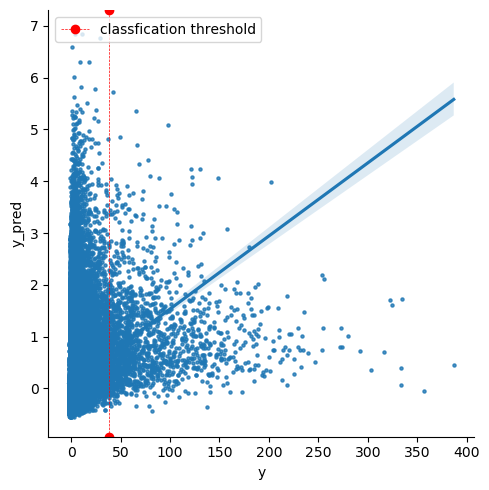

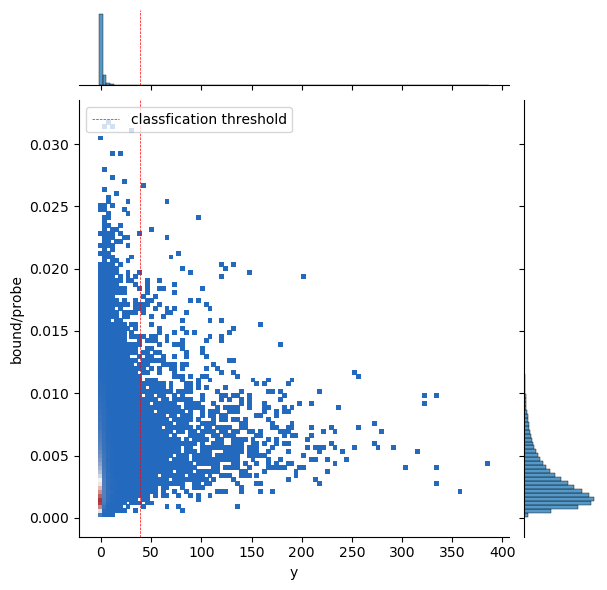

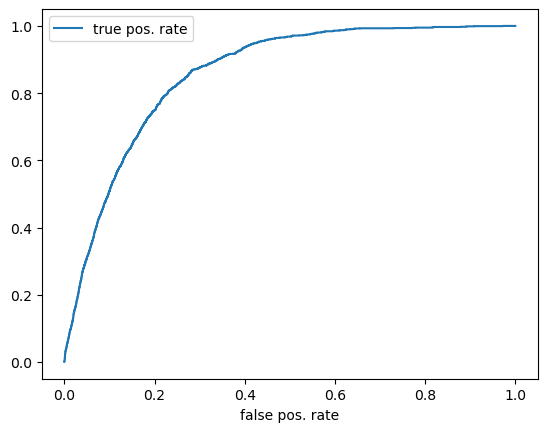

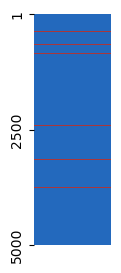

I: Classification performance AUROC: 0.8577



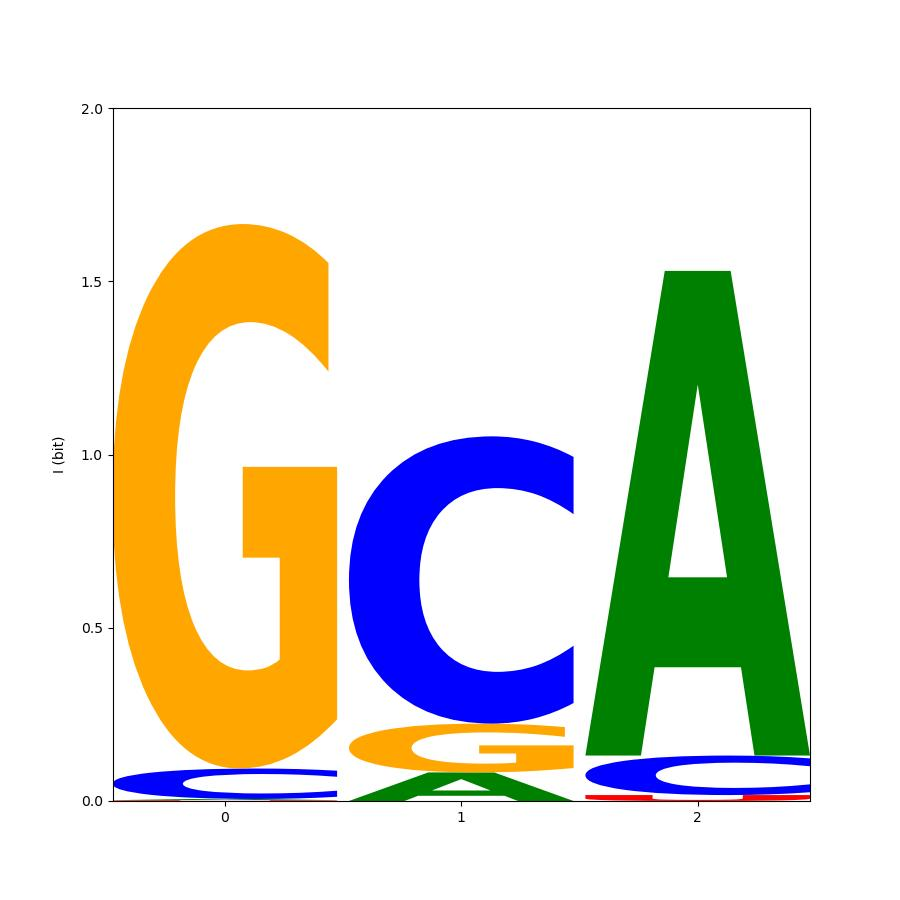
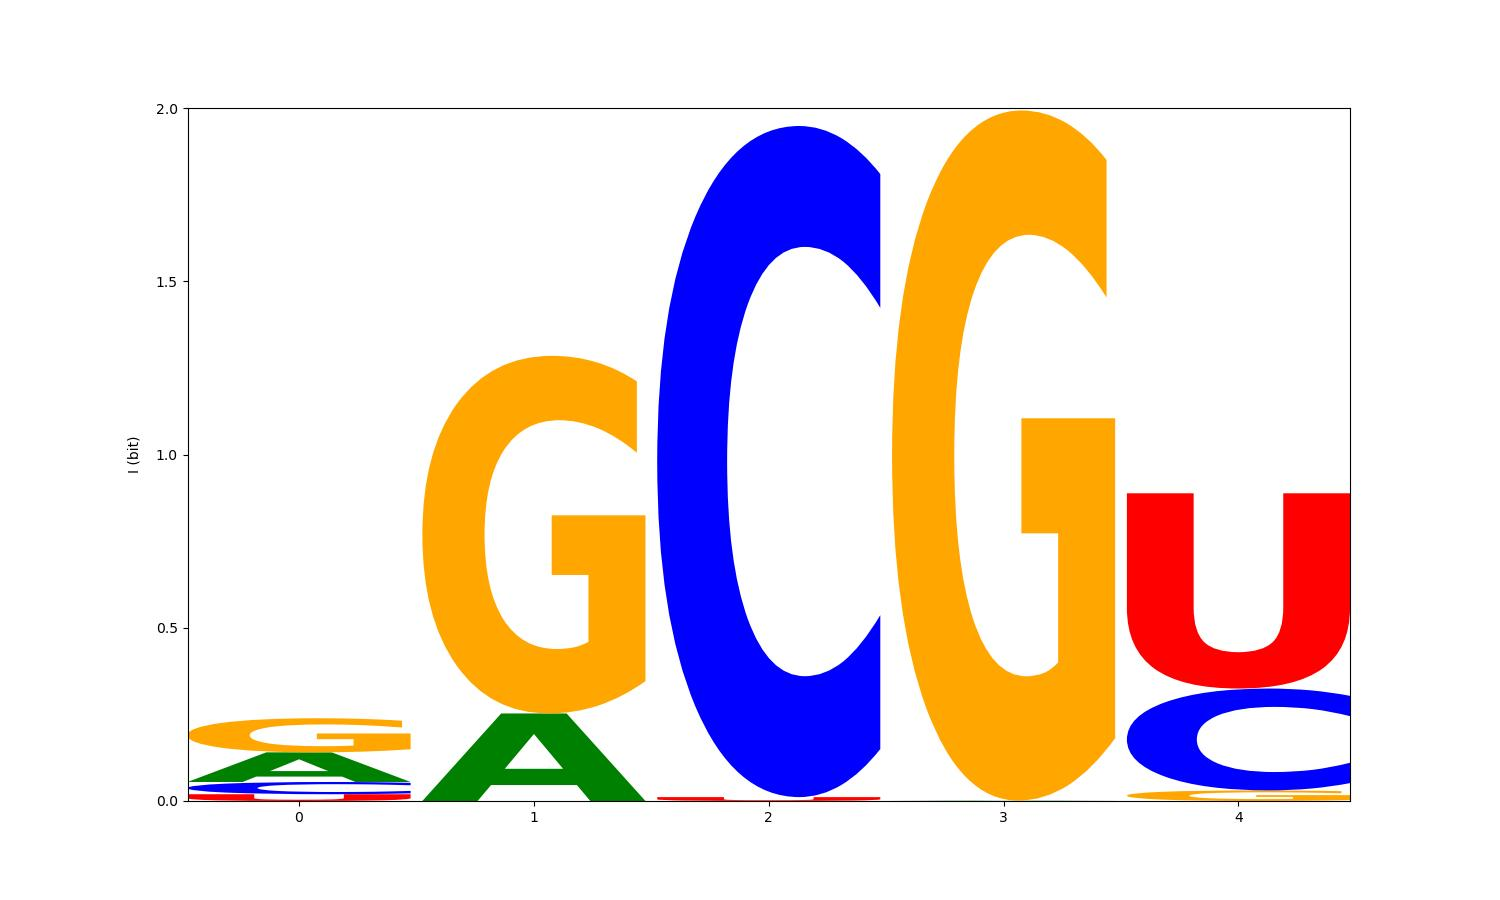
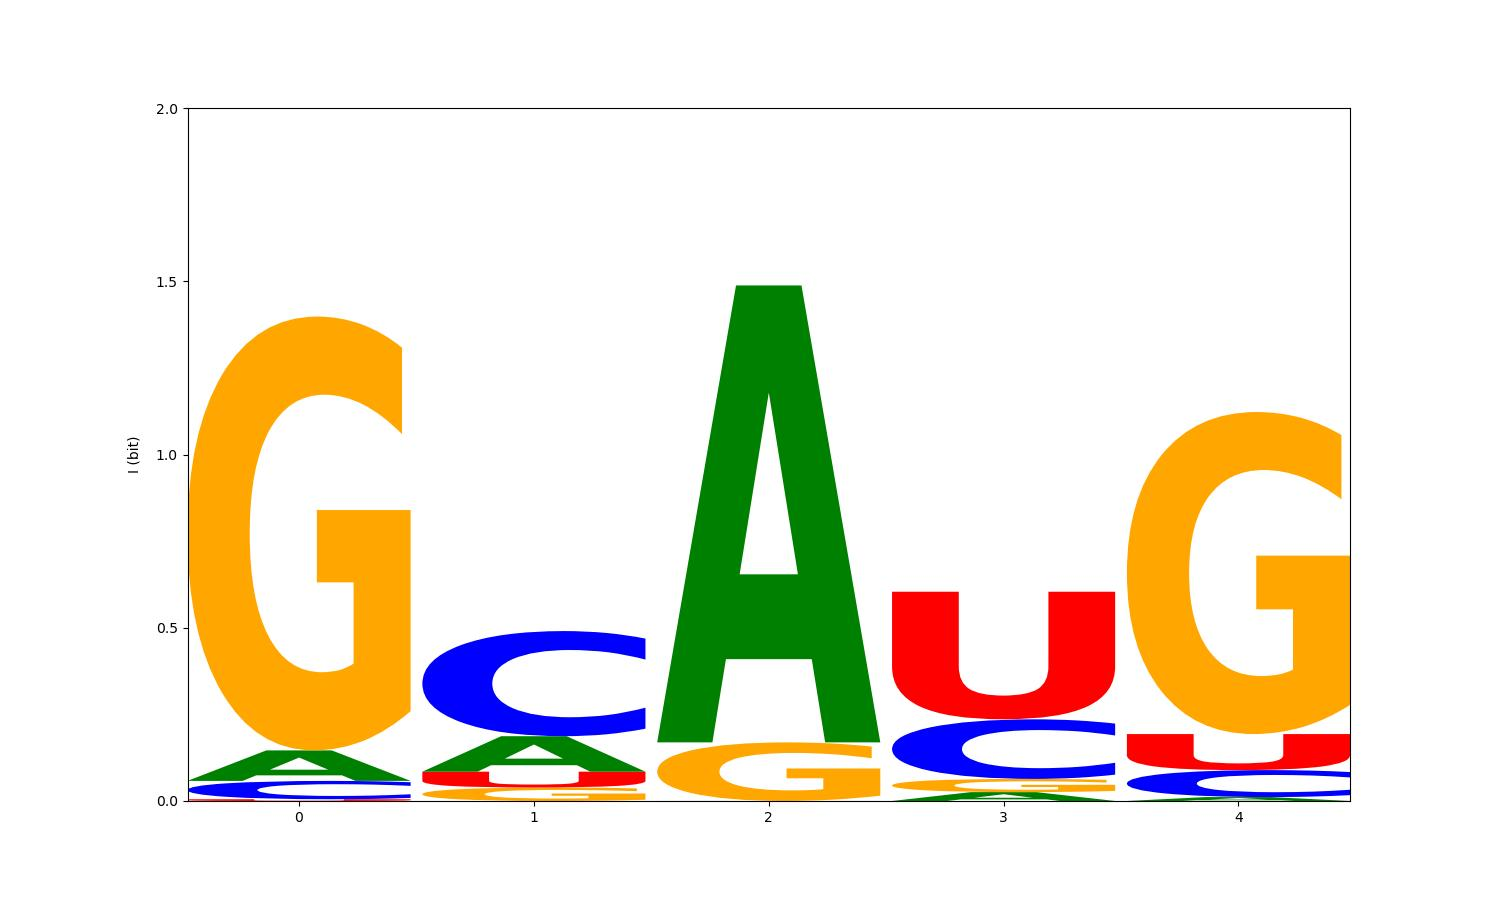
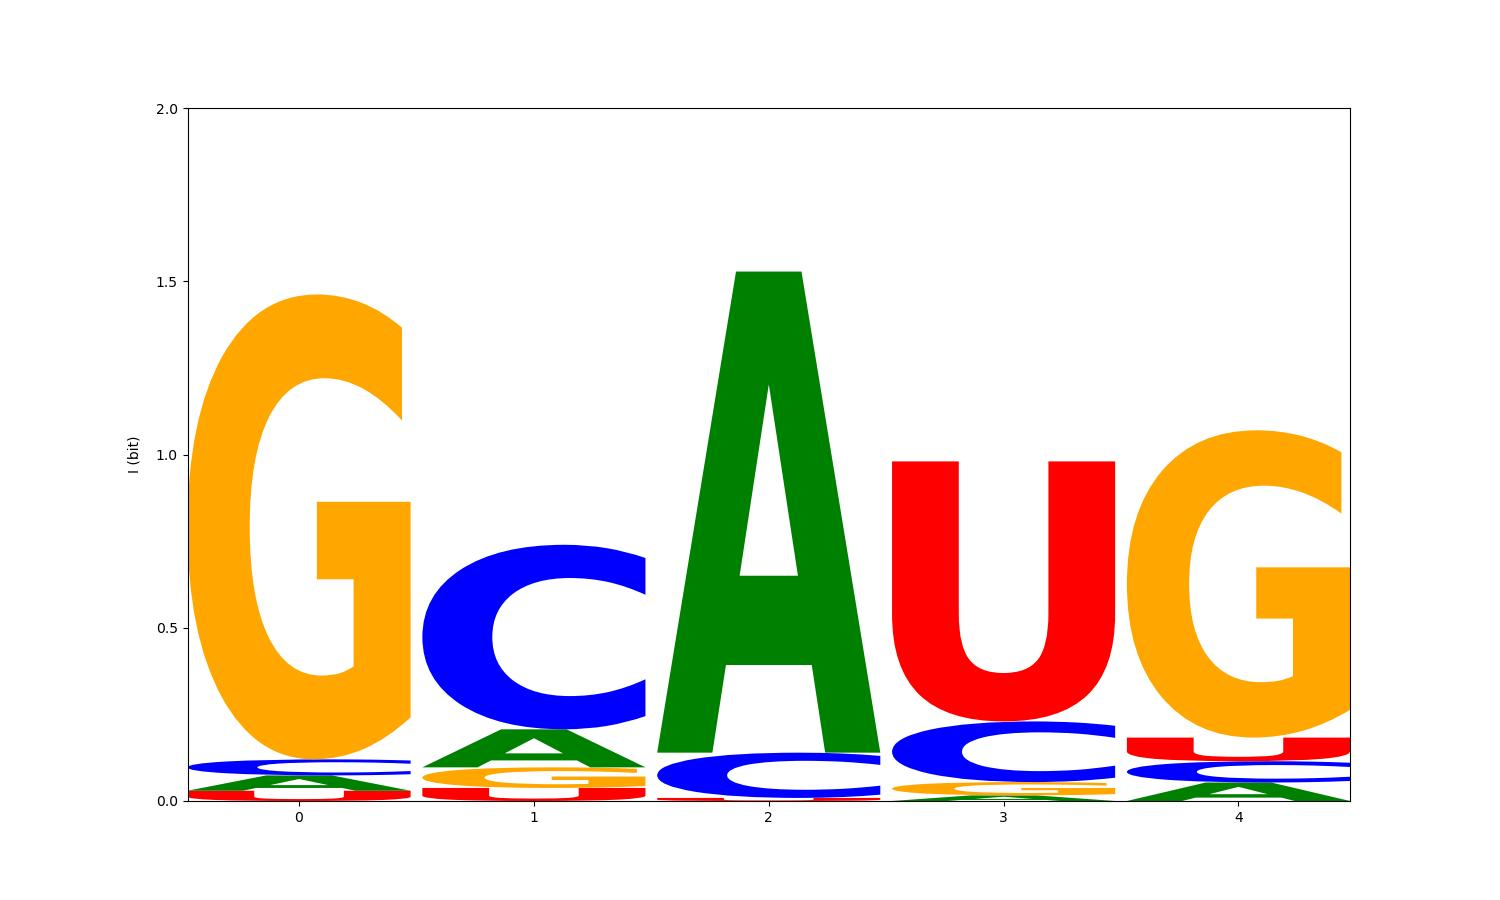
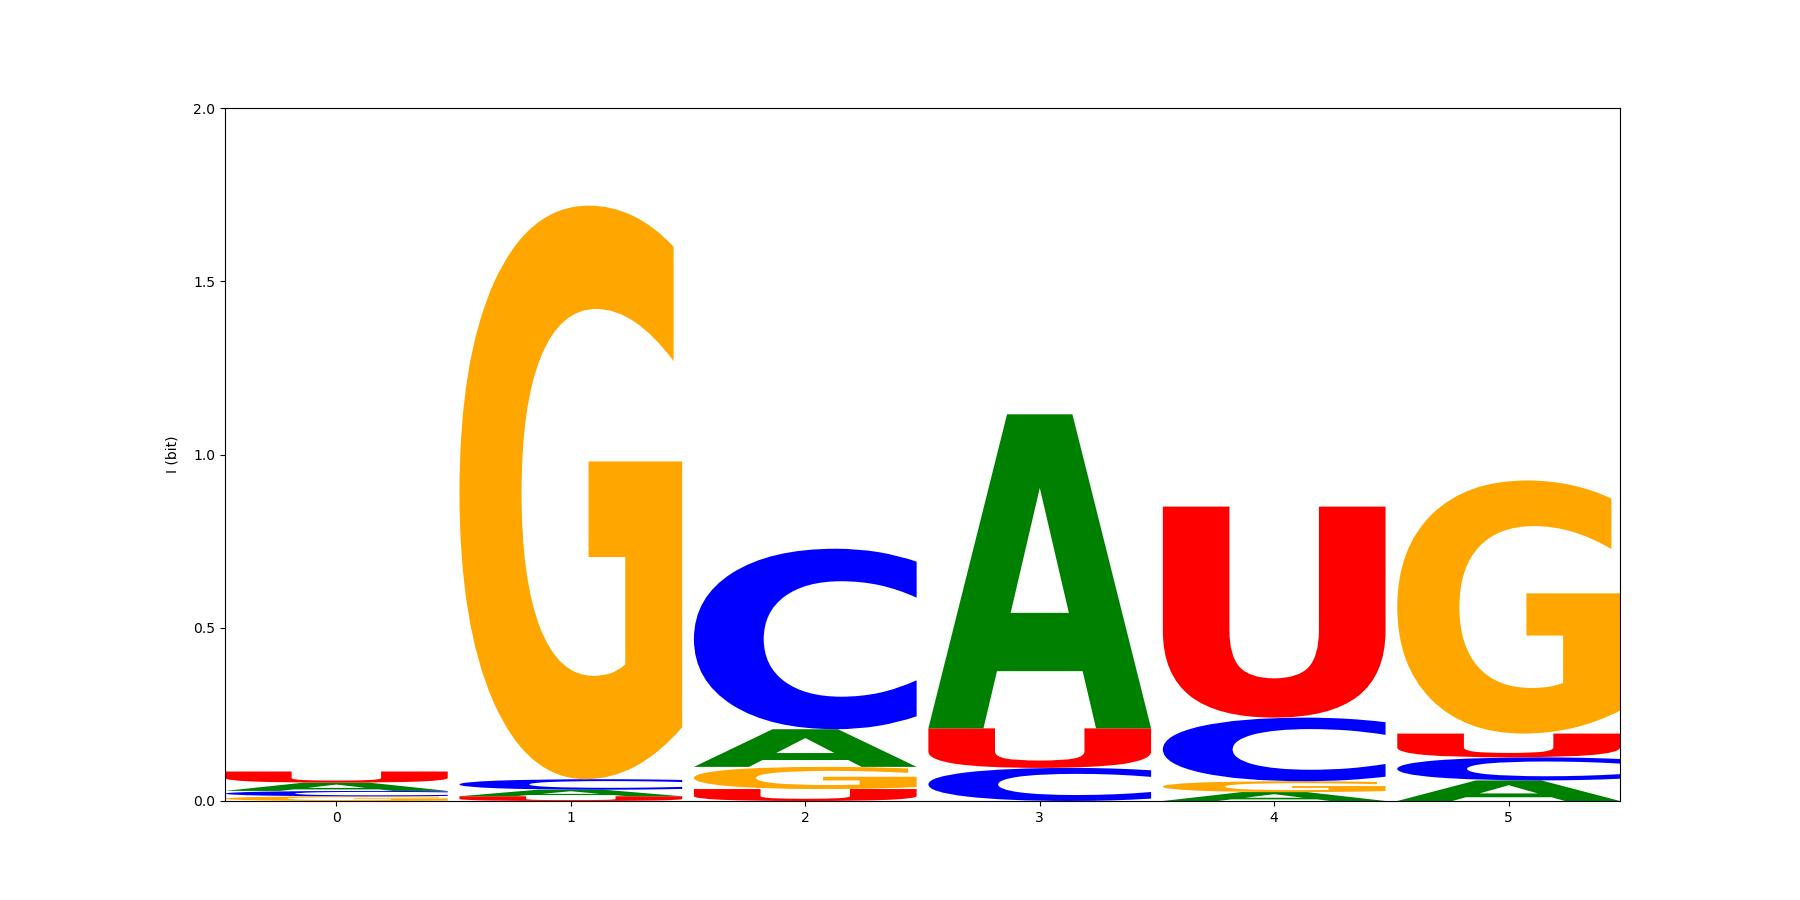
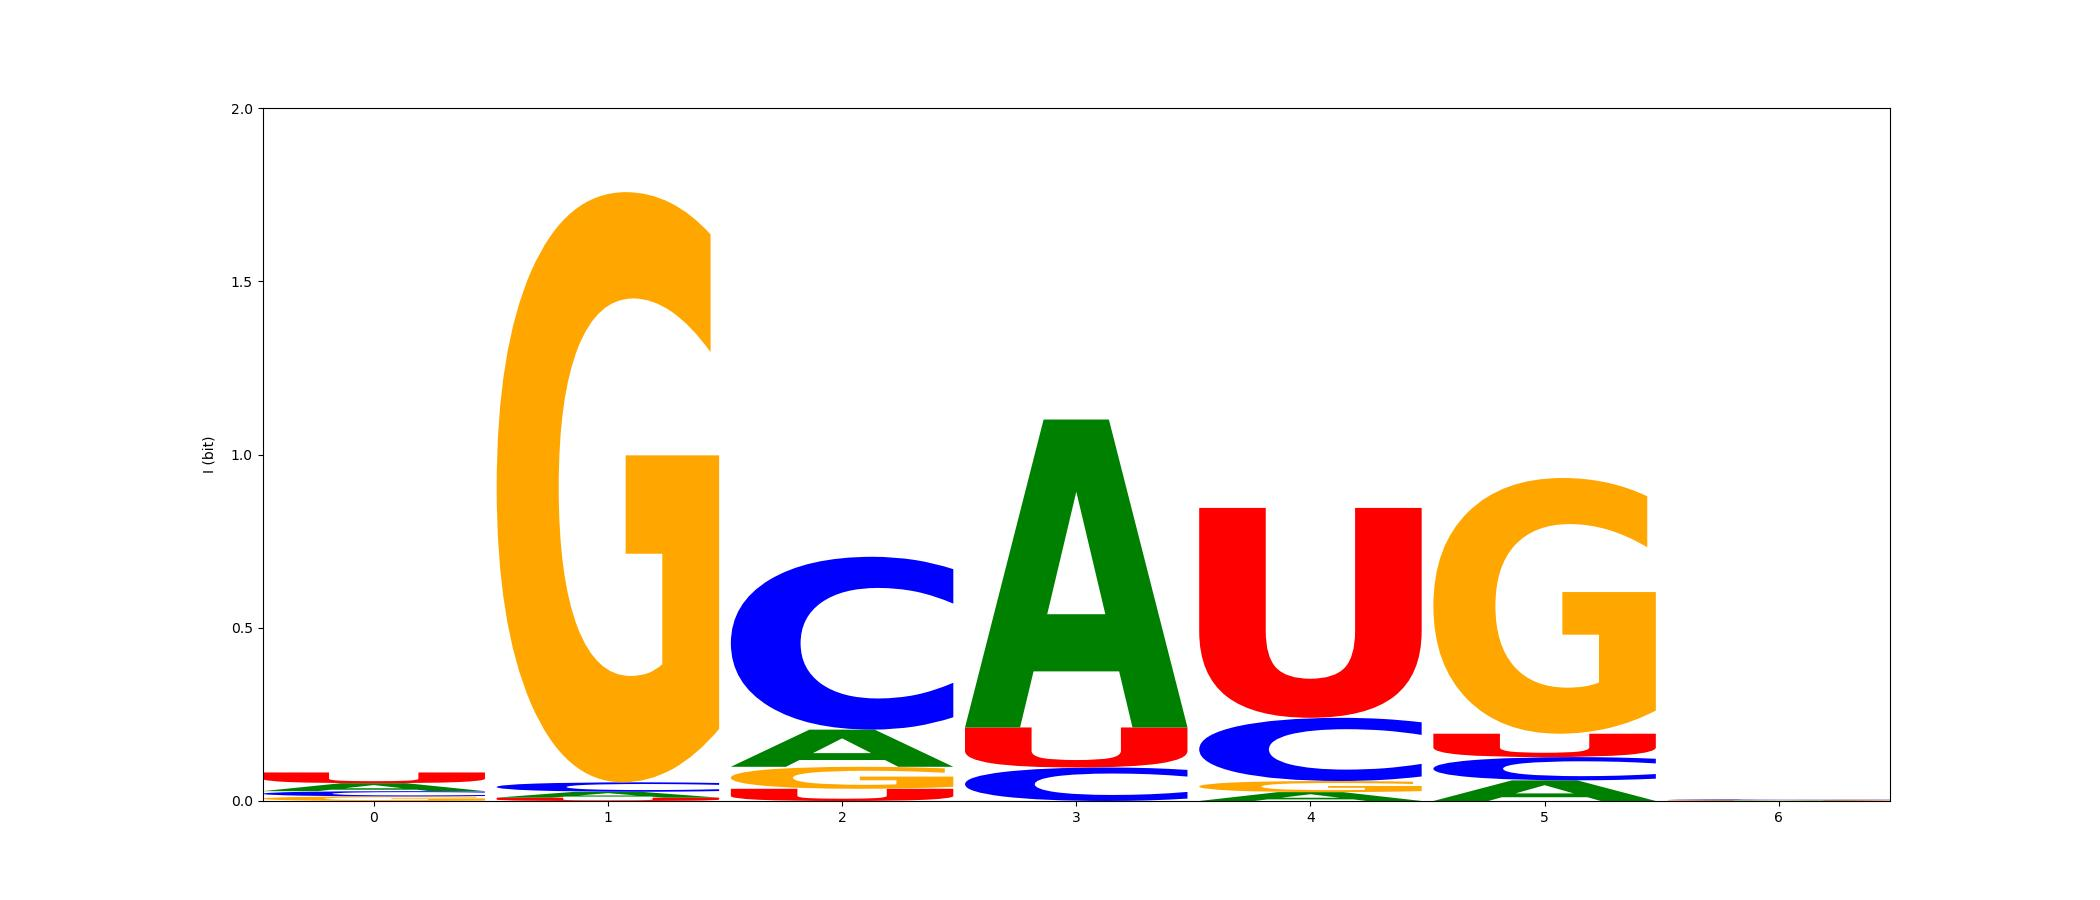
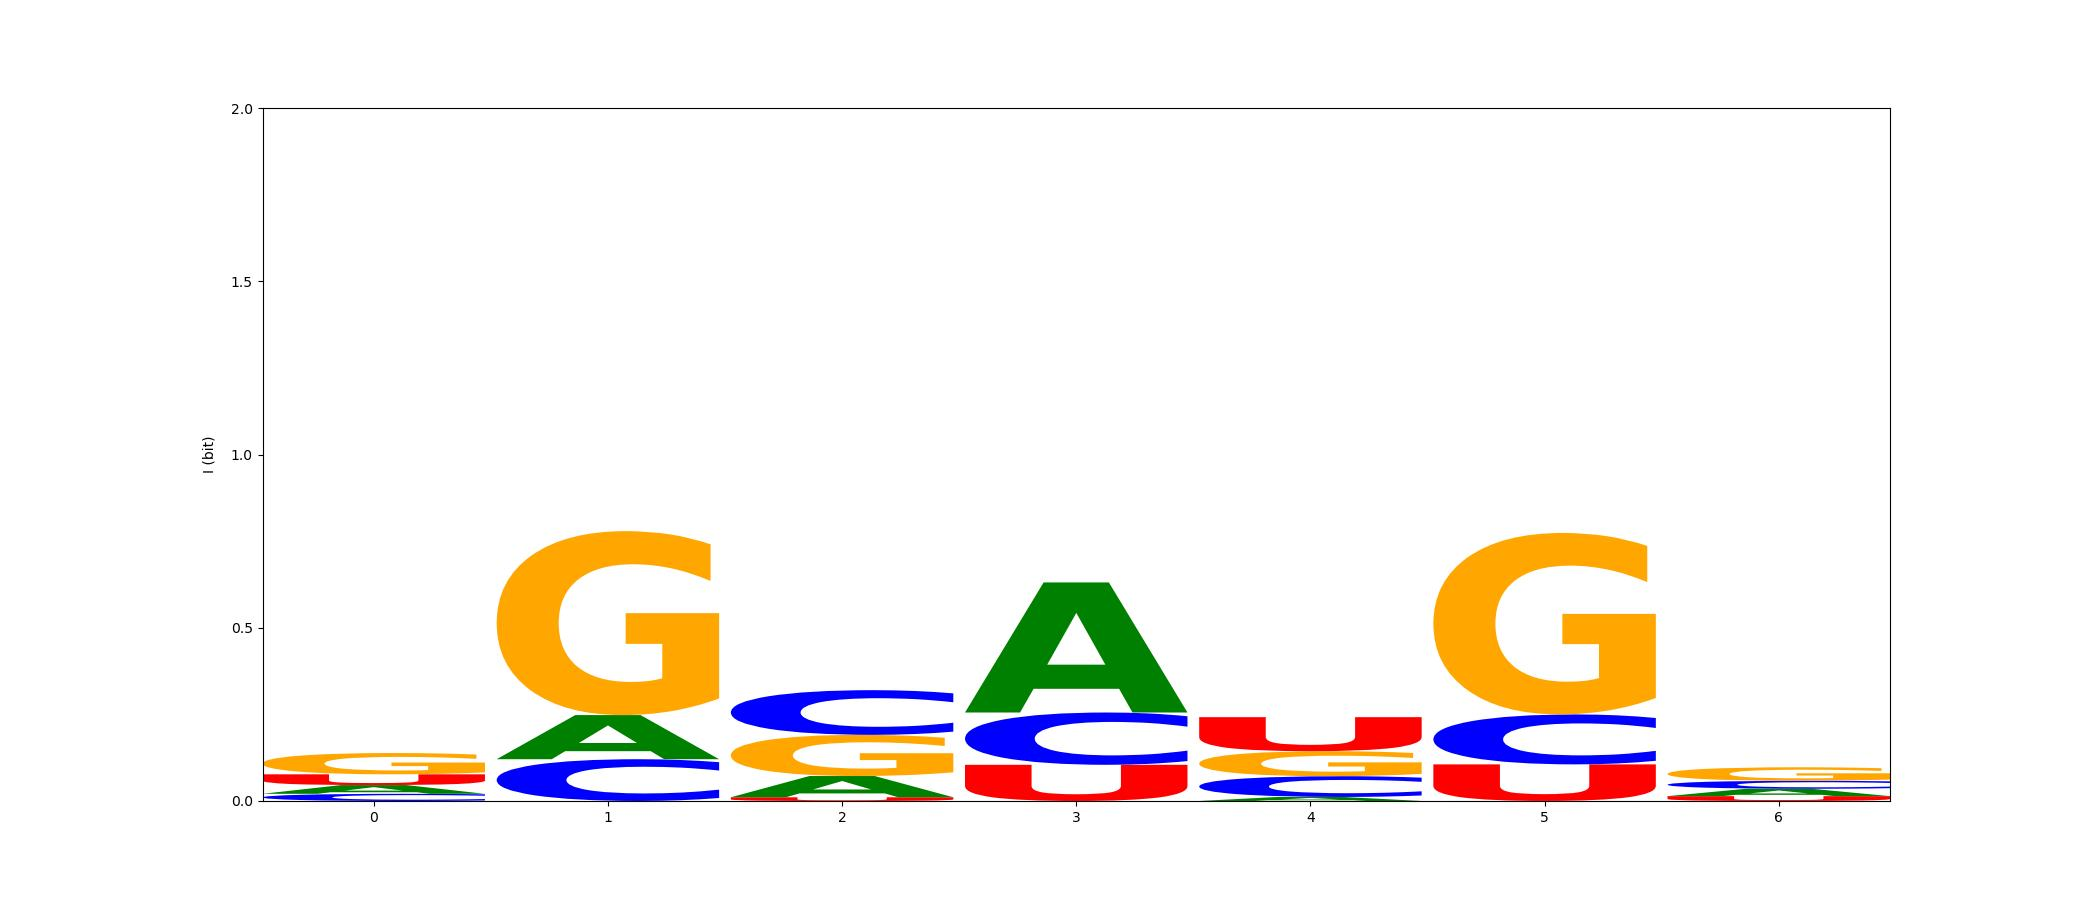

In [24]:
start = time()
model_mae=model_with_border.refit_mae(X,y)
print("Optimization took %.2f hours." % ((time() - start)/3600))

# print & display main results
model_mae.analyse_motif(X_train,y_train, THRESHOLD, nuc_type=NUC_TYPE)

# store results and display stages
STAGES.append('train, expanded, border, mae', model_mae, new_entries={'r (test)': mf.linregress(model_mae.predict(X_test),y_test).rvalue})
mf.display_df(STAGES.df, nuc_type=NUC_TYPE)

In [26]:
STAGES.df.to_json('%s_%s-%s-%s_%s-%s.json' %(PROTEIN_NAME, datetime.now().year, datetime.now().month,datetime.now().day , datetime.now().hour, datetime.now().minute))
STAGES.df.to_pickle('%s_%s-%s-%s_%s-%s.pkl' %(PROTEIN_NAME, datetime.now().year, datetime.now().month,datetime.now().day , datetime.now().hour, datetime.now().minute))

In [ ]:
df_stages.drop(index='best grid fitG0=True', inplace=True)

In [36]:
import importlib

In [37]:
importlib.reload(mf)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


<module 'motif' from '/home/GLipps/fhnw/python/T7 primase site/RNAcompete/motif.py'>